In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import t
from scipy.stats import uniform
from scipy.stats import ttest_1samp # library for p-value estimation
import ruptures as rpt # library for change point detection
%matplotlib inline
%run ./master_experminet-functions.ipynb
# load functions for the creation of the different distributions

In [2]:
# define arms
def quick_sort(df):
    sorted_df = df.sort_values(kind="quicksort")
    return sorted_df
def merge_sort(df):
    sorted_df = df.sort_values(kind="mergesort")
    return sorted_df
def heap_sort(df):
    sorted_df = df.sort_values(kind="heapsort")
    return sorted_df

In [3]:
n_samples = 500000
choices = [quick_sort,merge_sort,heap_sort]
choices_names = ["quick_sort","merge_sort","heap_sort"]
dist_types = ["Uniform","Normal","Uniform_Sorted","Uniform_Reverse_Sorted","Uniform_Nearly_Sorted","Zipf"]

In [4]:
#list_distributions = 1000*["Uniform_Sorted"] + 1000*["Normal"] # at first quick sort -> then merge sort 
list_distributions = 500*["Uniform"] +  500*["Uniform_Sorted"] + 500*["Normal"] + 500*["Uniform_Reverse_Sorted"]
#list_distributions = 100*["Uniform"] +  100*["Uniform_Sorted"] + 100*["Normal"] + 100*["Uniform_Reverse_Sorted"]

In [5]:
def plot_history(rewards,cum_rewards,sample_count, sample_mean):

    q_values = {"quick_sort": sample_mean[0], "merge_sort": sample_mean[1], "heap_sort":sample_mean[2]} ## 
    arm_counts = {"quick_sort": sample_count[0], "merge_sort": sample_count[1], "heap_sort":sample_count[2]} ##
    print("Average rewards per algo", q_values)
    print("Count per chosen algo", arm_counts)
    
    fig = plt.figure(figsize=[30,8])
    ax2 = fig.add_subplot(121)
    ax2.plot(cum_rewards, label="avg rewards")
    ax2.set_title("Cummulative Rewards")
    labels = list(arm_counts.keys())
    ax3 = fig.add_subplot(122)
    ax3.bar([i for i in range(len(arm_counts.values()))], arm_counts.values(), label=[i for i in ((list(arm_counts.keys())))])
    ax3.set_title("Chosen Actions")
    plt.show() 

In [6]:
# help function to return the humber of consecutive elements in a list 
def count_consec(listrand):
    count=1
    consec_list=[]
    for i in range(len(listrand[:-1])):
        if listrand[i]+1 == listrand[i+1]:
            count+=1
        else:
            consec_list.append(count)
            count=1

    # Account for the last iteration
    consec_list.append(count)     

    return consec_list

In [7]:
def TS_stationary(list_distributions, n_samples, var_multiplier = 5): # initialize
    total_reward = 0
    num_choices = len(choices)
    sample_count = [0 for i in range(num_choices)]
    sample_rewards = [0 for i in range(num_choices)]
    sample_mean = [0.0 for i in range(num_choices)]
    sample_var = [0.0 for i in range(num_choices)]
    arm_rewards = {0: [], 1:[], 2:[]}
    rewards = []
    cum_rewards = []
    var_multiplier = 5
    list_iteration_results = []

    len_result = 1

    for n, elem in enumerate(list_distributions):
        dist_type = elem
        distribion = create_df_distribution(n_samples=n_samples, dist_type=dist_type)
        print("\n")
        print("Iteration:", n)
        theta = {}
        for i in range(len(choices)):
            if sample_count[i] >= 2:
                theta[i] = t.rvs(df=sample_count[i]-1,loc=sample_mean[i],scale=np.sqrt(sample_var[i]/sample_count[i])*var_multiplier)
                print(choices_names[i],"Theta", theta[i])

            else:
                print("Less than two values for",choices_names[i])
                theta[i] = uniform.rvs(loc=0, scale=1)
                print(choices_names[i],"Theta", theta[i])

        choice = np.argmin([theta[i] for i in range(len(choices))])
        alg = choices[choice]
        alg_name = choices_names[choice]
        start_time = time.time()
        sorted_dist = alg(distribion[dist_type])
        reward = ((time.time() - start_time))*(1)
        print("\n")
        print("Chosen algorithm is: ", alg_name, "with reward:", reward)
        arm_rewards[choice].append(reward)
        sample_count[choice] += 1
        sample_rewards[choice] += reward
        sample_mean[choice] = np.mean(arm_rewards[choice])
        sample_var[choice] = np.var(arm_rewards[choice]).astype('float64')
        print("Sample mean is: ", sample_mean[choice], "Sample variance is:", sample_var[choice])
        total_reward += reward
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        array_rewards = np.array(rewards)

    list_iteration_results.extend([sample_mean, sample_count,rewards,cum_rewards,n])
    return list_iteration_results, total_reward

In [8]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [9]:
import bayesian_changepoint_detection.online_changepoint_detection as oncd
from functools import partial
import matplotlib.cm as cm

## Thompson Sampling

# Probabs sampled from t Student distribution

### Quick sort should be the fastest at first 500 itreations, then merge sort for for the next 500, then again quick sort for the next 500, then again merge sort for the next 500: i.e. change points/restart experiment at iteration 500, 1000 and 1500

### First Variant: One sample t-test: 
The One Sample t Test determines whether the sample mean is statistically different from a known or hypothesised population mean or in other words: the p_value is the estimated probability of achieving this value by chance from the sample set.  Generally, if we receive a p-value of less than a selected significance level, we can reject the null hypothesis and state that there is a significant difference, i.e. the sample comes from a different distribution.

In [10]:
def TS_ttest(list_distributions, n_samples, var_multiplier=5,p_val_multiplier=20,num_consec_elem=5):# initialize
    total_reward = 0
    num_choices = len(choices)
    sample_count = [0 for i in range(num_choices)]
    sample_rewards = [0 for i in range(num_choices)]
    sample_mean = [0.0 for i in range(num_choices)]
    sample_var = [0.0 for i in range(num_choices)]
    arm_rewards = {0: [], 1:[], 2:[]}
    rewards = []
    cum_rewards = []
    var_multiplier = var_multiplier
    n_consecutive_list = [] # this list is to check whether
    list_iteration_results = []
    p_val_multiplier = p_val_multiplier
    num_consec_elem = num_consec_elem

    for n, elem in enumerate(list_distributions):
        dist_type = elem
        distribion = create_df_distribution(n_samples=n_samples, dist_type=dist_type)
        print("\n")
        print("Iteration:", n)
        theta = {}
        for i in range(len(choices)):
            if sample_count[i] >= 2:
                theta[i] = t.rvs(df=sample_count[i]-1,loc=sample_mean[i],scale=np.sqrt(sample_var[i]/sample_count[i])*var_multiplier)
                print(choices_names[i],"Theta", theta[i])

            else:
                print("Less than two values for",choices_names[i])
                theta[i] = uniform.rvs(loc=0, scale=1)
                print(choices_names[i],"Theta", theta[i])

        choice = np.argmin([theta[i] for i in range(len(choices))])
        alg = choices[choice]
        alg_name = choices_names[choice]
        start_time = time.time()
        sorted_dist = alg(distribion[dist_type])
        reward = ((time.time() - start_time))*(1)
        print("\n")
        print("Chosen algorithm is: ", alg_name, "with reward:", reward)
        arm_rewards[choice].append(reward)
        sample_count[choice] += 1
        sample_rewards[choice] += reward
        sample_mean[choice] = np.mean(arm_rewards[choice])
        sample_var[choice] = np.var(arm_rewards[choice]).astype('float64')
        print("Sample mean is: ", sample_mean[choice], "Sample variance is:", sample_var[choice])
        total_reward += reward
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))

        tset, pval = ttest_1samp(arm_rewards[choice], reward)
        print("\n")
        print("p-value: ", pval)
        print("Significance level: ", (sample_var[choice]**p_val_multiplier))

        if pval < sample_var[choice]**p_val_multiplier:
            n_consecutive_list.append(n)
            if any(i >= num_consec_elem for i in count_consec(n_consecutive_list)):
                    print("RESTART EXPERIMENT AT ITERATION:", n)

                    list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
                    sample_count = [0 for i in range(num_choices)]
                    sample_rewards = [0 for i in range(num_choices)]
                    sample_mean = [0.0 for i in range(num_choices)]
                    sample_var = [0.0 for i in range(num_choices)]
                    arm_rewards = {0: [], 1:[], 2:[]}
                    rewards = []
                    cum_rewards = []
                    n_consecutive_list = []

    list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
    return list_iteration_results, total_reward

In [11]:
list_iteration_results_TS_ttest, total_reward_TS_ttest = TS_ttest(list_distributions=list_distributions, n_samples=n_samples)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.11534826053966307
Less than two values for merge_sort
merge_sort Theta 0.42247714321127516
Less than two values for heap_sort
heap_sort Theta 0.5366884506000468


Chosen algorithm is:  quick_sort with reward: 0.09674429893493652
Sample mean is:  0.09674429893493652 Sample variance is: 0.0


p-value:  nan
Significance level:  0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.731738856155021
Less than two values for merge_sort
merge_sort Theta 0.9834204763688507
Less than two values for heap_sort
heap_sort Theta 0.8717756634165235


C:\Users\iRacheva\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\iRacheva\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\iRacheva\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\iRacheva\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\iRacheva\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)




Chosen algorithm is:  quick_sort with reward: 0.10173296928405762
Sample mean is:  0.09923863410949707 Sample variance is: 6.221707963049994e-06


p-value:  0.49999999999999956
Significance level:  7.554268961595925e-105


Iteration: 2
quick_sort Theta 0.08890765813658028
Less than two values for merge_sort
merge_sort Theta 0.2664157312362875
Less than two values for heap_sort
heap_sort Theta 0.9581731498667979


Chosen algorithm is:  quick_sort with reward: 0.10870957374572754
Sample mean is:  0.10239561398824056 Sample variance is: 2.4080849218282514e-05


p-value:  0.2104276417486342
Significance level:  4.2996783446662684e-93


Iteration: 3
quick_sort Theta 0.11315532710641785
Less than two values for merge_sort
merge_sort Theta 0.8422075397205778
Less than two values for heap_sort
heap_sort Theta 0.433988566138539


Chosen algorithm is:  quick_sort with reward: 0.10173201560974121
Sample mean is:  0.10222971439361572 Sample variance is: 1.814320494020194e-05


p-value:  0.852566

merge_sort Theta 0.1147375780988858
Less than two values for heap_sort
heap_sort Theta 0.7119440122036838


Chosen algorithm is:  quick_sort with reward: 0.09774303436279297
Sample mean is:  0.10267852544784546 Sample variance is: 2.9389879924082148e-05


p-value:  0.0008236673202590746
Significance level:  2.311831805161348e-91


Iteration: 23
quick_sort Theta 0.0981875895937688
merge_sort Theta 0.11166916972873663
Less than two values for heap_sort
heap_sort Theta 0.6435914861040215


Chosen algorithm is:  quick_sort with reward: 0.09674596786499023
Sample mean is:  0.10239602270580474 Sample variance is: 2.9586517817669756e-05


p-value:  0.0001559977758929555
Significance level:  2.641660962732223e-91


Iteration: 24
quick_sort Theta 0.09656244929813651
merge_sort Theta 0.06473322378780577
Less than two values for heap_sort
heap_sort Theta 0.16876486544309977


Chosen algorithm is:  merge_sort with reward: 0.10871243476867676
Sample mean is:  0.10904685656229655 Sample variance is:



Chosen algorithm is:  quick_sort with reward: 0.09674406051635742
Sample mean is:  0.10084821837288993 Sample variance is: 3.68144668962078e-05


p-value:  0.0003799207194552036
Significance level:  2.0910784114221127e-89


Iteration: 46
quick_sort Theta 0.10441329350442945
merge_sort Theta 0.10911136592443396
heap_sort Theta 0.17338521210101424


Chosen algorithm is:  quick_sort with reward: 0.0937507152557373
Sample mean is:  0.10065106550852458 Sample variance is: 3.715226663321876e-05


p-value:  9.420390244319239e-08
Significance level:  2.510188282755311e-89


Iteration: 47
quick_sort Theta 0.10011560813537046
merge_sort Theta 0.10613661838811315
heap_sort Theta 0.22530770078066142


Chosen algorithm is:  quick_sort with reward: 0.09674334526062012
Sample mean is:  0.1005454514477704 Sample variance is: 3.654970719265096e-05


p-value:  0.0005807512457898063
Significance level:  1.8099977778303382e-89


Iteration: 48
quick_sort Theta 0.09937434938003199
merge_sort Theta 0.11056



Chosen algorithm is:  merge_sort with reward: 0.10472273826599121
Sample mean is:  0.10610459401057316 Sample variance is: 5.441817467145436e-06


p-value:  0.06264800297675577
Significance level:  5.186559998409869e-106


Iteration: 70
quick_sort Theta 0.10565361521306586
merge_sort Theta 0.11066310102124045
heap_sort Theta 0.1532430910555481


Chosen algorithm is:  quick_sort with reward: 0.09375190734863281
Sample mean is:  0.09916393845169633 Sample variance is: 3.248015702914158e-05


p-value:  6.2179102566688634e-09
Significance level:  1.7075066527280165e-90


Iteration: 71
quick_sort Theta 0.099005705609204
merge_sort Theta 0.1019139188011563
heap_sort Theta 0.1797108819254485


Chosen algorithm is:  quick_sort with reward: 0.0957489013671875
Sample mean is:  0.09910184686834161 Sample variance is: 3.209779841458952e-05


p-value:  6.104528494511528e-05
Significance level:  1.3474259404033259e-90


Iteration: 72
quick_sort Theta 0.0954170527029329
merge_sort Theta 0.104998639



Chosen algorithm is:  quick_sort with reward: 0.09774088859558105
Sample mean is:  0.09826652940950896 Sample variance is: 2.5929294713806858e-05


p-value:  0.37419620795158637
Significance level:  1.887183276146714e-92


Iteration: 94
quick_sort Theta 0.09417397148004676
merge_sort Theta 0.10975531777180518
heap_sort Theta 0.23283124641828434


Chosen algorithm is:  quick_sort with reward: 0.09375166893005371
Sample mean is:  0.09820789485782772 Sample variance is: 2.5853839436079896e-05


p-value:  5.358643566146691e-11
Significance level:  1.780331788257696e-92


Iteration: 95
quick_sort Theta 0.09717629004172249
merge_sort Theta 0.10464018318285864
heap_sort Theta 0.1740112132853245


Chosen algorithm is:  quick_sort with reward: 0.09674310684204102
Sample mean is:  0.09818911552429199 Sample variance is: 2.55495350354697e-05


p-value:  0.014160384582737256
Significance level:  1.4049472554020306e-92


Iteration: 96
quick_sort Theta 0.09616221976010662
merge_sort Theta 0.113115

Iteration: 117
quick_sort Theta 0.10159046459170629
merge_sort Theta 0.10488067666478251
heap_sort Theta 0.20026272071137127


Chosen algorithm is:  quick_sort with reward: 0.09674572944641113
Sample mean is:  0.0977721895490374 Sample variance is: 2.1508958465049974e-05


p-value:  0.03169170680385089
Significance level:  4.4914608492043453e-94


Iteration: 118
quick_sort Theta 0.09986645684407783
merge_sort Theta 0.1083332693289941
heap_sort Theta 0.18852776355846199


Chosen algorithm is:  quick_sort with reward: 0.09774160385131836
Sample mean is:  0.09777188060259578 Sample variance is: 2.129170561222687e-05


p-value:  0.9483416122493719
Significance level:  3.666140090554729e-94


Iteration: 119
quick_sort Theta 0.09518480164863505
merge_sort Theta 0.10824331353906776
heap_sort Theta 0.21529254720000787


Chosen algorithm is:  quick_sort with reward: 0.09474658966064453
Sample mean is:  0.09774162769317626 Sample variance is: 2.1169397170410777e-05


p-value:  3.6458390909602882

merge_sort Theta 0.10392334705815759
heap_sort Theta 0.2773369269945242


Chosen algorithm is:  quick_sort with reward: 0.09674644470214844
Sample mean is:  0.09750262370779494 Sample variance is: 1.812092600166232e-05


p-value:  0.054002261314874574
Significance level:  1.4574972292628544e-95


Iteration: 142
quick_sort Theta 0.09933730555219439
merge_sort Theta 0.11115137193172238
heap_sort Theta 0.13406896254358822


Chosen algorithm is:  quick_sort with reward: 0.09774184226989746
Sample mean is:  0.09750458451568103 Sample variance is: 1.797285903819633e-05


p-value:  0.5393092340331422
Significance level:  1.236924986890657e-95


Iteration: 143
quick_sort Theta 0.09789853852072233
merge_sort Theta 0.10521444157455645
heap_sort Theta 0.2441263618640557


Chosen algorithm is:  quick_sort with reward: 0.09375143051147461
Sample mean is:  0.09747407106849236 Sample variance is: 1.7940328829046706e-05


p-value:  7.425856662789245e-17
Significance level:  1.19291082521399e-95


Iter



Chosen algorithm is:  quick_sort with reward: 0.0987405776977539
Sample mean is:  0.0973289703500682 Sample variance is: 1.6186585729160033e-05


p-value:  4.470232924641817e-05
Significance level:  1.5244213941612923e-96


Iteration: 166
quick_sort Theta 0.09816827034484853
merge_sort Theta 0.10328882606097363
heap_sort Theta 0.1681676103177192


Chosen algorithm is:  quick_sort with reward: 0.09375143051147461
Sample mean is:  0.09730446665254358 Sample variance is: 1.6162781226512614e-05


p-value:  6.632001130193095e-20
Significance level:  1.4802050801614332e-96


Iteration: 167
quick_sort Theta 0.09913345160206803
merge_sort Theta 0.10434043292781371
heap_sort Theta 0.1993967380140103


Chosen algorithm is:  quick_sort with reward: 0.09674644470214844
Sample mean is:  0.09730067058485381 Sample variance is: 1.605493421278142e-05


p-value:  0.09680104721862609
Significance level:  1.2947043481406332e-96


Iteration: 168
quick_sort Theta 0.09814700674914532
merge_sort Theta 0.10

quick_sort Theta 0.09543933698620345
merge_sort Theta 0.10743150433684774
heap_sort Theta 0.13551472531458592


Chosen algorithm is:  quick_sort with reward: 0.09674334526062012
Sample mean is:  0.09713972672908264 Sample variance is: 1.4589992747701421e-05


p-value:  0.18041996390679596
Significance level:  1.910299756582111e-97


Iteration: 191
quick_sort Theta 0.09399802515555938
merge_sort Theta 0.10703259453690735
heap_sort Theta 0.16766689004758487


Chosen algorithm is:  quick_sort with reward: 0.09774208068847656
Sample mean is:  0.09714326998766731 Sample variance is: 1.4506291002106472e-05


p-value:  0.04251780391594345
Significance level:  1.702659111321784e-97


Iteration: 192
quick_sort Theta 0.09581655262000315
merge_sort Theta 0.10838649512004019
heap_sort Theta 0.19770688171495715


Chosen algorithm is:  quick_sort with reward: 0.09375119209289551
Sample mean is:  0.09712343327483239 Sample variance is: 1.4488353070919222e-05


p-value:  3.7496340783530644e-23
Signifi



Chosen algorithm is:  quick_sort with reward: 0.09674477577209473
Sample mean is:  0.0969988964498043 Sample variance is: 1.3298650352549143e-05


p-value:  0.3367355894506844
Significance level:  2.993307641714421e-98


Iteration: 215
quick_sort Theta 0.09668322166964202
merge_sort Theta 0.09955940792370908
heap_sort Theta 0.2192498347784492


Chosen algorithm is:  quick_sort with reward: 0.09474897384643555
Sample mean is:  0.09698723881973503 Sample variance is: 1.3255838293498395e-05


p-value:  4.666279586050856e-15
Significance level:  2.8063636773537902e-98


Iteration: 216
quick_sort Theta 0.09731721952144338
merge_sort Theta 0.10296910456375924
heap_sort Theta 0.2529803550971105


Chosen algorithm is:  quick_sort with reward: 0.09574699401855469
Sample mean is:  0.09698084580529596 Sample variance is: 1.3195397262418162e-05


p-value:  4.546572434198959e-06
Significance level:  2.561234797592206e-98


Iteration: 217
quick_sort Theta 0.09759940774703174
merge_sort Theta 0.106

Iteration: 239
quick_sort Theta 0.09528174083795872
merge_sort Theta 0.10183580993076927
heap_sort Theta 0.23135181543423508


Chosen algorithm is:  quick_sort with reward: 0.09674668312072754
Sample mean is:  0.09687301530266687 Sample variance is: 1.2169583446921757e-05


p-value:  0.5951106309668575
Significance level:  5.075914055467419e-99


Iteration: 240
quick_sort Theta 0.09785377452956356
merge_sort Theta 0.10462811569080639
heap_sort Theta 0.2455858418254674


Chosen algorithm is:  quick_sort with reward: 0.09674382209777832
Sample mean is:  0.09687242267328665 Sample variance is: 1.211383588212166e-05


p-value:  0.5867994041231419
Significance level:  4.630562082078882e-99


Iteration: 241
quick_sort Theta 0.09571271778031232
merge_sort Theta 0.10884130027551953
heap_sort Theta 0.2742378931124994


Chosen algorithm is:  quick_sort with reward: 0.09375119209289551
Sample mean is:  0.09685817047885564 Sample variance is: 1.210280282307486e-05


p-value:  1.3945126791387694e-2

Iteration: 263
quick_sort Theta 0.09844644036807008
merge_sort Theta 0.10576438727088756
heap_sort Theta 0.20482959808027495


Chosen algorithm is:  quick_sort with reward: 0.09774422645568848
Sample mean is:  0.09682296420528681 Sample variance is: 1.1367004061469703e-05


p-value:  3.28295135379083e-05
Significance level:  1.2969412497628654e-99


Iteration: 264
quick_sort Theta 0.0978418575161456
merge_sort Theta 0.10635565118663083
heap_sort Theta 0.1829237379487249


Chosen algorithm is:  quick_sort with reward: 0.09774303436279297
Sample mean is:  0.09682676614808643 Sample variance is: 1.1323516569648019e-05


p-value:  3.362016237287702e-05
Significance level:  1.2012306324770354e-99


Iteration: 265
quick_sort Theta 0.09841330950828067
merge_sort Theta 0.10584322627465051
heap_sort Theta 0.21413549735245266


Chosen algorithm is:  quick_sort with reward: 0.09474921226501465
Sample mean is:  0.09681821654362933 Sample variance is: 1.1294606904230245e-05


p-value:  1.2524921692



Chosen algorithm is:  quick_sort with reward: 0.09973645210266113
Sample mean is:  0.09677838014833855 Sample variance is: 1.0667733608634626e-05


p-value:  4.523659352754919e-36
Significance level:  3.6428663803798287e-100


Iteration: 287
quick_sort Theta 0.09584808414015275
merge_sort Theta 0.10820735064028479
heap_sort Theta 0.2214207000581857


Chosen algorithm is:  quick_sort with reward: 0.09375190734863281
Sample mean is:  0.09676695949626418 Sample variance is: 1.066191187167563e-05


p-value:  3.2330150456020576e-37
Significance level:  3.6033111784204875e-100


Iteration: 288
quick_sort Theta 0.09638528968172273
merge_sort Theta 0.10691238118991085
heap_sort Theta 0.19571013008555643


Chosen algorithm is:  quick_sort with reward: 0.10472226142883301
Sample mean is:  0.09679686664638662 Sample variance is: 1.0858855467756426e-05


p-value:  3.5403817839826873e-112
Significance level:  5.196142508290654e-100


Iteration: 289
quick_sort Theta 0.09606736598205376
merge_sort 



Chosen algorithm is:  quick_sort with reward: 0.09674406051635742
Sample mean is:  0.09674772289064196 Sample variance is: 1.0304911990673726e-05


p-value:  0.9845930683867927
Significance level:  1.8234159130467553e-100


Iteration: 311
quick_sort Theta 0.09706667427719516
merge_sort Theta 0.11055312539000178
heap_sort Theta 0.21201251777658264


Chosen algorithm is:  quick_sort with reward: 0.09375166893005371
Sample mean is:  0.09673735592192019 Sample variance is: 1.0300207379415542e-05


p-value:  6.983022329371317e-41
Significance level:  1.806838655915998e-100


Iteration: 312
quick_sort Theta 0.09668148058236278
merge_sort Theta 0.10816467462346384
heap_sort Theta 0.2558285915499589


Chosen algorithm is:  quick_sort with reward: 0.09674334526062012
Sample mean is:  0.09673737657481227 Sample variance is: 1.0264689546205422e-05


p-value:  0.9747566924842811
Significance level:  1.6862283040650382e-100


Iteration: 313
quick_sort Theta 0.09763128227959071
merge_sort Theta 0.



Chosen algorithm is:  quick_sort with reward: 0.09774184226989746
Sample mean is:  0.09670270253450443 Sample variance is: 9.752967040369022e-06


p-value:  1.1294929202181479e-08
Significance level:  6.063664037956154e-101


Iteration: 335
quick_sort Theta 0.0965098979614653
merge_sort Theta 0.1055435940274928
heap_sort Theta 0.18839301396020539


Chosen algorithm is:  quick_sort with reward: 0.09375214576721191
Sample mean is:  0.09669327583556739 Sample variance is: 9.749532548951463e-06


p-value:  6.131519667849652e-45
Significance level:  6.021100418434175e-101


Iteration: 336
quick_sort Theta 0.09717246398103663
merge_sort Theta 0.10047424749458118
heap_sort Theta 0.19297254547202122


Chosen algorithm is:  quick_sort with reward: 0.0957489013671875
Sample mean is:  0.09669026827356618 Sample variance is: 9.721314301571879e-06


p-value:  1.776152010704772e-07
Significance level:  5.681979888780152e-101


Iteration: 337
quick_sort Theta 0.09614971936209314
merge_sort Theta 0.



Iteration: 359
quick_sort Theta 0.09670929059499198
merge_sort Theta 0.1072451603001545
heap_sort Theta 0.22504408292110892


Chosen algorithm is:  quick_sort with reward: 0.09674620628356934
Sample mean is:  0.09666139011213264 Sample variance is: 9.233880729055264e-06


p-value:  0.6092459153458645
Significance level:  2.0308844405609345e-101


Iteration: 360
quick_sort Theta 0.0975826849489462
merge_sort Theta 0.11157316086044089
heap_sort Theta 0.18996052096996008


Chosen algorithm is:  quick_sort with reward: 0.09674549102783203
Sample mean is:  0.09666163893140985 Sample variance is: 9.206582419318688e-06


p-value:  0.6122640395485823
Significance level:  1.9141188855160577e-101


Iteration: 361
quick_sort Theta 0.0970667251639424
merge_sort Theta 0.10728430930888237
heap_sort Theta 0.20765689535599793


Chosen algorithm is:  quick_sort with reward: 0.09375143051147461
Sample mean is:  0.09665305424580532 Sample variance is: 9.204333886586577e-06


p-value:  1.319042022095331

merge_sort Theta 0.10731877150636483
heap_sort Theta 0.22272912255484995


Chosen algorithm is:  quick_sort with reward: 0.09774088859558105
Sample mean is:  0.09663650864049007 Sample variance is: 8.893223906074167e-06


p-value:  1.0657443755983753e-11
Significance level:  9.57600876812279e-102


Iteration: 384
quick_sort Theta 0.09708379624883706
merge_sort Theta 0.10842855976589841
heap_sort Theta 0.22800610920468092


Chosen algorithm is:  quick_sort with reward: 0.09774041175842285
Sample mean is:  0.09663955809661696 Sample variance is: 8.872013994150357e-06


p-value:  1.0907597153219082e-11
Significance level:  9.129444723109444e-102


Iteration: 385
quick_sort Theta 0.09572524895556717
merge_sort Theta 0.10510330774952376
heap_sort Theta 0.2311844147854182


Chosen algorithm is:  quick_sort with reward: 0.09375190734863281
Sample mean is:  0.09663160313587872 Sample variance is: 8.870481051174758e-06


p-value:  7.860473510451172e-54
Significance level:  9.097947996386039e-10

Iteration: 407
quick_sort Theta 0.0965541454796063
merge_sort Theta 0.10706437336480487
heap_sort Theta 0.3090309911889738


Chosen algorithm is:  quick_sort with reward: 0.09973859786987305
Sample mean is:  0.09661732710801162 Sample variance is: 8.56106605815498e-06


p-value:  2.424947975645295e-65
Significance level:  4.472568106734105e-102


Iteration: 408
quick_sort Theta 0.09754672400314505
merge_sort Theta 0.1011988686510338
heap_sort Theta 0.20552102904442776


Chosen algorithm is:  quick_sort with reward: 0.0987405776977539
Sample mean is:  0.09662282775720785 Sample variance is: 8.55053613005145e-06


p-value:  3.852784047030394e-37
Significance level:  4.3638210062482444e-102


Iteration: 409
quick_sort Theta 0.09618582464004057
merge_sort Theta 0.10837311106489206
heap_sort Theta 0.2170653340423068


Chosen algorithm is:  quick_sort with reward: 0.09375143051147461
Sample mean is:  0.09661540812608191 Sample variance is: 8.54969137889996e-06


p-value:  2.4184824638132102e



Iteration: 430
Less than two values for quick_sort
quick_sort Theta 0.5507478513217003
Less than two values for merge_sort
merge_sort Theta 0.7269259348587479
heap_sort Theta 0.10916934217712013


Chosen algorithm is:  heap_sort with reward: 0.21842241287231445
Sample mean is:  0.2282292048136393 Sample variance is: 0.00022692818477152183


p-value:  0.20524734590230703
Significance level:  1.3115014748978087e-73


Iteration: 431
Less than two values for quick_sort
quick_sort Theta 0.9609122988206834
Less than two values for merge_sort
merge_sort Theta 0.0685962437802825
heap_sort Theta 0.2858982253916632


Chosen algorithm is:  merge_sort with reward: 0.10372400283813477
Sample mean is:  0.1032264232635498 Sample variance is: 2.475854330441507e-07


p-value:  0.49999999999999956
Significance level:  7.490344255914256e-133


Iteration: 432
Less than two values for quick_sort
quick_sort Theta 0.5353873578607126
merge_sort Theta 0.08362914306569222
heap_sort Theta 0.2186707544961757




Iteration: 454
quick_sort Theta 0.08651294737326604
merge_sort Theta 0.10466221845702116
heap_sort Theta 0.21562922213177052


Chosen algorithm is:  quick_sort with reward: 0.09973716735839844
Sample mean is:  0.09730899333953857 Sample variance is: 2.473958845996549e-05


p-value:  0.04665256217570728
Significance level:  7.376484231127668e-93


Iteration: 455
quick_sort Theta 0.09498194783233142
merge_sort Theta 0.1049760687350859
heap_sort Theta 0.24422630265977058


Chosen algorithm is:  quick_sort with reward: 0.0987389087677002
Sample mean is:  0.09737708455040342 Sample variance is: 2.365424107895555e-05


p-value:  0.2249350120980065
Significance level:  3.007325069714606e-93


Iteration: 456
quick_sort Theta 0.10448088549912926
merge_sort Theta 0.10266650603587883
heap_sort Theta 0.21392608365039048


Chosen algorithm is:  merge_sort with reward: 0.1017303466796875
Sample mean is:  0.10415312222072057 Sample variance is: 2.5175743373011403e-06


p-value:  0.009619930831793086


Iteration: 478
quick_sort Theta 0.09641065978127361
merge_sort Theta 0.10075758982315769
heap_sort Theta 0.19919824478037357


Chosen algorithm is:  quick_sort with reward: 0.09674549102783203
Sample mean is:  0.09665483963198779 Sample variance is: 1.369641171048752e-05


p-value:  0.8776652721377136
Significance level:  5.396796548757537e-98


Iteration: 479
quick_sort Theta 0.09376310222546672
merge_sort Theta 0.107843556156184
heap_sort Theta 0.1732493553386792


Chosen algorithm is:  quick_sort with reward: 0.09674406051635742
Sample mean is:  0.09665696393875849 Sample variance is: 1.3370491689611124e-05


p-value:  0.8795269924681265
Significance level:  3.3338616095814e-98


Iteration: 480
quick_sort Theta 0.09764635656765573
merge_sort Theta 0.1097777242448766
heap_sort Theta 0.22870737289581847


Chosen algorithm is:  quick_sort with reward: 0.09474825859069824
Sample mean is:  0.09661257544229197 Sample variance is: 1.31423042443903e-05


p-value:  0.001802096119759246
Signi



Iteration: 502
quick_sort Theta 0.09608261274417645
merge_sort Theta 0.1038902741110796
heap_sort Theta 0.20247057828278867


Chosen algorithm is:  quick_sort with reward: 0.03191494941711426
Sample mean is:  0.09415615155146673 Sample variance is: 0.00020458128997077803


p-value:  2.627305629057419e-43
Significance level:  1.6493706182031654e-74


Iteration: 503
quick_sort Theta 0.10058657773901143
merge_sort Theta 0.10326723513997281
heap_sort Theta 0.25204087309269835


Chosen algorithm is:  quick_sort with reward: 0.03191518783569336
Sample mean is:  0.09321310664668228 Sample variance is: 0.00025928826346466294


p-value:  2.1377820624502357e-40
Significance level:  1.8865016198492817e-72


Iteration: 504
quick_sort Theta 0.07767985186803508
merge_sort Theta 0.10200076188795312
heap_sort Theta 0.2570567050367799


Chosen algorithm is:  quick_sort with reward: 0.03191542625427246
Sample mean is:  0.09229821589455675 Sample variance is: 0.0003106619452125375


p-value:  3.4761024



Iteration: 526
quick_sort Theta 0.07169226675520042
merge_sort Theta 0.004740881929654023
heap_sort Theta 0.23659196140344402


Chosen algorithm is:  merge_sort with reward: 0.02593255043029785
Sample mean is:  0.05667594204778257 Sample variance is: 0.0014578217769583574


p-value:  0.0010381722162219598
Significance level:  1.8797005510470914e-57


Iteration: 527
quick_sort Theta 0.0861263074145462
merge_sort Theta 0.08763742994709804
heap_sort Theta 0.215867759804202


Chosen algorithm is:  quick_sort with reward: 0.031914472579956055
Sample mean is:  0.0852001152540508 Sample variance is: 0.0006490020474705132


p-value:  4.1428855600710945e-29
Significance level:  1.757605238343352e-64


Iteration: 528
quick_sort Theta 0.07696584289709618
merge_sort Theta -0.06913102001261112
heap_sort Theta 0.1147258858849696


Chosen algorithm is:  merge_sort with reward: 0.025931119918823242
Sample mean is:  0.05539490779240926 Sample variance is: 0.0014348233244775423


p-value:  0.001096161



Iteration: 550
quick_sort Theta 0.08340677417083522
merge_sort Theta 0.07760651143615939
heap_sort Theta 0.28462824167710565


Chosen algorithm is:  merge_sort with reward: 0.028924226760864258
Sample mean is:  0.04291628655933198 Sample variance is: 0.001027991322535682


p-value:  0.00787308584362199
Significance level:  1.7369566283896695e-60


Iteration: 551
quick_sort Theta 0.06570664299711027
merge_sort Theta 0.037325242826380514
heap_sort Theta 0.2567830228919222


Chosen algorithm is:  merge_sort with reward: 0.024933576583862305
Sample mean is:  0.04249808400176292 Sample variance is: 0.0010114300695175985


p-value:  0.0008859220461916777
Significance level:  1.2552123936261096e-60


Iteration: 552
quick_sort Theta 0.07858758647010143
merge_sort Theta 0.05150384700972887
heap_sort Theta 0.2781550968690663


Chosen algorithm is:  merge_sort with reward: 0.025930404663085938
Sample mean is:  0.04212154583497481 Sample variance is: 0.0009945396050981782


p-value:  0.001611806



Iteration: 574
quick_sort Theta 0.08394311326563675
merge_sort Theta 0.059433405176264595
heap_sort Theta 0.21757002616354545


Chosen algorithm is:  merge_sort with reward: 0.02792835235595703
Sample mean is:  0.037381251653035484 Sample variance is: 0.0007469003265806162


p-value:  0.008379259519322928
Significance level:  2.919126978351599e-63


Iteration: 575
quick_sort Theta 0.07474252509407409
merge_sort Theta 0.02086381632380313
heap_sort Theta 0.17035795976832618


Chosen algorithm is:  merge_sort with reward: 0.025930166244506836
Sample mean is:  0.03720232844352722 Sample variance is: 0.0007372468604165405


p-value:  0.001617864427186599
Significance level:  2.2503943847069023e-63


Iteration: 576
quick_sort Theta 0.06795792353301618
merge_sort Theta 0.05660001331060813
heap_sort Theta 0.2541948298419977


Chosen algorithm is:  merge_sort with reward: 0.025933027267456055
Sample mean is:  0.037028954579279974 Sample variance is: 0.0007278283448209743


p-value:  0.0016300



Iteration: 598
quick_sort Theta 0.09457270689066508
merge_sort Theta 0.015513441175023828
heap_sort Theta 0.2199153452639637


Chosen algorithm is:  merge_sort with reward: 0.0279238224029541
Sample mean is:  0.03434869338726175 Sample variance is: 0.0005651818065554746


p-value:  0.014085255086572122
Significance level:  1.1060212356550275e-65


Iteration: 599
quick_sort Theta 0.08569000641859537
merge_sort Theta 0.040701248190972567
heap_sort Theta 0.22068589177398967


Chosen algorithm is:  merge_sort with reward: 0.025934696197509766
Sample mean is:  0.034253079782832756 Sample variance is: 0.0005595546366640507


p-value:  0.0014939929141499489
Significance level:  9.054197761629205e-66


Iteration: 600
quick_sort Theta 0.07718169479798934
merge_sort Theta 0.04133818101421988
heap_sort Theta 0.2935662508103291


Chosen algorithm is:  merge_sort with reward: 0.026927947998046875
Sample mean is:  0.0341707749313183 Sample variance is: 0.0005538636257103043


p-value:  0.004892895



Iteration: 622
quick_sort Theta 0.09913939372111567
merge_sort Theta 0.009851516269223131
heap_sort Theta 0.2493328421456873


Chosen algorithm is:  merge_sort with reward: 0.02593231201171875
Sample mean is:  0.03261867729393211 Sample variance is: 0.00045415062084656454


p-value:  0.0013435361320916221
Significance level:  1.3931511716855673e-67


Iteration: 623
quick_sort Theta 0.07414197004951027
merge_sort Theta 0.03303972149693753
heap_sort Theta 0.2644608444815013


Chosen algorithm is:  merge_sort with reward: 0.025931358337402344
Sample mean is:  0.0325589690889631 Sample variance is: 0.0004504914273302149


p-value:  0.0013438269098538513
Significance level:  1.185033476013056e-67


Iteration: 624
quick_sort Theta 0.10687312767697421
merge_sort Theta 0.036586415752868306
heap_sort Theta 0.29409004398532507


Chosen algorithm is:  merge_sort with reward: 0.026928186416625977
Sample mean is:  0.03250913915380967 Sample variance is: 0.0004467828760438207


p-value:  0.0061207



Iteration: 646
quick_sort Theta 0.08830664219681751
merge_sort Theta 0.029944096000396842
heap_sort Theta 0.2232345167196551


Chosen algorithm is:  merge_sort with reward: 0.025930166244506836
Sample mean is:  0.03152247181645146 Sample variance is: 0.0003791186552062357


p-value:  0.001141818732518204
Significance level:  3.762730412702744e-69


Iteration: 647
quick_sort Theta 0.0819590132571526
merge_sort Theta 0.03086784310073187
heap_sort Theta 0.16598686325764794


Chosen algorithm is:  merge_sort with reward: 0.024933576583862305
Sample mean is:  0.031474024057388306 Sample variance is: 0.0003766478880589642


p-value:  0.00014245583663073075
Significance level:  3.3014956695793806e-69


Iteration: 648
quick_sort Theta 0.10831854856715437
merge_sort Theta 0.03369927904388876
heap_sort Theta 0.24428437202805328


Chosen algorithm is:  merge_sort with reward: 0.027925968170166016
Sample mean is:  0.0314481258392334 Sample variance is: 0.00037398985100928894


p-value:  0.035482



Iteration: 670
quick_sort Theta 0.10660348100671377
merge_sort Theta 0.03569425217063505
heap_sort Theta 0.19987426966825594


Chosen algorithm is:  merge_sort with reward: 0.025931358337402344
Sample mean is:  0.03076545697338176 Sample variance is: 0.0003252629674196494


p-value:  0.0009473027199720604
Significance level:  1.7566789459055915e-70


Iteration: 671
quick_sort Theta 0.07835528454411883
merge_sort Theta 0.029009466056712417
heap_sort Theta 0.20447653552982575


Chosen algorithm is:  merge_sort with reward: 0.025930166244506836
Sample mean is:  0.030735236406326295 Sample variance is: 0.0003233752858183081


p-value:  0.0009455514327880031
Significance level:  1.5636390634096664e-70


Iteration: 672
quick_sort Theta 0.08273531732350008
merge_sort Theta 0.027338791760184496
heap_sort Theta 0.20972334729749276


Chosen algorithm is:  merge_sort with reward: 0.02593374252319336
Sample mean is:  0.0307054134629528 Sample variance is: 0.0003215090489426017


p-value:  0.0009



Iteration: 694
quick_sort Theta 0.06408875863450215
merge_sort Theta 0.03552774591145897
heap_sort Theta 0.2421103850185407


Chosen algorithm is:  merge_sort with reward: 0.027925729751586914
Sample mean is:  0.030209859212239582 Sample variance is: 0.0002847498354745462


p-value:  0.06947375941092129
Significance level:  1.2282015366493405e-71


Iteration: 695
quick_sort Theta 0.08216260914341666
merge_sort Theta 0.019568122785637437
heap_sort Theta 0.18166697545530938


Chosen algorithm is:  merge_sort with reward: 0.025933265686035156
Sample mean is:  0.030186616856118908 Sample variance is: 0.0002833011399234815


p-value:  0.0007762097351785684
Significance level:  1.1090891074551224e-71


Iteration: 696
quick_sort Theta 0.06075211169886692
merge_sort Theta 0.03521504961703233
heap_sort Theta 0.29147262234568094


Chosen algorithm is:  merge_sort with reward: 0.025931119918823242
Sample mean is:  0.03016361416997136 Sample variance is: 0.00028186714114726216


p-value:  0.0007



Iteration: 718
quick_sort Theta 0.07366972061205403
merge_sort Theta 0.036475687313783305
heap_sort Theta 0.2596374663213075


Chosen algorithm is:  merge_sort with reward: 0.027926921844482422
Sample mean is:  0.02978783068449601 Sample variance is: 0.0002532533952572187


p-value:  0.09479623133567913
Significance level:  1.177892155101925e-72


Iteration: 719
quick_sort Theta 0.07015206884094716
merge_sort Theta 0.03080034079308598
heap_sort Theta 0.22867643050665187


Chosen algorithm is:  merge_sort with reward: 0.025931596755981445
Sample mean is:  0.029769291098301228 Sample variance is: 0.0002521069801219922


p-value:  0.0006168201690042929
Significance level:  1.075715445261023e-72


Iteration: 720
quick_sort Theta 0.09128413890630435
merge_sort Theta 0.02519879646430323
heap_sort Theta 0.2339467327883622


Chosen algorithm is:  merge_sort with reward: 0.025931358337402344
Sample mean is:  0.02975092778365578 Sample variance is: 0.0002509708665841373


p-value:  0.000616754



Iteration: 742
quick_sort Theta 0.08502572000215167
merge_sort Theta 0.02388091088788078
heap_sort Theta 0.24144244327455439


Chosen algorithm is:  merge_sort with reward: 0.02593231201171875
Sample mean is:  0.0294542644334876 Sample variance is: 0.00022901478933045613


p-value:  0.0005171259378881227
Significance level:  1.5749638241798623e-73


Iteration: 743
quick_sort Theta 0.07591756947911907
merge_sort Theta 0.02799243466595388
heap_sort Theta 0.17896097905869943


Chosen algorithm is:  merge_sort with reward: 0.025931358337402344
Sample mean is:  0.029439013757746973 Sample variance is: 0.00022807687743146417


p-value:  0.0005156581980646545
Significance level:  1.450858871207572e-73


Iteration: 744
quick_sort Theta 0.06436313259870621
merge_sort Theta 0.04047534674576748
heap_sort Theta 0.18598908028672517


Chosen algorithm is:  merge_sort with reward: 0.02593255043029785
Sample mean is:  0.029423899691680383 Sample variance is: 0.0002271465559259335


p-value:  0.00051



Iteration: 766
quick_sort Theta 0.09557555461922534
merge_sort Theta 0.027231082157388665
heap_sort Theta 0.17823614201455312


Chosen algorithm is:  merge_sort with reward: 0.026929616928100586
Sample mean is:  0.02913343624805841 Sample variance is: 0.00020840405730616565


p-value:  0.0158721743612267
Significance level:  2.388489822650119e-74


Iteration: 767
quick_sort Theta 0.06887535471250936
merge_sort Theta 0.024716976879157894
heap_sort Theta 0.2733694742762935


Chosen algorithm is:  merge_sort with reward: 0.025930166244506836
Sample mean is:  0.029120874404907227 Sample variance is: 0.00020762686766865243


p-value:  0.0004948651575798404
Significance level:  2.2165168738539504e-74


Iteration: 768
quick_sort Theta 0.08081748691525663
merge_sort Theta 0.02319326378585612
heap_sort Theta 0.21290673424423284


Chosen algorithm is:  merge_sort with reward: 0.02593374252319336
Sample mean is:  0.029108424670994282 Sample variance is: 0.00020685534916481998


p-value:  0.0005



Iteration: 790
quick_sort Theta 0.07526634224903098
merge_sort Theta 0.03162455815568882
heap_sort Theta 0.12371530508680577


Chosen algorithm is:  merge_sort with reward: 0.027927160263061523
Sample mean is:  0.028878694815601378 Sample variance is: 0.00019114398752894098


p-value:  0.2530027435904362
Significance level:  4.238506319946881e-75


Iteration: 791
quick_sort Theta 0.08262686000975372
merge_sort Theta 0.025891031474049045
heap_sort Theta 0.2724784828844486


Chosen algorithm is:  merge_sort with reward: 0.026928424835205078
Sample mean is:  0.028871704600617876 Sample variance is: 0.00019047246757432107


p-value:  0.01959126602443135
Significance level:  3.9504281060691737e-75


Iteration: 792
quick_sort Theta 0.08766878203245577
merge_sort Theta 0.025986245513903175
heap_sort Theta 0.2524291614203068


Chosen algorithm is:  merge_sort with reward: 0.025932788848876953
Sample mean is:  0.028861208472933088 Sample variance is: 0.00018982294582784443


p-value:  0.00045



Iteration: 814
quick_sort Theta 0.09743767755457548
merge_sort Theta 0.020172479370181212
heap_sort Theta 0.09782491942990879


Chosen algorithm is:  merge_sort with reward: 0.027925491333007812
Sample mean is:  0.02869402335969028 Sample variance is: 0.00017641339391125886


p-value:  0.3162454148271037
Significance level:  8.523757852563861e-76


Iteration: 815
quick_sort Theta 0.09622789721707115
merge_sort Theta 0.027323922219891803
heap_sort Theta 0.19564472629469118


Chosen algorithm is:  merge_sort with reward: 0.025932788848876953
Sample mean is:  0.02868491037450608 Sample variance is: 0.0001758562515317977


p-value:  0.000362947151485828
Significance level:  8.001220410332418e-76


Iteration: 816
quick_sort Theta 0.07484600145666964
merge_sort Theta 0.028123191103641868
heap_sort Theta 0.23849711394408574


Chosen algorithm is:  merge_sort with reward: 0.027927398681640625
Sample mean is:  0.028682418559726915 Sample variance is: 0.00017527965838987064


p-value:  0.32165



Iteration: 838
quick_sort Theta 0.09433377530344056
merge_sort Theta 0.028826771442697185
heap_sort Theta 0.2224942839406676


Chosen algorithm is:  merge_sort with reward: 0.027926206588745117
Sample mean is:  0.02856224519343464 Sample variance is: 0.0001637223451066859


p-value:  0.3708464230266334
Significance level:  1.914957475580495e-76


Iteration: 839
quick_sort Theta 0.0779651352955417
merge_sort Theta 0.030287348852433046
heap_sort Theta 0.26254356732988965


Chosen algorithm is:  merge_sort with reward: 0.025931596755981445
Sample mean is:  0.028554200396989828 Sample variance is: 0.00016324276346467854


p-value:  0.00024715658170924176
Significance level:  1.805837897204595e-76


Iteration: 840
quick_sort Theta 0.08308351653537992
merge_sort Theta 0.02614485966139036
heap_sort Theta 0.20337103110994734


Chosen algorithm is:  merge_sort with reward: 0.026930570602416992
Sample mean is:  0.028549250306152716 Sample variance is: 0.0001627530847242218


p-value:  0.022400



Iteration: 862
quick_sort Theta 0.09767260921561524
merge_sort Theta 0.030531393339293177
heap_sort Theta 0.2144386142891142


Chosen algorithm is:  merge_sort with reward: 0.027924776077270508
Sample mean is:  0.028421758924211775 Sample variance is: 0.00015280865624090064


p-value:  0.45311694598327446
Significance level:  4.8190244901191465e-77


Iteration: 863
quick_sort Theta 0.06783957910635766
merge_sort Theta 0.03032846147545512
heap_sort Theta 0.25641588109300073


Chosen algorithm is:  merge_sort with reward: 0.024935007095336914
Sample mean is:  0.028411825158317545 Sample variance is: 0.00015240784184061254


p-value:  2.4053087953302837e-07
Significance level:  4.57242158910769e-77


Iteration: 864
quick_sort Theta 0.10211841579742424
merge_sort Theta 0.03165507152047808
heap_sort Theta 0.27260650720878915


Chosen algorithm is:  merge_sort with reward: 0.025931596755981445
Sample mean is:  0.028404779054901817 Sample variance is: 0.0001519922913154458


p-value:  0.000



Iteration: 886
quick_sort Theta 0.07867521943520238
merge_sort Theta 0.022907536679750772
heap_sort Theta 0.20791231940430255


Chosen algorithm is:  merge_sort with reward: 0.025933265686035156
Sample mean is:  0.028304355667236655 Sample variance is: 0.00014326480528039617


p-value:  0.0001527200367705017
Significance level:  1.326753606736602e-77


Iteration: 887
quick_sort Theta 0.08858147171666965
merge_sort Theta 0.027676421791566617
heap_sort Theta 0.1865606185431566


Chosen algorithm is:  merge_sort with reward: 0.02593088150024414
Sample mean is:  0.028298026402791342 Sample variance is: 0.00014289774808571705


p-value:  0.00015048912408672382
Significance level:  1.260397974715946e-77


Iteration: 888
quick_sort Theta 0.07255970164916827
merge_sort Theta 0.02820980732811295
heap_sort Theta 0.26466496555885255


Chosen algorithm is:  merge_sort with reward: 0.02593255043029785
Sample mean is:  0.02829173524329003 Sample variance is: 0.00014253254289131308


p-value:  0.00



Iteration: 910
quick_sort Theta 0.0852158840143452
merge_sort Theta 0.026447888355909756
heap_sort Theta 0.3167862936608771


Chosen algorithm is:  merge_sort with reward: 0.027925968170166016
Sample mean is:  0.028213059482862003 Sample variance is: 0.00013482482959825177


p-value:  0.6225387665590033
Significance level:  3.9391053981808783e-78


Iteration: 911
quick_sort Theta 0.09055917134268902
merge_sort Theta 0.021891234802427575
heap_sort Theta 0.20858520291281568


Chosen algorithm is:  merge_sort with reward: 0.02692699432373047
Sample mean is:  0.0282098362619118 Sample variance is: 0.00013449105764016433


p-value:  0.02789650177686353
Significance level:  3.7485920342513313e-78


Iteration: 912
quick_sort Theta 0.08102052627830604
merge_sort Theta 0.028598895714537064
heap_sort Theta 0.16641484914932547


Chosen algorithm is:  merge_sort with reward: 0.024934053421020508
Sample mean is:  0.02820164680480957 Sample variance is: 0.00013418158981190798


p-value:  3.3189708



Iteration: 934
quick_sort Theta 0.07881938182959762
merge_sort Theta 0.027693179069656845
heap_sort Theta 0.2721333210310757


Chosen algorithm is:  merge_sort with reward: 0.0299222469329834
Sample mean is:  0.028131636963071416 Sample variance is: 0.00012734425945106346


p-value:  0.0012223007444256053
Significance level:  1.2577300687843957e-78


Iteration: 935
quick_sort Theta 0.0703044542537452
merge_sort Theta 0.030509172315702843
heap_sort Theta 0.22177060152217165


Chosen algorithm is:  merge_sort with reward: 0.02593255043029785
Sample mean is:  0.028126438176941927 Sample variance is: 0.00012705461474550085


p-value:  7.531059374862601e-05
Significance level:  1.2017354518967532e-78


Iteration: 936
quick_sort Theta 0.0772863358888445
merge_sort Theta 0.024638198412909807
heap_sort Theta 0.2180788576957148


Chosen algorithm is:  merge_sort with reward: 0.026929140090942383
Sample mean is:  0.028123614360701363 Sample variance is: 0.00012675833061109388


p-value:  0.029



Iteration: 958
quick_sort Theta 0.07236889153694895
merge_sort Theta 0.028283539030886838
heap_sort Theta 0.21944349721947704


Chosen algorithm is:  merge_sort with reward: 0.02593255043029785
Sample mean is:  0.02806116379964512 Sample variance is: 0.000120645907232088


p-value:  5.161283115968305e-05
Significance level:  4.268269877101293e-79


Iteration: 959
quick_sort Theta 0.10027565355374907
merge_sort Theta 0.02852134007824668
heap_sort Theta 0.2167684493296082


Chosen algorithm is:  merge_sort with reward: 0.026927471160888672
Sample mean is:  0.02805862757450249 Sample variance is: 0.00012037887474096345


p-value:  0.029982991488234974
Significance level:  4.0832463971499846e-79


Iteration: 960
quick_sort Theta 0.07045148538828241
merge_sort Theta 0.027737071561376662
heap_sort Theta 0.2337258688010054


Chosen algorithm is:  merge_sort with reward: 0.02693009376525879
Sample mean is:  0.02805610852582114 Sample variance is: 0.0001201130083815573


p-value:  0.030364346



Iteration: 982
quick_sort Theta 0.07093990814636807
merge_sort Theta 0.022491368753949185
heap_sort Theta 0.21866276168108198


Chosen algorithm is:  merge_sort with reward: 0.02892303466796875
Sample mean is:  0.027998338354394792 Sample variance is: 0.00011464459139323531


p-value:  0.06206632271459438
Significance level:  1.5384075950888708e-79


Iteration: 983
quick_sort Theta 0.03151890519538683
merge_sort Theta 0.026037540450910435
heap_sort Theta 0.2485221470255103


Chosen algorithm is:  merge_sort with reward: 0.025933265686035156
Sample mean is:  0.02799395391136218 Sample variance is: 0.00011441021958758539


p-value:  3.5269255454461184e-05
Significance level:  1.4767139682442045e-79


Iteration: 984
quick_sort Theta 0.07641168679457958
merge_sort Theta 0.02870135712077723
heap_sort Theta 0.2517377692629792


Chosen algorithm is:  merge_sort with reward: 0.025930404663085938
Sample mean is:  0.027989581984988715 Sample variance is: 0.00011417682762620214


p-value:  3.44


Iteration: 1006
Less than two values for quick_sort
quick_sort Theta 0.3712400703688462
Less than two values for merge_sort
merge_sort Theta 0.28098903122575347
Less than two values for heap_sort
heap_sort Theta 0.30410097093510546


Chosen algorithm is:  merge_sort with reward: 0.10571932792663574
Sample mean is:  0.10571932792663574 Sample variance is: 0.0


p-value:  nan
Significance level:  0.0


Iteration: 1007
Less than two values for quick_sort
quick_sort Theta 0.9371940816217114
Less than two values for merge_sort
merge_sort Theta 0.31196046071525974
Less than two values for heap_sort
heap_sort Theta 0.557350404939004


Chosen algorithm is:  merge_sort with reward: 0.10771632194519043
Sample mean is:  0.10671782493591309 Sample variance is: 9.969962775357999e-07


p-value:  0.49999999999999956
Significance level:  9.416092928721275e-121


Iteration: 1008
Less than two values for quick_sort
quick_sort Theta 0.650686962619408
merge_sort Theta 0.10870900947689223
Less than two va



Iteration: 1029
quick_sort Theta 0.0951240682555156
merge_sort Theta 0.09465802941411591
heap_sort Theta 0.2235014473952972


Chosen algorithm is:  merge_sort with reward: 0.10372781753540039
Sample mean is:  0.10522178808848064 Sample variance is: 1.9054007872733161e-06


p-value:  0.060109763418788535
Significance level:  3.9785681944812946e-115


Iteration: 1030
quick_sort Theta 0.09668425570742158
merge_sort Theta 0.10327517619131746
heap_sort Theta 0.2709019026516093


Chosen algorithm is:  quick_sort with reward: 0.0987386703491211
Sample mean is:  0.0961671272913615 Sample variance is: 3.8300047577877194e-06


p-value:  4.616849026161834e-05
Significance level:  4.613029897733924e-109


Iteration: 1031
quick_sort Theta 0.0947330400480181
merge_sort Theta 0.1019990222497963
heap_sort Theta 0.2196272409777516


Chosen algorithm is:  quick_sort with reward: 0.0937509536743164
Sample mean is:  0.09603996025888543 Sample variance is: 3.919511734687216e-06


p-value:  0.000114004149



Chosen algorithm is:  quick_sort with reward: 0.09774208068847656
Sample mean is:  0.09605292576115305 Sample variance is: 3.2427542739154547e-06


p-value:  5.879686686496912e-07
Significance level:  1.6530302762897958e-110


Iteration: 1054
quick_sort Theta 0.09716791539429144
merge_sort Theta 0.10787121584805716
heap_sort Theta 0.18595840392629526


Chosen algorithm is:  quick_sort with reward: 0.0937504768371582
Sample mean is:  0.09599810554867699 Sample variance is: 3.2887613223550007e-06


p-value:  8.129111291054168e-10
Significance level:  2.1910239517956798e-110


Iteration: 1055
quick_sort Theta 0.0967297039089679
merge_sort Theta 0.10190394310461535
heap_sort Theta 0.222744178793411


Chosen algorithm is:  quick_sort with reward: 0.09574723243713379
Sample mean is:  0.09599227129026901 Sample variance is: 3.2137081208940713e-06


p-value:  0.38074653003907655
Significance level:  1.3807930883298835e-110


Iteration: 1056
quick_sort Theta 0.09539731716198097
merge_sort The



Chosen algorithm is:  quick_sort with reward: 0.09774494171142578
Sample mean is:  0.09607790800241324 Sample variance is: 2.9901216231665734e-06


p-value:  1.036270642763265e-10
Significance level:  3.2642023427575428e-111


Iteration: 1078
quick_sort Theta 0.09664532061891322
merge_sort Theta 0.09850981402179745
heap_sort Theta 0.22148995732813292


Chosen algorithm is:  quick_sort with reward: 0.09474945068359375
Sample mean is:  0.096057779861219 Sample variance is: 2.9711509845040703e-06


p-value:  6.027308984469604e-08
Significance level:  2.8740507772163484e-111


Iteration: 1079
quick_sort Theta 0.0957486151259898
merge_sort Theta 0.09732390294341028
heap_sort Theta 0.20562321004877648


Chosen algorithm is:  quick_sort with reward: 0.09674525260925293
Sample mean is:  0.09606804064850309 Sample variance is: 2.9337541752974145e-06


p-value:  0.0020382504297759164
Significance level:  2.2308707733769998e-111


Iteration: 1080
quick_sort Theta 0.09472789189086499
merge_sort 



Iteration: 1102
quick_sort Theta 0.09650007912389776
merge_sort Theta 0.10702820715062575
heap_sort Theta 0.26571905252902517


Chosen algorithm is:  quick_sort with reward: 0.09574723243713379
Sample mean is:  0.09605253537495931 Sample variance is: 2.76462224468964e-06


p-value:  0.08669510021146029
Significance level:  6.803242668659256e-112


Iteration: 1103
quick_sort Theta 0.0965165420810863
merge_sort Theta 0.10336714834292067
heap_sort Theta 0.23679419353968495


Chosen algorithm is:  quick_sort with reward: 0.09774160385131836
Sample mean is:  0.09607109656700721 Sample variance is: 2.765248386983798e-06


p-value:  2.7093593128794232e-15
Significance level:  6.834125555564356e-112


Iteration: 1104
quick_sort Theta 0.09544561300705587
merge_sort Theta 0.09617053195390013
heap_sort Theta 0.2197483230495234


Chosen algorithm is:  quick_sort with reward: 0.09674453735351562
Sample mean is:  0.09607841657555621 Sample variance is: 2.7400673490885245e-06


p-value:  0.00022810



Iteration: 1126
quick_sort Theta 0.0979471057970942
merge_sort Theta 0.1012572152268393
heap_sort Theta 0.19978461924632474


Chosen algorithm is:  quick_sort with reward: 0.0957493782043457
Sample mean is:  0.09639938254105418 Sample variance is: 1.3688530071348777e-05


p-value:  0.06441300160827858
Significance level:  5.3350228944776276e-98


Iteration: 1127
quick_sort Theta 0.09377140982004463
merge_sort Theta 0.10376039059296036
heap_sort Theta 0.2093108203763065


Chosen algorithm is:  quick_sort with reward: 0.09674549102783203
Sample mean is:  0.09640239218006963 Sample variance is: 1.3570531978754563e-05


p-value:  0.32212072026075894
Significance level:  4.486807690975194e-98


Iteration: 1128
quick_sort Theta 0.09438006096544266
merge_sort Theta 0.10284300367341771
heap_sort Theta 0.21195062616377106


Chosen algorithm is:  quick_sort with reward: 0.09474873542785645
Sample mean is:  0.09638813651841262 Sample variance is: 1.347691538137723e-05


p-value:  5.038670397913



Iteration: 1150
quick_sort Theta 0.0954478586234675
merge_sort Theta 0.10123201259615998
heap_sort Theta 0.21396548351366299


Chosen algorithm is:  quick_sort with reward: 0.09674310684204102
Sample mean is:  0.09630755065143973 Sample variance is: 1.1713039248330942e-05


p-value:  0.13862799206570836
Significance level:  2.362609634551786e-99


Iteration: 1151
quick_sort Theta 0.0969378186630908
merge_sort Theta 0.10260735777000547
heap_sort Theta 0.23076401732550678


Chosen algorithm is:  quick_sort with reward: 0.09874272346496582
Sample mean is:  0.09632506988031402 Sample variance is: 1.1671128205406746e-05


p-value:  7.888986744938024e-14
Significance level:  2.199159833625013e-99


Iteration: 1152
quick_sort Theta 0.09715709718748552
merge_sort Theta 0.11072913561482443
heap_sort Theta 0.16865122623616535


Chosen algorithm is:  quick_sort with reward: 0.09474635124206543
Sample mean is:  0.09631379331861223 Sample variance is: 1.160543836122969e-05


p-value:  2.506180756



Chosen algorithm is:  quick_sort with reward: 0.10073328018188477
Sample mean is:  0.09631139487028122 Sample variance is: 1.0521457740766404e-05


p-value:  4.27405915128391e-38
Significance level:  2.763874403069177e-100


Iteration: 1175
quick_sort Theta 0.09564709452630756
merge_sort Theta 0.1049720364180958
heap_sort Theta 0.22039358858334576


Chosen algorithm is:  quick_sort with reward: 0.09474849700927734
Sample mean is:  0.09630168743015076 Sample variance is: 1.0471184574590929e-05


p-value:  8.887298717364208e-09
Significance level:  2.5114023629497417e-100


Iteration: 1176
quick_sort Theta 0.09878124080872266
merge_sort Theta 0.10369610591551141
heap_sort Theta 0.22195229545549067


Chosen algorithm is:  quick_sort with reward: 0.09574770927429199
Sample mean is:  0.09629826781190472 Sample variance is: 1.0408430332793201e-05


p-value:  0.03183468284083304
Significance level:  2.2269209115468595e-100


Iteration: 1177
quick_sort Theta 0.09638984907101533
merge_sort Th



Iteration: 1199
quick_sort Theta 0.09561466497520886
merge_sort Theta 0.10611228822871013
heap_sort Theta 0.21133636194376745


Chosen algorithm is:  quick_sort with reward: 0.09674310684204102
Sample mean is:  0.0962457089810758 Sample variance is: 9.41669678220513e-06


p-value:  0.029147303016561724
Significance level:  3.005880611182553e-101


Iteration: 1200
quick_sort Theta 0.0942715016636068
merge_sort Theta 0.10369779452366953
heap_sort Theta 0.22910312349923373


Chosen algorithm is:  quick_sort with reward: 0.09774160385131836
Sample mean is:  0.09625375142661474 Sample variance is: 9.378035352245918e-06


p-value:  4.0229034046571517e-10
Significance level:  2.76845399631899e-101


Iteration: 1201
quick_sort Theta 0.09674797842477909
merge_sort Theta 0.10763595988639217
heap_sort Theta 0.20636742800679697


Chosen algorithm is:  quick_sort with reward: 0.09375190734863281
Sample mean is:  0.09624037258127793 Sample variance is: 9.361178222049722e-06


p-value:  2.861036079



Iteration: 1223
quick_sort Theta 0.09532682300446259
merge_sort Theta 0.10273249625360685
heap_sort Theta 0.21233180212047256


Chosen algorithm is:  quick_sort with reward: 0.09574580192565918
Sample mean is:  0.09618833304592297 Sample variance is: 8.655842647835278e-06


p-value:  0.031193316672991106
Significance level:  5.5742579036706934e-102


Iteration: 1224
quick_sort Theta 0.09585013020047334
merge_sort Theta 0.10580835764979199
heap_sort Theta 0.2141438291712325


Chosen algorithm is:  quick_sort with reward: 0.09774160385131836
Sample mean is:  0.09619572957356771 Sample variance is: 8.626058451342926e-06


p-value:  9.285816022534936e-13
Significance level:  5.20292940350011e-102


Iteration: 1225
quick_sort Theta 0.09582056322428563
merge_sort Theta 0.10607186309281848
heap_sort Theta 0.22577984792322384


Chosen algorithm is:  quick_sort with reward: 0.0937504768371582
Sample mean is:  0.0961841406980397 Sample variance is: 8.613380085295433e-06


p-value:  1.170971708



Iteration: 1247
quick_sort Theta 0.09750234075290418
merge_sort Theta 0.1055343588448978
heap_sort Theta 0.21647194915360962


Chosen algorithm is:  quick_sort with reward: 0.09574604034423828
Sample mean is:  0.09615566188173744 Sample variance is: 8.0069241553582e-06


p-value:  0.028441294476496373
Significance level:  1.1730439783646161e-102


Iteration: 1248
quick_sort Theta 0.09587170382758119
merge_sort Theta 0.10443124351941939
heap_sort Theta 0.21276814047911063


Chosen algorithm is:  quick_sort with reward: 0.09674382209777832
Sample mean is:  0.0961581753869342 Sample variance is: 7.974178556813822e-06


p-value:  0.0017534873532051734
Significance level:  1.0807347650445876e-102


Iteration: 1249
quick_sort Theta 0.09392332570914348
merge_sort Theta 0.10627226165314285
heap_sort Theta 0.21832129881741982


Chosen algorithm is:  quick_sort with reward: 0.0937507152557373
Sample mean is:  0.09614793087573761 Sample variance is: 7.96480418436369e-06


p-value:  2.0041523657

Iteration: 1271
quick_sort Theta 0.09460741372137758
merge_sort Theta 0.10613059728099104
heap_sort Theta 0.21289242537159817


Chosen algorithm is:  quick_sort with reward: 0.09674477577209473
Sample mean is:  0.09612669236958027 Sample variance is: 7.513031008151566e-06


p-value:  0.0003810651016556492
Significance level:  3.2832475261174686e-103


Iteration: 1272
quick_sort Theta 0.09612628246894211
merge_sort Theta 0.10735494407588977
heap_sort Theta 0.21762535340105452


Chosen algorithm is:  quick_sort with reward: 0.10073113441467285
Sample mean is:  0.09614460848648725 Sample variance is: 7.565970159188507e-06


p-value:  6.903527070159043e-76
Significance level:  3.7782655753116244e-103


Iteration: 1273
quick_sort Theta 0.09650877845511695
merge_sort Theta 0.10320816644201743
heap_sort Theta 0.2157402050774492


Chosen algorithm is:  quick_sort with reward: 0.0937504768371582
Sample mean is:  0.09613532890645109 Sample variance is: 7.55877511910662e-06


p-value:  3.71375087



Iteration: 1295
quick_sort Theta 0.09545763747812837
merge_sort Theta 0.10683053926542417
heap_sort Theta 0.2294002980118985


Chosen algorithm is:  quick_sort with reward: 0.09674549102783203
Sample mean is:  0.09610831652368818 Sample variance is: 7.232615843933727e-06


p-value:  9.617796807662965e-05
Significance level:  1.5342918155181692e-103


Iteration: 1296
quick_sort Theta 0.09677190497468811
merge_sort Theta 0.10077368988063137
heap_sort Theta 0.21438951263414238


Chosen algorithm is:  quick_sort with reward: 0.0987393856048584
Sample mean is:  0.09611767975885249 Sample variance is: 7.231424645881826e-06


p-value:  1.631484754745652e-42
Significance level:  1.529245816414738e-103


Iteration: 1297
quick_sort Theta 0.09732676671318008
merge_sort Theta 0.10154628063734523
heap_sort Theta 0.2172124234884477


Chosen algorithm is:  quick_sort with reward: 0.09474825859069824
Sample mean is:  0.09611282365541932 Sample variance is: 7.212407765169311e-06


p-value:  1.0044208

merge_sort Theta 0.10874352392498302
heap_sort Theta 0.2213162945431044


Chosen algorithm is:  quick_sort with reward: 0.0967717170715332
Sample mean is:  0.09613232471440968 Sample variance is: 6.8691634607424695e-06


p-value:  2.8908916775129734e-05
Significance level:  5.471129847569785e-104


Iteration: 1320
quick_sort Theta 0.09567659568684639
merge_sort Theta 0.10718048689523269
heap_sort Theta 0.21479663067000349


Chosen algorithm is:  quick_sort with reward: 0.09774136543273926
Sample mean is:  0.09613760025774847 Sample variance is: 6.855102346016098e-06


p-value:  8.066441942783509e-23
Significance level:  5.251445503356036e-104


Iteration: 1321
quick_sort Theta 0.09525843285092118
merge_sort Theta 0.10790041230742196
heap_sort Theta 0.2128898985501526


Chosen algorithm is:  quick_sort with reward: 0.09474802017211914
Sample mean is:  0.09613305914635752 Sample variance is: 6.838989667030497e-06


p-value:  4.0634357247135484e-18
Significance level:  5.010014135814726e-



Iteration: 1343
quick_sort Theta 0.09656289955292689
merge_sort Theta 0.10835309566868184
heap_sort Theta 0.2175194647328713


Chosen algorithm is:  quick_sort with reward: 0.0987391471862793
Sample mean is:  0.09614057366440935 Sample variance is: 6.5799154879433815e-06


p-value:  4.433585558462802e-52
Significance level:  2.3142288956935567e-104


Iteration: 1344
quick_sort Theta 0.09703262954546374
merge_sort Theta 0.10781440924291737
heap_sort Theta 0.22193923046354835


Chosen algorithm is:  quick_sort with reward: 0.09774231910705566
Sample mean is:  0.09614544219159066 Sample variance is: 6.5676901834870595e-06


p-value:  3.56005533390968e-25
Significance level:  2.2297345016085843e-104


Iteration: 1345
quick_sort Theta 0.09546542546442938
merge_sort Theta 0.10362987531056196
heap_sort Theta 0.22009909985886794


Chosen algorithm is:  quick_sort with reward: 0.09474873542785645
Sample mean is:  0.09614120974685207 Sample variance is: 6.553681662626999e-06


p-value:  2.7765



Iteration: 1367
quick_sort Theta 0.09539039348239
merge_sort Theta 0.10487706282521297
heap_sort Theta 0.22169783394475448


Chosen algorithm is:  quick_sort with reward: 0.09574604034423828
Sample mean is:  0.09612503512339159 Sample variance is: 6.262792951065911e-06


p-value:  0.004814207826436055
Significance level:  8.6170989878048e-105


Iteration: 1368
quick_sort Theta 0.09602774586749378
merge_sort Theta 0.10596222775691272
heap_sort Theta 0.21357550924401542


Chosen algorithm is:  quick_sort with reward: 0.09773921966552734
Sample mean is:  0.09612960788413417 Sample variance is: 6.252411697539845e-06


p-value:  2.4694958536114085e-28
Significance level:  8.335877783348549e-105


Iteration: 1369
quick_sort Theta 0.09738492444049596
merge_sort Theta 0.10586860220982545
heap_sort Theta 0.19871090362018448


Chosen algorithm is:  quick_sort with reward: 0.0937504768371582
Sample mean is:  0.09612288717496192 Sample variance is: 6.250693797520907e-06


p-value:  3.72495561211



Iteration: 1391
quick_sort Theta 0.09601538476444882
merge_sort Theta 0.10425345193491109
heap_sort Theta 0.22255868050432032


Chosen algorithm is:  quick_sort with reward: 0.09574413299560547
Sample mean is:  0.09611412375531297 Sample variance is: 6.007641895702872e-06


p-value:  0.003675001519469533
Significance level:  3.750427251637924e-105


Iteration: 1392
quick_sort Theta 0.09484287761560585
merge_sort Theta 0.10281741745648383
heap_sort Theta 0.21717628744420903


Chosen algorithm is:  quick_sort with reward: 0.09774160385131836
Sample mean is:  0.09611844067864456 Sample variance is: 5.998713577030174e-06


p-value:  1.3874179601922737e-31
Significance level:  3.64051244498303e-105


Iteration: 1393
quick_sort Theta 0.0965853417893039
merge_sort Theta 0.10482836936984942
heap_sort Theta 0.20822611006571456


Chosen algorithm is:  quick_sort with reward: 0.0937507152557373
Sample mean is:  0.09611217685477444 Sample variance is: 5.997635743924959e-06


p-value:  8.96324330

heap_sort Theta 0.20758920578223733


Chosen algorithm is:  quick_sort with reward: 0.09671211242675781
Sample mean is:  0.09612438023090362 Sample variance is: 5.852759303834531e-06


p-value:  1.7499687915124267e-06
Significance level:  2.2244020173858803e-105


Iteration: 1416
quick_sort Theta 0.09573138452617201
merge_sort Theta 0.107096473937523
heap_sort Theta 0.21707026466481105


Chosen algorithm is:  quick_sort with reward: 0.09774112701416016
Sample mean is:  0.09612841201839305 Sample variance is: 5.844666018243213e-06


p-value:  7.598092629693924e-34
Significance level:  2.1636847610895084e-105


Iteration: 1417
quick_sort Theta 0.09595618685295998
merge_sort Theta 0.11124754170576219
heap_sort Theta 0.21154511733213383


Chosen algorithm is:  quick_sort with reward: 0.09474778175354004
Sample mean is:  0.09612497761474913 Sample variance is: 5.8348568945326985e-06


p-value:  2.4766638216749435e-26
Significance level:  2.0922047341216815e-105


Iteration: 1418
quick_sort 



Iteration: 1439
quick_sort Theta 0.09520280578735606
merge_sort Theta 0.10564610637292285
heap_sort Theta 0.2114921051814003


Chosen algorithm is:  quick_sort with reward: 0.09574556350708008
Sample mean is:  0.09611943532835762 Sample variance is: 5.679014329501767e-06


p-value:  0.0013496940918343247
Significance level:  1.21747286445999e-105


Iteration: 1440
quick_sort Theta 0.0963363901657953
merge_sort Theta 0.10757817709453178
heap_sort Theta 0.2173147077136182


Chosen algorithm is:  quick_sort with reward: 0.09774899482727051
Sample mean is:  0.09612326958600212 Sample variance is: 5.6718853922783065e-06


p-value:  4.1267071896560205e-37
Significance level:  1.1872684733506786e-105


Iteration: 1441
quick_sort Theta 0.09593114976869524
merge_sort Theta 0.10813206076052413
heap_sort Theta 0.22020208498322139


Chosen algorithm is:  quick_sort with reward: 0.0937504768371582
Sample mean is:  0.09611769964997198 Sample variance is: 5.671756386956391e-06


p-value:  2.1106559



Iteration: 1463
quick_sort Theta 0.09514674517204955
merge_sort Theta 0.10566417946228572
heap_sort Theta 0.22083543499378133


Chosen algorithm is:  quick_sort with reward: 0.09674358367919922
Sample mean is:  0.09611731022596359 Sample variance is: 5.506884206109484e-06


p-value:  2.9807990648957e-08
Significance level:  6.578379022345112e-106


Iteration: 1464
quick_sort Theta 0.0976260043097865
merge_sort Theta 0.10523277663656469
heap_sort Theta 0.20664568534569802


Chosen algorithm is:  quick_sort with reward: 0.09873747825622559
Sample mean is:  0.09612314578950538 Sample variance is: 5.509875533823663e-06


p-value:  1.6923592322386948e-80
Significance level:  6.650216253237349e-106


Iteration: 1465
quick_sort Theta 0.09711401416476056
merge_sort Theta 0.10535407900668252
heap_sort Theta 0.22733378541643823


Chosen algorithm is:  quick_sort with reward: 0.0937509536743164
Sample mean is:  0.09611787425147163 Sample variance is: 5.510108677816069e-06


p-value:  2.13675367



Iteration: 1487
quick_sort Theta 0.09610731724528018
merge_sort Theta 0.10745966115324883
heap_sort Theta 0.21330968083974045


Chosen algorithm is:  quick_sort with reward: 0.09574460983276367
Sample mean is:  0.09610052280506845 Sample variance is: 5.3733246475056296e-06


p-value:  0.0009294119578506532
Significance level:  4.0258873124826166e-106


Iteration: 1488
quick_sort Theta 0.09527054459594446
merge_sort Theta 0.10253173952846628
heap_sort Theta 0.21097400931027666


Chosen algorithm is:  quick_sort with reward: 0.09674310684204102
Sample mean is:  0.09610188133368784 Sample variance is: 5.362835676318022e-06


p-value:  3.5951571620099153e-09
Significance level:  3.871593903546181e-106


Iteration: 1489
quick_sort Theta 0.09638575977901033
merge_sort Theta 0.10367768867440656
heap_sort Theta 0.21511050494434858


Chosen algorithm is:  quick_sort with reward: 0.09474897384643555
Sample mean is:  0.09609902709848267 Sample variance is: 5.355375046521748e-06


p-value:  5.92



Iteration: 1510
quick_sort Theta 0.03576786942153419
Less than two values for merge_sort
merge_sort Theta 0.7662304024584329
Less than two values for heap_sort
heap_sort Theta 0.6330521415920635


Chosen algorithm is:  quick_sort with reward: 0.0359034538269043
Sample mean is:  0.03540519873301188 Sample variance is: 2.491307103329948e-07


p-value:  0.07595974716168337
Significance level:  8.482919115049645e-133


Iteration: 1511
quick_sort Theta 0.035154878487665735
Less than two values for merge_sort
merge_sort Theta 0.02700685951589743
Less than two values for heap_sort
heap_sort Theta 0.17937133027725394


Chosen algorithm is:  merge_sort with reward: 0.02593088150024414
Sample mean is:  0.02593088150024414 Sample variance is: 0.0


p-value:  nan
Significance level:  0.0


Iteration: 1512
quick_sort Theta 0.035261560933543046
Less than two values for merge_sort
merge_sort Theta 0.45620186301316257
Less than two values for heap_sort
heap_sort Theta 0.36344998686098595


Chosen al



Iteration: 1531
quick_sort Theta 0.034833841083816985
Less than two values for merge_sort
merge_sort Theta 0.3617680450313685
Less than two values for heap_sort
heap_sort Theta 0.36051621192540007


Chosen algorithm is:  quick_sort with reward: 0.03590226173400879
Sample mean is:  0.03590384483337403 Sample variance is: 4.772270307512372e-07


p-value:  0.9911353979868464
Significance level:  3.75405554221951e-127


Iteration: 1532
quick_sort Theta 0.03641230162091421
Less than two values for merge_sort
merge_sort Theta 0.1372938776844752
Less than two values for heap_sort
heap_sort Theta 0.5935756698619444


Chosen algorithm is:  quick_sort with reward: 0.03653860092163086
Sample mean is:  0.03592825852907621 Sample variance is: 4.737728583990861e-07


p-value:  0.0001617521938246194
Significance level:  3.246411311312914e-127


Iteration: 1533
quick_sort Theta 0.03510991945227718
Less than two values for merge_sort
merge_sort Theta 0.30043014708143856
Less than two values for heap_



Iteration: 1552
quick_sort Theta 0.03614550517264457
Less than two values for merge_sort
merge_sort Theta 0.5135420850235376
heap_sort Theta 0.06981423902709956


Chosen algorithm is:  quick_sort with reward: 0.035904645919799805
Sample mean is:  0.03594035042656792 Sample variance is: 5.601698481252332e-07


p-value:  0.7531660004120752
Significance level:  9.255386789602081e-126


Iteration: 1553
quick_sort Theta 0.03597612059948729
Less than two values for merge_sort
merge_sort Theta 0.7221610515109171
heap_sort Theta 0.0698137150861758


Chosen algorithm is:  quick_sort with reward: 0.035909175872802734
Sample mean is:  0.03593967271887738 Sample variance is: 5.480129106783288e-07


p-value:  0.7835414867196632
Significance level:  5.967821210168995e-126


Iteration: 1554
quick_sort Theta 0.03598988980552238
Less than two values for merge_sort
merge_sort Theta 0.3151696039044384
heap_sort Theta 0.0698075562905789


Chosen algorithm is:  quick_sort with reward: 0.03590607643127441



Iteration: 1576
quick_sort Theta 0.0363524220326313
merge_sort Theta 0.02722524113002077
heap_sort Theta 0.06981441433227174


Chosen algorithm is:  merge_sort with reward: 0.026928186416625977
Sample mean is:  0.02682748593782124 Sample variance is: 1.24944560872723e-06


p-value:  0.7067762716450382
Significance level:  8.597003439778604e-119


Iteration: 1577
quick_sort Theta 0.035676034092522624
merge_sort Theta 0.026583954518908416
heap_sort Theta 0.06981316470081045


Chosen algorithm is:  merge_sort with reward: 0.02593088150024414
Sample mean is:  0.026782655715942384 Sample variance is: 1.2251585553713084e-06


p-value:  0.0033311601827536092
Significance level:  5.805584380442753e-119


Iteration: 1578
quick_sort Theta 0.036415683125376935
merge_sort Theta 0.026324288638304667
heap_sort Theta 0.06980798304437812


Chosen algorithm is:  merge_sort with reward: 0.026928186416625977
Sample mean is:  0.02678958574930827 Sample variance is: 1.167778179031244e-06


p-value:  0.57



Iteration: 1600
quick_sort Theta 0.03552530346286613
merge_sort Theta 0.026195809493786755
heap_sort Theta 0.06981365502276377


Chosen algorithm is:  merge_sort with reward: 0.02995467185974121
Sample mean is:  0.02730225962261821 Sample variance is: 3.0116717242963737e-06


p-value:  1.490064239632188e-12
Significance level:  3.7683621250203496e-111


Iteration: 1601
quick_sort Theta 0.035434545689943024
merge_sort Theta 0.027229366579893544
heap_sort Theta 0.06981400131377619


Chosen algorithm is:  merge_sort with reward: 0.025933027267456055
Sample mean is:  0.027271140705455433 Sample variance is: 2.984865280884774e-06


p-value:  7.815804490626038e-06
Significance level:  3.1513358393827384e-111


Iteration: 1602
quick_sort Theta 0.03602375108170628
merge_sort Theta 0.026690719492026272
heap_sort Theta 0.0698134593812261


Chosen algorithm is:  merge_sort with reward: 0.026929140090942383
Sample mean is:  0.02726354069179959 Sample variance is: 2.9210763904425946e-06


p-value



Iteration: 1624
quick_sort Theta 0.03491814311897442
merge_sort Theta 0.026426631834723133
heap_sort Theta 0.06981360765279178


Chosen algorithm is:  merge_sort with reward: 0.025931596755981445
Sample mean is:  0.027078738853112974 Sample variance is: 2.237109737073348e-06


p-value:  3.6795677753233406e-08
Significance level:  9.857022816340474e-114


Iteration: 1625
quick_sort Theta 0.03498860468438771
merge_sort Theta 0.026257135218490005
heap_sort Theta 0.0698132648002994


Chosen algorithm is:  merge_sort with reward: 0.02593255043029785
Sample mean is:  0.027061883141012752 Sample variance is: 2.223246771506502e-06


p-value:  3.9765403871817745e-08
Significance level:  8.704691950626892e-114


Iteration: 1626
quick_sort Theta 0.035583691245821024
merge_sort Theta 0.02750181892034564
heap_sort Theta 0.0698151710792878


Chosen algorithm is:  merge_sort with reward: 0.02692890167236328
Sample mean is:  0.027059955873351166 Sample variance is: 2.191278380326989e-06


p-value:  



Iteration: 1648
quick_sort Theta 0.03602572461365846
merge_sort Theta 0.027071767833882605
heap_sort Theta 0.06981441323484582


Chosen algorithm is:  merge_sort with reward: 0.027925968170166016
Sample mean is:  0.0270278873024406 Sample variance is: 1.970835351522058e-06


p-value:  2.998411355643035e-08
Significance level:  7.8164017827379685e-115


Iteration: 1649
quick_sort Theta 0.036379747190116385
merge_sort Theta 0.02649934657753934
heap_sort Theta 0.06981233903204923


Chosen algorithm is:  merge_sort with reward: 0.02593255043029785
Sample mean is:  0.027015981466873833 Sample variance is: 1.9623123799053566e-06


p-value:  7.279809088816987e-11
Significance level:  7.167420343847883e-115


Iteration: 1650
quick_sort Theta 0.03602754629216633
merge_sort Theta 0.025873860314509296
heap_sort Theta 0.0698148357564553


Chosen algorithm is:  merge_sort with reward: 0.026927709579467773
Sample mean is:  0.0270150323067942 Sample variance is: 1.9412951300349175e-06


p-value:  0



Iteration: 1672
quick_sort Theta 0.035580799079663904
merge_sort Theta 0.02643934516857294
heap_sort Theta 0.06981408935885415


Chosen algorithm is:  merge_sort with reward: 0.025930404663085938
Sample mean is:  0.02693399139072584 Sample variance is: 1.7763674923942173e-06


p-value:  9.291779732357307e-13
Significance level:  9.787152137522839e-116


Iteration: 1673
quick_sort Theta 0.03596575522137825
merge_sort Theta 0.02655692876381722
heap_sort Theta 0.06981632469758235


Chosen algorithm is:  merge_sort with reward: 0.02692866325378418
Sample mean is:  0.026933945458510827 Sample variance is: 1.7610542221521128e-06


p-value:  0.9660264658147928
Significance level:  8.231037087004001e-116


Iteration: 1674
quick_sort Theta 0.03536778302337749
merge_sort Theta 0.026896197608434733
heap_sort Theta 0.06981459774762945


Chosen algorithm is:  merge_sort with reward: 0.025930404663085938
Sample mean is:  0.026925368186755057 Sample variance is: 1.7545365491932205e-06


p-value:  6



Iteration: 1696
quick_sort Theta 0.03577822844731939
merge_sort Theta 0.026557110299173944
heap_sort Theta 0.06981404995777529


Chosen algorithm is:  merge_sort with reward: 0.026926755905151367
Sample mean is:  0.02689718342513489 Sample variance is: 1.6332253163347506e-06


p-value:  0.7861556956283228
Significance level:  1.8235684278727608e-116


Iteration: 1697
quick_sort Theta 0.03620945715983315
merge_sort Theta 0.027068280226721905
heap_sort Theta 0.06981285918859646


Chosen algorithm is:  merge_sort with reward: 0.02593231201171875
Sample mean is:  0.026890291486467634 Sample variance is: 1.6281617570025354e-06


p-value:  3.573364877178642e-15
Significance level:  1.713763908480401e-116


Iteration: 1698
quick_sort Theta 0.03600027811960306
merge_sort Theta 0.026646136255537984
heap_sort Theta 0.06981412857277057


Chosen algorithm is:  merge_sort with reward: 0.02892279624938965
Sample mean is:  0.026904706413864245 Sample variance is: 1.6457051289579067e-06


p-value:  



Iteration: 1720
quick_sort Theta 0.03593412624039744
merge_sort Theta 0.02661864749970914
heap_sort Theta 0.06981390721236366


Chosen algorithm is:  merge_sort with reward: 0.025931358337402344
Sample mean is:  0.026907988121173135 Sample variance is: 1.5821331093234154e-06


p-value:  2.558629109418825e-18
Significance level:  9.657403614748375e-117


Iteration: 1721
quick_sort Theta 0.03573260785277872
merge_sort Theta 0.026461704158189246
heap_sort Theta 0.06981428381097693


Chosen algorithm is:  merge_sort with reward: 0.026929616928100586
Sample mean is:  0.026908120004142205 Sample variance is: 1.5724887912959422e-06


p-value:  0.8270290052143687
Significance level:  8.545769398727507e-117


Iteration: 1722
quick_sort Theta 0.03568534021988311
merge_sort Theta 0.02648088543351123
heap_sort Theta 0.06981439553640233


Chosen algorithm is:  merge_sort with reward: 0.02593207359313965
Sample mean is:  0.02690220457134825 Sample variance is: 1.5686973008001057e-06


p-value:  1.



Iteration: 1744
quick_sort Theta 0.034620961650851524
merge_sort Theta 0.026448939926701106
heap_sort Theta 0.06981437305807925


Chosen algorithm is:  merge_sort with reward: 0.026927947998046875
Sample mean is:  0.02686803736151221 Sample variance is: 1.50329751789166e-06


p-value:  0.5059783029783236
Significance level:  3.474551937638789e-117


Iteration: 1745
quick_sort Theta 0.03646715325016019
merge_sort Theta 0.026952551489739518
heap_sort Theta 0.06981313467453788


Chosen algorithm is:  merge_sort with reward: 0.02593207359313965
Sample mean is:  0.026863058830829376 Sample variance is: 1.4999361930697222e-06


p-value:  2.8880797809141336e-20
Significance level:  3.322428880689161e-117


Iteration: 1746
quick_sort Theta 0.036070157170309015
merge_sort Theta 0.027112992402978094
heap_sort Theta 0.06981482200405893


Chosen algorithm is:  merge_sort with reward: 0.025932788848876953
Sample mean is:  0.026858136767432803 Sample variance is: 1.4965546438550392e-06


p-value: 



Iteration: 1768
quick_sort Theta 0.035985612995161606
merge_sort Theta 0.026981364757542526
heap_sort Theta 0.06981406401559953


Chosen algorithm is:  merge_sort with reward: 0.030919313430786133
Sample mean is:  0.026875126418344216 Sample variance is: 1.5401474730989962e-06


p-value:  8.229191665406845e-114
Significance level:  5.639572094618605e-117


Iteration: 1769
quick_sort Theta 0.03643898046653319
merge_sort Theta 0.026022277633305873
heap_sort Theta 0.06981404716718664


Chosen algorithm is:  merge_sort with reward: 0.025931119918823242
Sample mean is:  0.02687067355749742 Sample variance is: 1.5370663281388928e-06


p-value:  1.4507461161767738e-22
Significance level:  5.4181643607672925e-117


Iteration: 1770
quick_sort Theta 0.035988011365003486
merge_sort Theta 0.027446236997185673
heap_sort Theta 0.06981464366887509


Chosen algorithm is:  merge_sort with reward: 0.02792525291442871
Sample mean is:  0.026875624634290524 Sample variance is: 1.5350468445170437e-06


p-



Iteration: 1790
Less than two values for quick_sort
quick_sort Theta 0.7480368718063426
merge_sort Theta 0.03837769675597648
Less than two values for heap_sort
heap_sort Theta 0.15715856484036317


Chosen algorithm is:  merge_sort with reward: 0.027926921844482422
Sample mean is:  0.029810216691758897 Sample variance is: 1.9769862009480323e-05


p-value:  0.265197652645949
Significance level:  8.319031338881989e-95


Iteration: 1791
Less than two values for quick_sort
quick_sort Theta 0.9177612570768967
merge_sort Theta 0.02779963313175737
Less than two values for heap_sort
heap_sort Theta 0.5785260108056094


Chosen algorithm is:  merge_sort with reward: 0.025933504104614258
Sample mean is:  0.029422545433044435 Sample variance is: 1.914547685203161e-05


p-value:  0.04041254915554275
Significance level:  4.378483867019519e-95


Iteration: 1792
Less than two values for quick_sort
quick_sort Theta 0.0783973158041753
merge_sort Theta 0.01761967266857615
Less than two values for heap_s



Iteration: 1810
Less than two values for quick_sort
quick_sort Theta 0.048270969359903604
merge_sort Theta 0.021983708347358785
Less than two values for heap_sort
heap_sort Theta 0.7253683872741185


Chosen algorithm is:  merge_sort with reward: 0.027927398681640625
Sample mean is:  0.028074198755724675 Sample variance is: 9.220702022568134e-06


p-value:  0.7999649252753771
Significance level:  1.973693680737192e-101


Iteration: 1811
Less than two values for quick_sort
quick_sort Theta 0.4554806719060641
merge_sort Theta 0.02355044214542954
Less than two values for heap_sort
heap_sort Theta 0.7110110361416219


Chosen algorithm is:  merge_sort with reward: 0.02593064308166504
Sample mean is:  0.02800274689992269 Sample variance is: 9.061400951711423e-06


p-value:  0.000881056697583081
Significance level:  1.3928583515928546e-101


Iteration: 1812
Less than two values for quick_sort
quick_sort Theta 0.6771629966807059
merge_sort Theta 0.030568860936947433
Less than two values for h



Iteration: 1831
Less than two values for quick_sort
quick_sort Theta 0.8150675114568895
merge_sort Theta 0.0285395939608917
heap_sort Theta 0.07961525883170305


Chosen algorithm is:  merge_sort with reward: 0.02892327308654785
Sample mean is:  0.027663161357243855 Sample variance is: 6.323015440913416e-06


p-value:  0.001246051063134739
Significance level:  1.0434817248189463e-104


Iteration: 1832
Less than two values for quick_sort
quick_sort Theta 0.3590477844738237
merge_sort Theta 0.02633436077521335
heap_sort Theta 0.07303061115285486


Chosen algorithm is:  merge_sort with reward: 0.02655816078186035
Sample mean is:  0.02764061032509317 Sample variance is: 6.218384663917141e-06


p-value:  0.004185452004684809
Significance level:  7.473975543550367e-105


Iteration: 1833
Less than two values for quick_sort
quick_sort Theta 0.7396740904036536
merge_sort Theta 0.027105271142136116
heap_sort Theta -0.0790951008873485


Chosen algorithm is:  heap_sort with reward: 0.071808338165



Iteration: 1854
Less than two values for quick_sort
quick_sort Theta 0.7741882890692421
merge_sort Theta 0.026761706568188253
heap_sort Theta 0.07359263799237392


Chosen algorithm is:  merge_sort with reward: 0.027925491333007812
Sample mean is:  0.02740528242928641 Sample variance is: 4.868027535756444e-06


p-value:  0.05421362600360569
Significance level:  5.585480276979668e-107


Iteration: 1855
Less than two values for quick_sort
quick_sort Theta 0.7360868657851037
merge_sort Theta 0.02617774845855261
heap_sort Theta 0.07344184565139336


Chosen algorithm is:  merge_sort with reward: 0.025932788848876953
Sample mean is:  0.02738454308308346 Sample variance is: 4.829572201312007e-06


p-value:  5.237046971313441e-07
Significance level:  4.766210967363335e-107


Iteration: 1856
Less than two values for quick_sort
quick_sort Theta 0.479763084224333
merge_sort Theta 0.026596265847537368
heap_sort Theta 0.0690965497059029


Chosen algorithm is:  merge_sort with reward: 0.02792763710



Iteration: 1878
quick_sort Theta 0.035013714251803885
merge_sort Theta 0.026897628344783417
heap_sort Theta 0.0724167578392001


Chosen algorithm is:  merge_sort with reward: 0.02992105484008789
Sample mean is:  0.02722968373979841 Sample variance is: 4.0690145131526395e-06


p-value:  1.0831683136437732e-21
Significance level:  1.5480492649523678e-108


Iteration: 1879
quick_sort Theta 0.045651483089554606
merge_sort Theta 0.029303350614657796
heap_sort Theta 0.06999836494212892


Chosen algorithm is:  merge_sort with reward: 0.025931358337402344
Sample mean is:  0.02721557150716367 Sample variance is: 4.0429092095356845e-06


p-value:  2.6246306509404943e-08
Significance level:  1.361067839777377e-108


Iteration: 1880
quick_sort Theta 0.02615736650946978
merge_sort Theta 0.026758194881161636
heap_sort Theta 0.07253172381333797


Chosen algorithm is:  quick_sort with reward: 0.0359044075012207
Sample mean is:  0.03770132064819336 Sample variance is: 7.32279880594433e-06


p-value: 



Iteration: 1902
quick_sort Theta 0.0449653449425381
merge_sort Theta 0.028710652246364744
heap_sort Theta 0.07025979859161109


Chosen algorithm is:  merge_sort with reward: 0.02693009376525879
Sample mean is:  0.027110949158668518 Sample variance is: 3.532799331835384e-06


p-value:  0.312903825099434
Significance level:  9.170212328009698e-110


Iteration: 1903
quick_sort Theta 0.0408209907028539
merge_sort Theta 0.02672062472090142
heap_sort Theta 0.07165903484653098


Chosen algorithm is:  merge_sort with reward: 0.02593231201171875
Sample mean is:  0.027100518741438873 Sample variance is: 3.5137205045356448e-06


p-value:  1.4553155016750814e-09
Significance level:  8.228946902917394e-110


Iteration: 1904
quick_sort Theta 0.040472990915773985
merge_sort Theta 0.027494938707290955
heap_sort Theta 0.06300502280223774


Chosen algorithm is:  merge_sort with reward: 0.02692723274230957
Sample mean is:  0.02709899868881493 Sample variance is: 3.4831594881244244e-06


p-value:  0.329



Iteration: 1926
quick_sort Theta 0.03910695641494567
merge_sort Theta 0.02636592221721374
heap_sort Theta 0.07180859094545129


Chosen algorithm is:  merge_sort with reward: 0.026927709579467773
Sample mean is:  0.027052093954647288 Sample variance is: 3.1073295157799847e-06


p-value:  0.41374176167964816
Significance level:  7.042813797325162e-111


Iteration: 1927
quick_sort Theta 0.03315555393525924
merge_sort Theta 0.026249687288024234
heap_sort Theta 0.0717144801775576


Chosen algorithm is:  merge_sort with reward: 0.026927709579467773
Sample mean is:  0.02705118603949999 Sample variance is: 3.084760384586923e-06


p-value:  0.41372702428275443
Significance level:  6.0873559654254375e-111


Iteration: 1928
quick_sort Theta 0.03543665041444895
merge_sort Theta 0.027210520924754053
heap_sort Theta 0.07140632922489425


Chosen algorithm is:  merge_sort with reward: 0.026929616928100586
Sample mean is:  0.02705030510391014 Sample variance is: 3.0625133669760724e-06


p-value:  0.4



Iteration: 1950
quick_sort Theta 0.03340429132719575
merge_sort Theta 0.027103337962037878
heap_sort Theta 0.07436167003757374


Chosen algorithm is:  merge_sort with reward: 0.026926517486572266
Sample mean is:  0.02701539513449999 Sample variance is: 2.832215049638847e-06


p-value:  0.5077655407079658
Significance level:  1.1028705086636743e-111


Iteration: 1951
quick_sort Theta 0.03152178288421231
merge_sort Theta 0.02786745952932528
heap_sort Theta 0.07275800979814902


Chosen algorithm is:  merge_sort with reward: 0.026768207550048828
Sample mean is:  0.02701385021209717 Sample variance is: 2.8148932044302913e-06


p-value:  0.06672701050765255
Significance level:  9.755251084287968e-112


Iteration: 1952
quick_sort Theta 0.041985219982736695
merge_sort Theta 0.02731585093249092
heap_sort Theta 0.07669292385656556


Chosen algorithm is:  merge_sort with reward: 0.02792525291442871
Sample mean is:  0.027019511098447052 Sample variance is: 2.8025366971897323e-06


p-value:  1.55



Iteration: 1974
quick_sort Theta 0.03718503538718233
merge_sort Theta 0.026907191257004828
heap_sort Theta 0.0730271226550448


Chosen algorithm is:  merge_sort with reward: 0.025930404663085938
Sample mean is:  0.0269797791491498 Sample variance is: 2.5987679973834707e-06


p-value:  1.3961101249638438e-15
Significance level:  1.974013870083657e-112


Iteration: 1975
quick_sort Theta 0.034559478353088376
merge_sort Theta 0.027021255908351527
heap_sort Theta 0.07229946941431872


Chosen algorithm is:  merge_sort with reward: 0.024932861328125
Sample mean is:  0.026968593805865512 Sample variance is: 2.607337445963485e-06


p-value:  1.879670534904758e-39
Significance level:  2.1083603412992994e-112


Iteration: 1976
quick_sort Theta 0.033216586386680125
merge_sort Theta 0.028034371179213355
heap_sort Theta 0.07174299352413488


Chosen algorithm is:  merge_sort with reward: 0.028924942016601562
Sample mean is:  0.026979226133097774 Sample variance is: 2.6138546217315816e-06


p-value:



Iteration: 1998
quick_sort Theta 0.03968439660701779
merge_sort Theta 0.027456145461362966
heap_sort Theta 0.07353283985978332


Chosen algorithm is:  merge_sort with reward: 0.02693009376525879
Sample mean is:  0.02692060910382317 Sample variance is: 2.418879382854811e-06


p-value:  0.9305059141313964
Significance level:  4.7020176730719256e-113


Iteration: 1999
quick_sort Theta 0.019115843872078618
merge_sort Theta 0.026931716495841824
heap_sort Theta 0.07916001427889774


Chosen algorithm is:  quick_sort with reward: 0.035906314849853516
Sample mean is:  0.03690319061279297 Sample variance is: 4.775256784341763e-06


p-value:  0.20432354574497671
Significance level:  3.8013215299855993e-107


Iteration 422
Average rewards per algo {'quick_sort': 0.09683651268482209, 'merge_sort': 0.10598676999409994, 'heap_sort': 0.2215384840965271}
Count per chosen algo {'quick_sort': 400, 'merge_sort': 15, 'heap_sort': 8}


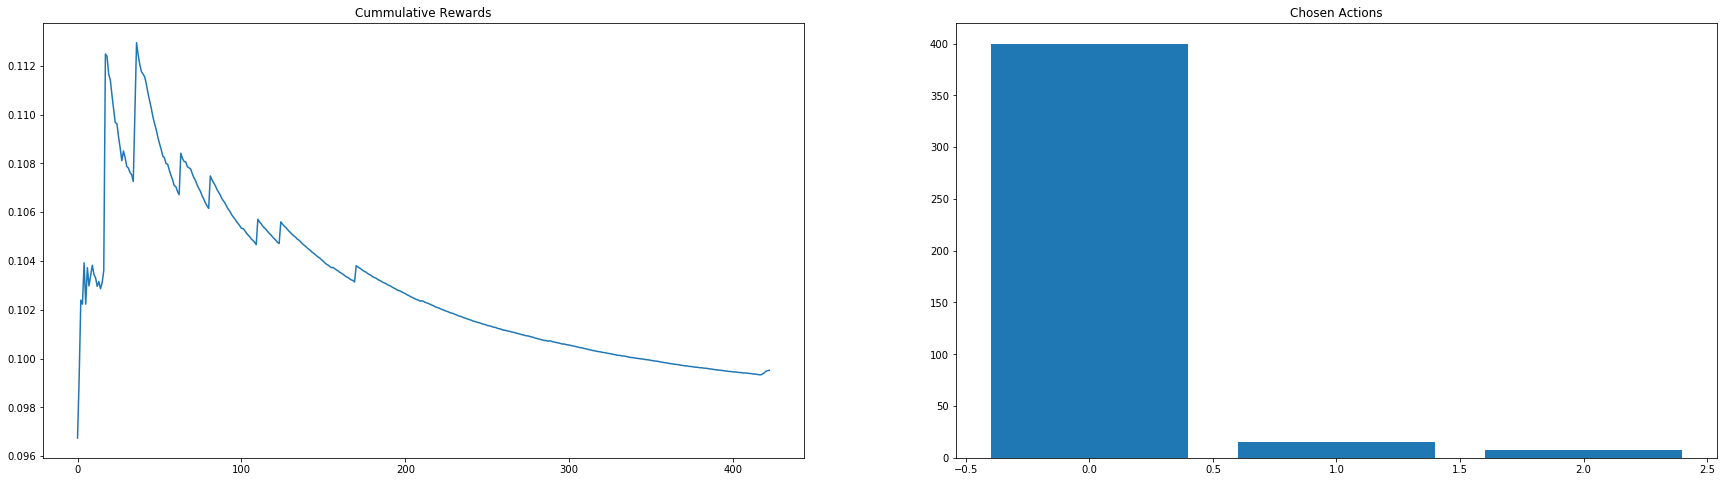

Iteration 1004
Average rewards per algo {'quick_sort': 0.08016097829455421, 'merge_sort': 0.02873096524215326, 'heap_sort': 0.2282292048136393}
Count per chosen algo {'quick_sort': 84, 'merge_sort': 492, 'heap_sort': 6}


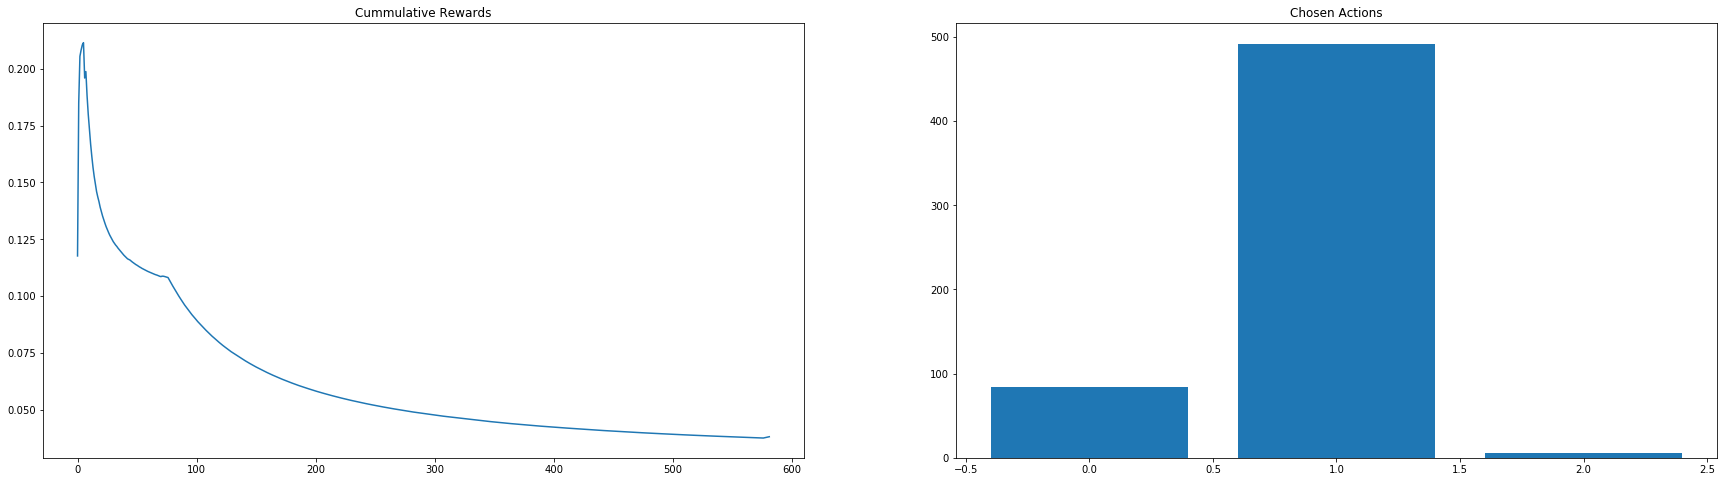

Iteration 1504
Average rewards per algo {'quick_sort': 0.09548240205261604, 'merge_sort': 0.10509702563285828, 'heap_sort': 0.2160961627960205}
Count per chosen algo {'quick_sort': 489, 'merge_sort': 8, 'heap_sort': 3}


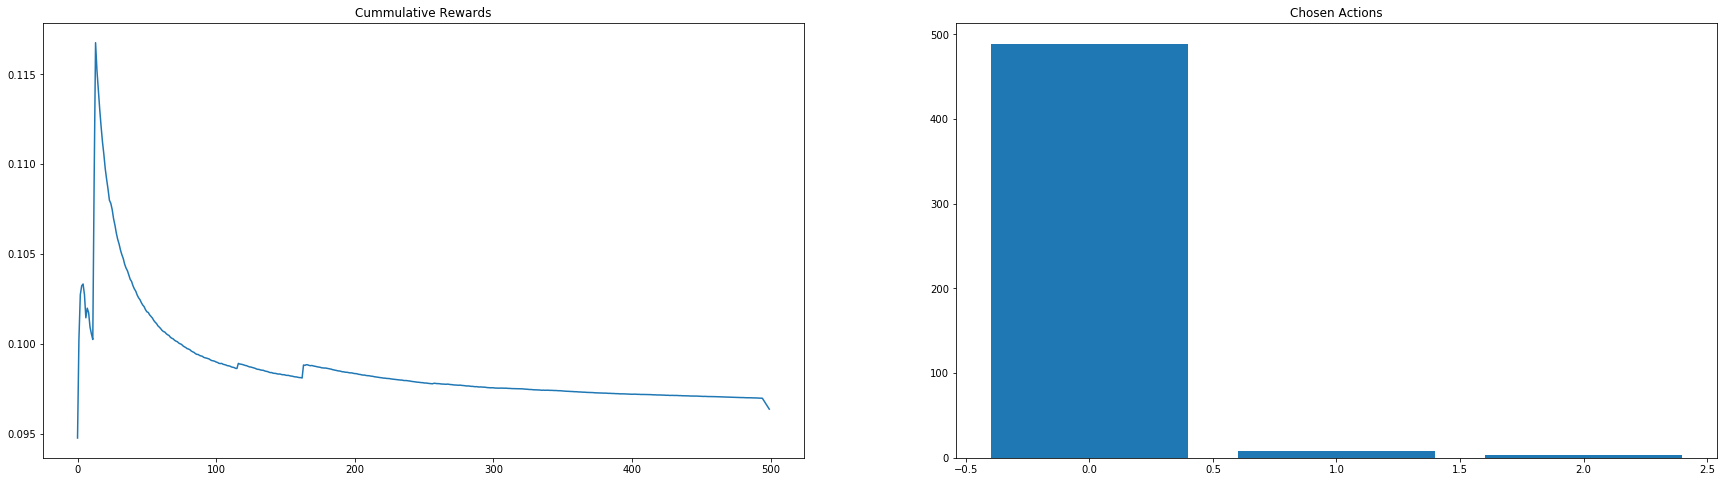

Iteration 1780
Average rewards per algo {'quick_sort': 0.035931727465461284, 'merge_sort': 0.0270703245171517, 'heap_sort': 0.06981408596038818}
Count per chosen algo {'quick_sort': 51, 'merge_sort': 223, 'heap_sort': 2}


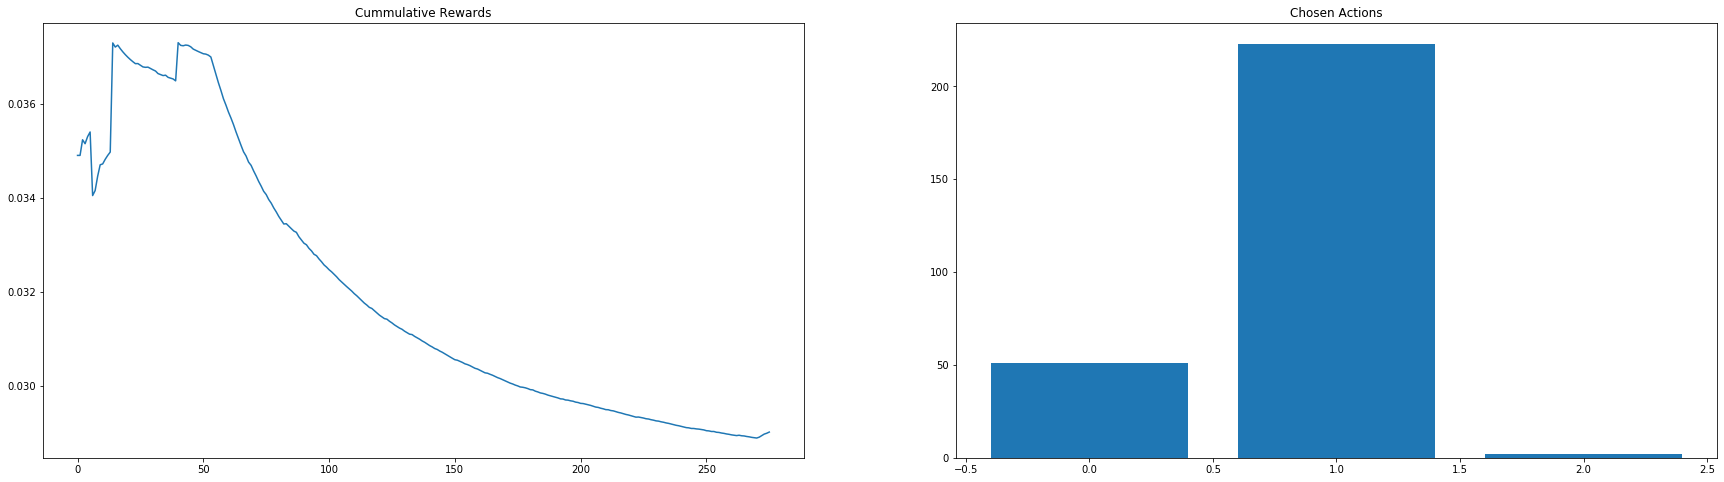

Iteration 1999
Average rewards per algo {'quick_sort': 0.03690319061279297, 'merge_sort': 0.02692060910382317, 'heap_sort': 0.07147701581319173}
Count per chosen algo {'quick_sort': 10, 'merge_sort': 206, 'heap_sort': 3}


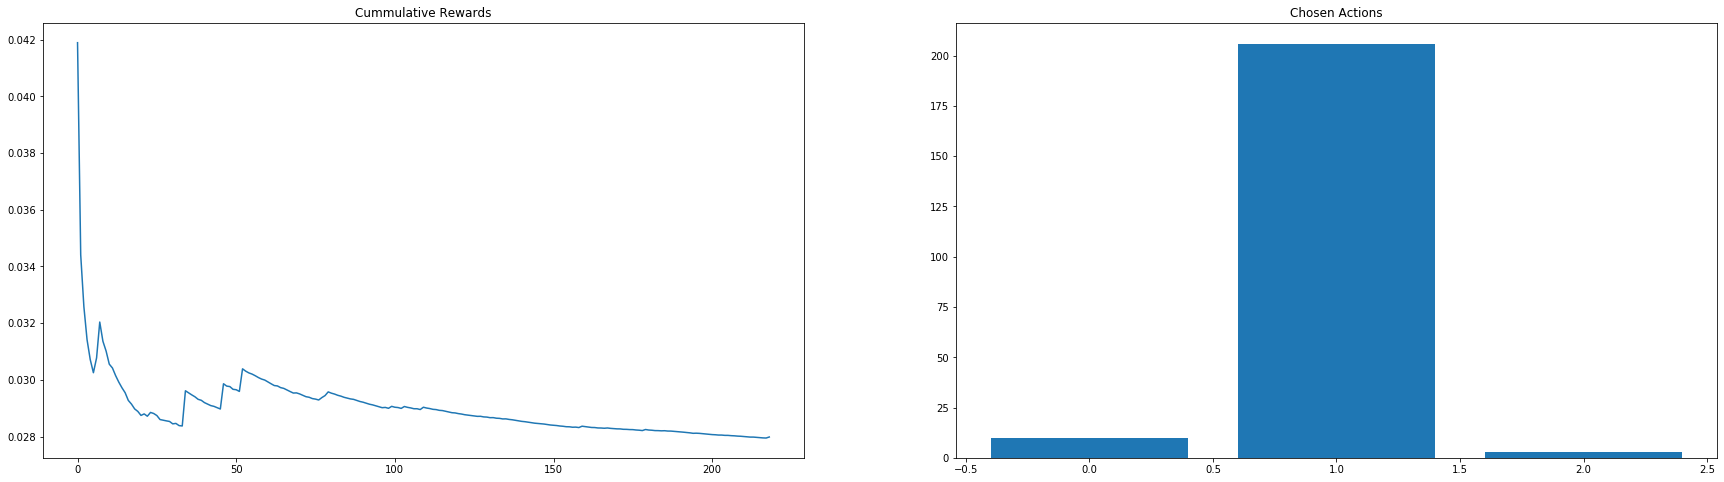

Total reward 126.6531


In [12]:
for elem in list_iteration_results_TS_ttest:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Iteration", n)
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_TS_ttest,4))

### Second Variant: Change point detection 

## Offline changepoint detection - not adjustable to out case but works properly

In [13]:
list_iteration_results_TS_stationary, total_reward_TS_stationary = TS_stationary(list_distributions=list_distributions, n_samples=n_samples)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.7566715664859044
Less than two values for merge_sort
merge_sort Theta 0.7153406882992369
Less than two values for heap_sort
heap_sort Theta 0.9228205044419764


Chosen algorithm is:  merge_sort with reward: 0.11070632934570312
Sample mean is:  0.11070632934570312 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.5863684371646258
Less than two values for merge_sort
merge_sort Theta 0.8396239334308878
Less than two values for heap_sort
heap_sort Theta 0.0006337984656519247


Chosen algorithm is:  heap_sort with reward: 0.2443532943725586
Sample mean is:  0.2443532943725586 Sample variance is: 0.0


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.9937165312025248
Less than two values for merge_sort
merge_sort Theta 0.049470628927669735
Less than two values for heap_sort
heap_sort Theta 0.6814356719509386


Chosen algorithm is:  merge_sort with reward: 0.111



Chosen algorithm is:  quick_sort with reward: 0.09774160385131836
Sample mean is:  0.09603169986179896 Sample variance is: 3.0429134674667867e-06


Iteration: 29
quick_sort Theta 0.09371585605851547
merge_sort Theta 0.10539735158132746
heap_sort Theta 0.27239305457269286


Chosen algorithm is:  quick_sort with reward: 0.09474825859069824
Sample mean is:  0.09594613711039225 Sample variance is: 2.9425463516316895e-06


Iteration: 30
quick_sort Theta 0.09549020036095099
merge_sort Theta 0.10258804397710339
heap_sort Theta 0.30710599200057953


Chosen algorithm is:  quick_sort with reward: 0.09873771667480469
Sample mean is:  0.09612061083316803 Sample variance is: 3.21525340374329e-06


Iteration: 31
quick_sort Theta 0.09251625204644844
merge_sort Theta 0.09641607982227987
heap_sort Theta 0.1487194849465657


Chosen algorithm is:  quick_sort with reward: 0.09475064277648926
Sample mean is:  0.0960400244768928 Sample variance is: 3.130027423665392e-06


Iteration: 32
quick_sort Theta 0.

merge_sort Theta 0.10063938950785901
heap_sort Theta 0.1649757944045191


Chosen algorithm is:  quick_sort with reward: 0.09674263000488281
Sample mean is:  0.09590508179231123 Sample variance is: 3.0257359391915236e-06


Iteration: 61
quick_sort Theta 0.09557034745138857
merge_sort Theta 0.11120791886406431
heap_sort Theta 0.1990768133669388


Chosen algorithm is:  quick_sort with reward: 0.09774088859558105
Sample mean is:  0.09594587749905056 Sample variance is: 3.031726109052945e-06


Iteration: 62
quick_sort Theta 0.09540543928683186
merge_sort Theta 0.113772744557384
heap_sort Theta 0.15216607052577757


Chosen algorithm is:  quick_sort with reward: 0.09375143051147461
Sample mean is:  0.09589817212975543 Sample variance is: 3.0682301214070184e-06


Iteration: 63
quick_sort Theta 0.09514467736796897
merge_sort Theta 0.10718840783783247
heap_sort Theta 0.23102483855541478


Chosen algorithm is:  quick_sort with reward: 0.0957486629486084
Sample mean is:  0.09589499108334805 Sample



Chosen algorithm is:  quick_sort with reward: 0.09674191474914551
Sample mean is:  0.09592622187402514 Sample variance is: 2.716323019539787e-06


Iteration: 91
quick_sort Theta 0.09542364342496659
merge_sort Theta 0.10986380956358094
heap_sort Theta 0.2819638473026568


Chosen algorithm is:  quick_sort with reward: 0.0937509536743164
Sample mean is:  0.09589642367950857 Sample variance is: 2.743044247706686e-06


Iteration: 92
quick_sort Theta 0.09641578795427938
merge_sort Theta 0.09784093253679652
heap_sort Theta 0.22751709101939455


Chosen algorithm is:  quick_sort with reward: 0.09674263000488281
Sample mean is:  0.09590785890012174 Sample variance is: 2.7155218739415747e-06


Iteration: 93
quick_sort Theta 0.096176430393354
merge_sort Theta 0.09597963887425762
heap_sort Theta 0.18825194475027252


Chosen algorithm is:  merge_sort with reward: 0.10671615600585938
Sample mean is:  0.1072080135345459 Sample variance is: 2.1950885717103574e-05


Iteration: 94
quick_sort Theta 0.09

Iteration: 122
quick_sort Theta 0.09624013290663949
merge_sort Theta 0.10163323957395007
heap_sort Theta 0.15573987464137345


Chosen algorithm is:  quick_sort with reward: 0.09674239158630371
Sample mean is:  0.09584385507247027 Sample variance is: 2.740281179961333e-06


Iteration: 123
quick_sort Theta 0.0957712684836308
merge_sort Theta 0.1125919700950319
heap_sort Theta 0.1406586723956907


Chosen algorithm is:  quick_sort with reward: 0.09973502159118652
Sample mean is:  0.09588163338818596 Sample variance is: 2.8592510244193005e-06


Iteration: 124
quick_sort Theta 0.09611105802669584
merge_sort Theta 0.11322689709130711
heap_sort Theta 0.27715152176587976


Chosen algorithm is:  quick_sort with reward: 0.09474802017211914
Sample mean is:  0.0958707332611084 Sample variance is: 2.843995941449206e-06


Iteration: 125
quick_sort Theta 0.0962454029867013
merge_sort Theta 0.10285403740570966
heap_sort Theta 0.20744031322812065


Chosen algorithm is:  quick_sort with reward: 0.0987393

quick_sort Theta 0.0963159482019964
merge_sort Theta 0.10812865601702684
heap_sort Theta 0.2509876693150142


Chosen algorithm is:  quick_sort with reward: 0.09674572944641113
Sample mean is:  0.09590467900940866 Sample variance is: 2.8307938710143686e-06


Iteration: 153
quick_sort Theta 0.09548348884589651
merge_sort Theta 0.10402974409780413
heap_sort Theta 0.1480430060573995


Chosen algorithm is:  quick_sort with reward: 0.09674286842346191
Sample mean is:  0.09591098118545417 Sample variance is: 2.814752406394592e-06


Iteration: 154
quick_sort Theta 0.0956193333174127
merge_sort Theta 0.11806481401154979
heap_sort Theta 0.17255939931002728


Chosen algorithm is:  quick_sort with reward: 0.09474825859069824
Sample mean is:  0.09590230415116495 Sample variance is: 2.8037604843209937e-06


Iteration: 155
quick_sort Theta 0.0961926848703598
merge_sort Theta 0.0976207274672766
heap_sort Theta 0.2618997381979136


Chosen algorithm is:  quick_sort with reward: 0.09574532508850098
Sampl



Chosen algorithm is:  quick_sort with reward: 0.09574651718139648
Sample mean is:  0.09586982993605714 Sample variance is: 2.7774146974267387e-06


Iteration: 183
quick_sort Theta 0.09664369342943341
merge_sort Theta 0.09925562448278558
heap_sort Theta 0.23586776420102973


Chosen algorithm is:  quick_sort with reward: 0.09474802017211914
Sample mean is:  0.0958629051844279 Sample variance is: 2.7679904640628458e-06


Iteration: 184
quick_sort Theta 0.09686684604005959
merge_sort Theta 0.10211140901766354
heap_sort Theta 0.2634694473704878


Chosen algorithm is:  quick_sort with reward: 0.09574580192565918
Sample mean is:  0.09586218675952747 Sample variance is: 2.7510925412361856e-06


Iteration: 185
quick_sort Theta 0.09469035373985496
merge_sort Theta 0.1078103148021701
heap_sort Theta 0.2167440495914043


Chosen algorithm is:  quick_sort with reward: 0.0937509536743164
Sample mean is:  0.09584931338705667 Sample variance is: 2.7613305528762776e-06


Iteration: 186
quick_sort Thet



Chosen algorithm is:  quick_sort with reward: 0.10073232650756836
Sample mean is:  0.09604198733965556 Sample variance is: 5.430275763767471e-06


Iteration: 214
quick_sort Theta 0.09628878829800017
merge_sort Theta 0.10427442067953453
heap_sort Theta 0.24618930908829387


Chosen algorithm is:  quick_sort with reward: 0.09275364875793457
Sample mean is:  0.09602494931591607 Sample variance is: 5.45787611647964e-06


Iteration: 215
quick_sort Theta 0.09571294863843177
merge_sort Theta 0.10189532131058138
heap_sort Theta 0.20912104287687575


Chosen algorithm is:  quick_sort with reward: 0.09774231910705566
Sample mean is:  0.09603380173751988 Sample variance is: 5.444867250508497e-06


Iteration: 216
quick_sort Theta 0.09579271296613145
merge_sort Theta 0.10323647164662825
heap_sort Theta 0.20959336048856722


Chosen algorithm is:  quick_sort with reward: 0.09474611282348633
Sample mean is:  0.0960271982046274 Sample variance is: 5.425404543804484e-06


Iteration: 217
quick_sort Theta



Chosen algorithm is:  quick_sort with reward: 0.09674239158630371
Sample mean is:  0.09603971881525857 Sample variance is: 5.109818713384809e-06


Iteration: 246
quick_sort Theta 0.09756990006703535
merge_sort Theta 0.10581415623561378
heap_sort Theta 0.27360468709578845


Chosen algorithm is:  quick_sort with reward: 0.09474849700927734
Sample mean is:  0.09603398005167643 Sample variance is: 5.094485491261163e-06


Iteration: 247
quick_sort Theta 0.09630703122604194
merge_sort Theta 0.11598118397512655
heap_sort Theta 0.2096189205508274


Chosen algorithm is:  quick_sort with reward: 0.09774231910705566
Sample mean is:  0.09604153907404536 Sample variance is: 5.084799754375056e-06


Iteration: 248
quick_sort Theta 0.09686709330197142
merge_sort Theta 0.1114374722253724
heap_sort Theta 0.20113212340398218


Chosen algorithm is:  quick_sort with reward: 0.09674215316772461
Sample mean is:  0.09604462547974439 Sample variance is: 5.064552608888515e-06


Iteration: 249
quick_sort Theta



Chosen algorithm is:  quick_sort with reward: 0.09574604034423828
Sample mean is:  0.09604150975645766 Sample variance is: 4.8395999321600015e-06


Iteration: 277
quick_sort Theta 0.09522021792581305
merge_sort Theta 0.10903292826983965
heap_sort Theta 0.20198906305276643


Chosen algorithm is:  quick_sort with reward: 0.09474825859069824
Sample mean is:  0.096036418216435 Sample variance is: 4.827105105410035e-06


Iteration: 278
quick_sort Theta 0.09646336642732077
merge_sort Theta 0.11227513068759101
heap_sort Theta 0.21798236241707386


Chosen algorithm is:  quick_sort with reward: 0.0957479476928711
Sample mean is:  0.09603528695947984 Sample variance is: 4.80850033601109e-06


Iteration: 279
quick_sort Theta 0.09516377160036676
merge_sort Theta 0.09457697700826787
heap_sort Theta 0.22912931410279944


Chosen algorithm is:  merge_sort with reward: 0.10671663284301758
Sample mean is:  0.10686029195785522 Sample variance is: 1.8777630273660858e-05


Iteration: 280
quick_sort Theta

heap_sort Theta 0.23703678885234636


Chosen algorithm is:  quick_sort with reward: 0.09574556350708008
Sample mean is:  0.0959792821965319 Sample variance is: 4.559886254202072e-06


Iteration: 308
quick_sort Theta 0.09608952657952724
merge_sort Theta 0.10962053849169251
heap_sort Theta 0.21444987244732014


Chosen algorithm is:  quick_sort with reward: 0.09774184226989746
Sample mean is:  0.09598551032399963 Sample variance is: 4.554712241160425e-06


Iteration: 309
quick_sort Theta 0.09738905579119936
merge_sort Theta 0.09731319646117595
heap_sort Theta 0.20362122795355142


Chosen algorithm is:  merge_sort with reward: 0.10372614860534668
Sample mean is:  0.10671131177382036 Sample variance is: 1.7495806246737935e-05


Iteration: 310
quick_sort Theta 0.09555308433675182
merge_sort Theta 0.1041558391954712
heap_sort Theta 0.3200666522547559


Chosen algorithm is:  quick_sort with reward: 0.09574460983276367
Sample mean is:  0.09598466208283331 Sample variance is: 4.538878144201985e-



Chosen algorithm is:  quick_sort with reward: 0.0967416763305664
Sample mean is:  0.09598000486564023 Sample variance is: 4.414054854496749e-06


Iteration: 338
quick_sort Theta 0.09568812955922178
merge_sort Theta 0.10246549626250925
heap_sort Theta 0.22962057281559575


Chosen algorithm is:  quick_sort with reward: 0.09574007987976074
Sample mean is:  0.09597923587530087 Sample variance is: 4.400091151433789e-06


Iteration: 339
quick_sort Theta 0.09653406606764288
merge_sort Theta 0.10672323098946122
heap_sort Theta 0.224208013866354


Chosen algorithm is:  quick_sort with reward: 0.09574580192565918
Sample mean is:  0.0959784900799346 Sample variance is: 4.386206889975173e-06


Iteration: 340
quick_sort Theta 0.09632567723574616
merge_sort Theta 0.11166610477300083
heap_sort Theta 0.2030466137133763


Chosen algorithm is:  quick_sort with reward: 0.09474802017211914
Sample mean is:  0.09597457138596067 Sample variance is: 4.377044557074063e-06


Iteration: 341
quick_sort Theta 0.

quick_sort Theta 0.09586310665179804
merge_sort Theta 0.11432848969861546
heap_sort Theta 0.2771328494346348


Chosen algorithm is:  quick_sort with reward: 0.09574770927429199
Sample mean is:  0.09594688401625386 Sample variance is: 4.219238589601681e-06


Iteration: 370
quick_sort Theta 0.09562725038273283
merge_sort Theta 0.10370658847374771
heap_sort Theta 0.2205287033012157


Chosen algorithm is:  quick_sort with reward: 0.09773969650268555
Sample mean is:  0.09595209568045861 Sample variance is: 4.216289736361107e-06


Iteration: 371
quick_sort Theta 0.09568529749878109
merge_sort Theta 0.1108619707422716
heap_sort Theta 0.21262469128349226


Chosen algorithm is:  quick_sort with reward: 0.09375
Sample mean is:  0.09594571279442829 Sample variance is: 4.218083591212635e-06


Iteration: 372
quick_sort Theta 0.09545342344637626
merge_sort Theta 0.09678692976353775
heap_sort Theta 0.20351875723386886


Chosen algorithm is:  quick_sort with reward: 0.09674596786499023
Sample mean is:



Chosen algorithm is:  quick_sort with reward: 0.09774017333984375
Sample mean is:  0.09594191210244292 Sample variance is: 4.135083164822265e-06


Iteration: 400
quick_sort Theta 0.09582635910917986
merge_sort Theta 0.11418997627519899
heap_sort Theta 0.20281585633530075


Chosen algorithm is:  quick_sort with reward: 0.0937507152557373
Sample mean is:  0.09593603758006569 Sample variance is: 4.136834875871278e-06


Iteration: 401
quick_sort Theta 0.09563225868939695
merge_sort Theta 0.10462403532499147
heap_sort Theta 0.20349510736113657


Chosen algorithm is:  quick_sort with reward: 0.09774017333984375
Sample mean is:  0.09594086147247151 Sample variance is: 4.134453506906166e-06


Iteration: 402
quick_sort Theta 0.09606394779028017
merge_sort Theta 0.1143233401973735
heap_sort Theta 0.19165052087494802


Chosen algorithm is:  quick_sort with reward: 0.0937497615814209
Sample mean is:  0.09593501853942871 Sample variance is: 4.13619660764137e-06


Iteration: 403
quick_sort Theta 0



Chosen algorithm is:  quick_sort with reward: 0.09674572944641113
Sample mean is:  0.09594169384788342 Sample variance is: 4.026492589402576e-06


Iteration: 431
quick_sort Theta 0.09552915456268565
merge_sort Theta 0.10700981912288417
heap_sort Theta 0.19680742929506928


Chosen algorithm is:  quick_sort with reward: 0.09375
Sample mean is:  0.09593626886311143 Sample variance is: 4.028386498877075e-06


Iteration: 432
quick_sort Theta 0.09566700743282382
merge_sort Theta 0.10718333001639879
heap_sort Theta 0.24644266628737618


Chosen algorithm is:  quick_sort with reward: 0.0987389087677002
Sample mean is:  0.0959431889616413 Sample variance is: 4.037786522066292e-06


Iteration: 433
quick_sort Theta 0.0955889343024679
merge_sort Theta 0.10575695304514748
heap_sort Theta 0.255836565133445


Chosen algorithm is:  quick_sort with reward: 0.09474635124206543
Sample mean is:  0.0959402410854847 Sample variance is: 4.03136067446914e-06


Iteration: 434
quick_sort Theta 0.09592913411128



Chosen algorithm is:  quick_sort with reward: 0.09973573684692383
Sample mean is:  0.09594148699589039 Sample variance is: 3.956359593321449e-06


Iteration: 462
quick_sort Theta 0.0955253852482044
merge_sort Theta 0.10768932826683456
heap_sort Theta 0.12370415944233484


Chosen algorithm is:  quick_sort with reward: 0.0937492847442627
Sample mean is:  0.09593644745048435 Sample variance is: 3.958286819564976e-06


Iteration: 463
quick_sort Theta 0.09542551995249678
merge_sort Theta 0.10698845211785486
heap_sort Theta 0.2228244127050461


Chosen algorithm is:  quick_sort with reward: 0.12367105484008789
Sample mean is:  0.09600005893532289 Sample variance is: 5.709401316533828e-06


Iteration: 464
quick_sort Theta 0.09618846323713955
merge_sort Theta 0.11011083333913453
heap_sort Theta 0.2052780424878382


Chosen algorithm is:  quick_sort with reward: 0.09674596786499023
Sample mean is:  0.09600176582074547 Sample variance is: 5.6976065925835876e-06


Iteration: 465
quick_sort Theta 

heap_sort Theta 0.23892378220188543


Chosen algorithm is:  quick_sort with reward: 0.09674477577209473
Sample mean is:  0.09598796920203344 Sample variance is: 5.53583692652292e-06


Iteration: 494
quick_sort Theta 0.09604808613773028
merge_sort Theta 0.11345501322571644
heap_sort Theta 0.2623695282874346


Chosen algorithm is:  quick_sort with reward: 0.09774017333984375
Sample mean is:  0.09599172124515509 Sample variance is: 5.530543153650443e-06


Iteration: 495
quick_sort Theta 0.09588498609829724
merge_sort Theta 0.10645431176290011
heap_sort Theta 0.20266353733508857


Chosen algorithm is:  quick_sort with reward: 0.09375
Sample mean is:  0.09598693124249451 Sample variance is: 5.529440660352581e-06


Iteration: 496
quick_sort Theta 0.0957934427724928
merge_sort Theta 0.11347454162993771
heap_sort Theta 0.23295466735716455


Chosen algorithm is:  quick_sort with reward: 0.09574556350708008
Sample mean is:  0.09598641659913541 Sample variance is: 5.517774761642655e-06


Iteratio



Iteration: 524
quick_sort Theta 0.09347123470774016
merge_sort Theta 0.10504200680993855
heap_sort Theta 0.22563811049197421


Chosen algorithm is:  quick_sort with reward: 0.031914472579956055
Sample mean is:  0.09277802885658065 Sample variance is: 0.00019990738175848445


Iteration: 525
quick_sort Theta 0.09669362695588908
merge_sort Theta 0.09756912249291902
heap_sort Theta 0.1716094001941218


Chosen algorithm is:  quick_sort with reward: 0.030916929244995117
Sample mean is:  0.09265380978105538 Sample variance is: 0.00020717485953918992


Iteration: 526
quick_sort Theta 0.09071743528358402
merge_sort Theta 0.10097397637439459
heap_sort Theta 0.2183198638805463


Chosen algorithm is:  quick_sort with reward: 0.03191494941711426
Sample mean is:  0.09253208861800138 Sample variance is: 0.00021413806814449062


Iteration: 527
quick_sort Theta 0.0905901952587475
merge_sort Theta 0.1005151116810948
heap_sort Theta 0.24644626119183216


Chosen algorithm is:  quick_sort with reward: 0.



Iteration: 554
quick_sort Theta 0.0927948939574663
merge_sort Theta 0.11105958108591137
heap_sort Theta 0.23000027055323602


Chosen algorithm is:  quick_sort with reward: 0.03191685676574707
Sample mean is:  0.08931335959534038 Sample variance is: 0.000387415247501951


Iteration: 555
quick_sort Theta 0.09031427690310234
merge_sort Theta 0.10395485580695546
heap_sort Theta 0.23813265100245082


Chosen algorithm is:  quick_sort with reward: 0.031914710998535156
Sample mean is:  0.08920465003360402 Sample variance is: 0.00039290947066730026


Iteration: 556
quick_sort Theta 0.0899062259846722
merge_sort Theta 0.10500722195137241
heap_sort Theta 0.2069306396402283


Chosen algorithm is:  quick_sort with reward: 0.03191542625427246
Sample mean is:  0.08909635282419129 Sample variance is: 0.00039835926542629145


Iteration: 557
quick_sort Theta 0.08863939506202151
merge_sort Theta 0.10222671547652819
heap_sort Theta 0.23138628159865957


Chosen algorithm is:  quick_sort with reward: 0.03



Iteration: 584
quick_sort Theta 0.09040040348733948
merge_sort Theta 0.10418843221980774
heap_sort Theta 0.20671761924203316


Chosen algorithm is:  quick_sort with reward: 0.04188847541809082
Sample mean is:  0.0864654691685894 Sample variance is: 0.000510351203772355


Iteration: 585
quick_sort Theta 0.09329564867057517
merge_sort Theta 0.11948502023221934
heap_sort Theta 0.25725757453311643


Chosen algorithm is:  quick_sort with reward: 0.0438845157623291
Sample mean is:  0.08638915921624843 Sample variance is: 0.0005126801231965282


Iteration: 586
quick_sort Theta 0.08525731107876044
merge_sort Theta 0.10941771285696619
heap_sort Theta 0.22809058075380825


Chosen algorithm is:  quick_sort with reward: 0.03390789031982422
Sample mean is:  0.08629527501428703 Sample variance is: 0.0005166813330350504


Iteration: 587
quick_sort Theta 0.08921702351850036
merge_sort Theta 0.10634558945912367
heap_sort Theta 0.21110967620063864


Chosen algorithm is:  quick_sort with reward: 0.0339



Iteration: 614
quick_sort Theta 0.08193158995647196
merge_sort Theta 0.10433850967823528
heap_sort Theta 0.13802454940852532


Chosen algorithm is:  quick_sort with reward: 0.03291821479797363
Sample mean is:  0.08383664402482457 Sample variance is: 0.0006130181729549663


Iteration: 615
quick_sort Theta 0.08280305541323436
merge_sort Theta 0.11479615321463105
heap_sort Theta 0.18247193051030786


Chosen algorithm is:  quick_sort with reward: 0.035904645919799805
Sample mean is:  0.08375512702124459 Sample variance is: 0.0006158762528810277


Iteration: 616
quick_sort Theta 0.07881450036392387
merge_sort Theta 0.11066020887645742
heap_sort Theta 0.2519117651397723


Chosen algorithm is:  quick_sort with reward: 0.03191399574279785
Sample mean is:  0.08366711151822516 Sample variance is: 0.0006193856990883307


Iteration: 617
quick_sort Theta 0.09846601474687498
merge_sort Theta 0.11291754427748618
heap_sort Theta 0.22246175432877796


Chosen algorithm is:  quick_sort with reward: 0.0



Iteration: 644
quick_sort Theta 0.0828373341541578
merge_sort Theta 0.10736121968072798
heap_sort Theta 0.25111501537685665


Chosen algorithm is:  quick_sort with reward: 0.03291177749633789
Sample mean is:  0.0814284571179308 Sample variance is: 0.0006970780711965289


Iteration: 645
quick_sort Theta 0.08650446025617077
merge_sort Theta 0.11467961902319812
heap_sort Theta 0.23236443908925702


Chosen algorithm is:  quick_sort with reward: 0.031914710998535156
Sample mean is:  0.08134833778764052 Sample variance is: 0.0006999107022246845


Iteration: 646
quick_sort Theta 0.07471284528643687
merge_sort Theta 0.1122070525950633
heap_sort Theta 0.22250924407953426


Chosen algorithm is:  quick_sort with reward: 0.03390789031982422
Sample mean is:  0.08127169732323371 Sample variance is: 0.0007024099744311406


Iteration: 647
quick_sort Theta 0.06989970110408336
merge_sort Theta 0.10304675346221322
heap_sort Theta 0.234571687772834


Chosen algorithm is:  quick_sort with reward: 0.03589



Iteration: 675
quick_sort Theta 0.08135397175980398
merge_sort Theta 0.10821556432310088
heap_sort Theta 0.2450959160208147


Chosen algorithm is:  quick_sort with reward: 0.04089045524597168
Sample mean is:  0.07916602308367506 Sample variance is: 0.0007659991279324706


Iteration: 676
quick_sort Theta 0.08940644748605252
merge_sort Theta 0.10749018550949586
heap_sort Theta 0.21777878307278445


Chosen algorithm is:  quick_sort with reward: 0.04188656806945801
Sample mean is:  0.07910858170460847 Sample variance is: 0.0007669569357212499


Iteration: 677
quick_sort Theta 0.08380611244707574
merge_sort Theta 0.10024201697544717
heap_sort Theta 0.26652481873890715


Chosen algorithm is:  quick_sort with reward: 0.03391146659851074
Sample mean is:  0.07903904768136831 Sample variance is: 0.0007689149042457735


Iteration: 678
quick_sort Theta 0.09011857527530805
merge_sort Theta 0.11135597381600118
heap_sort Theta 0.23923545909443214


Chosen algorithm is:  quick_sort with reward: 0.03



Iteration: 706
quick_sort Theta 0.08425279352251791
merge_sort Theta 0.1027219876871105
heap_sort Theta 0.2152586343503215


Chosen algorithm is:  quick_sort with reward: 0.03191328048706055
Sample mean is:  0.07707924730472256 Sample variance is: 0.0008222840343391365


Iteration: 707
quick_sort Theta 0.08260163283740338
merge_sort Theta 0.10456644854413971
heap_sort Theta 0.24597611119439752


Chosen algorithm is:  quick_sort with reward: 0.03391098976135254
Sample mean is:  0.07701576457304113 Sample variance is: 0.0008238112019657261


Iteration: 708
quick_sort Theta 0.07513888791867514
merge_sort Theta 0.10915951675169933
heap_sort Theta 0.18949667133254203


Chosen algorithm is:  quick_sort with reward: 0.036899566650390625
Sample mean is:  0.07695685679341903 Sample variance is: 0.0008249611799064854


Iteration: 709
quick_sort Theta 0.07771036579037038
merge_sort Theta 0.10297332685952267
heap_sort Theta 0.2669578414265217


Chosen algorithm is:  quick_sort with reward: 0.032



Iteration: 736
quick_sort Theta 0.06714181126510929
merge_sort Theta 0.10050847853842193
heap_sort Theta 0.2319628640748623


Chosen algorithm is:  quick_sort with reward: 0.03690147399902344
Sample mean is:  0.07521321306107578 Sample variance is: 0.0008664896502073732


Iteration: 737
quick_sort Theta 0.07162921516161352
merge_sort Theta 0.10964466201708134
heap_sort Theta 0.226409380156519


Chosen algorithm is:  quick_sort with reward: 0.03390955924987793
Sample mean is:  0.07515503890077832 Sample variance is: 0.0008676686633940918


Iteration: 738
quick_sort Theta 0.06874743074146522
merge_sort Theta 0.11175628588911726
heap_sort Theta 0.1916675300202879


Chosen algorithm is:  quick_sort with reward: 0.03390955924987793
Sample mean is:  0.07509702838087551 Sample variance is: 0.0008688376201543176


Iteration: 739
quick_sort Theta 0.0675675609786461
merge_sort Theta 0.1018350815193639
heap_sort Theta 0.21389640056717268


Chosen algorithm is:  quick_sort with reward: 0.0369019



Iteration: 767
quick_sort Theta 0.0800616671330941
merge_sort Theta 0.10800892448727391
heap_sort Theta 0.22871179357580668


Chosen algorithm is:  quick_sort with reward: 0.03390955924987793
Sample mean is:  0.07351729708748894 Sample variance is: 0.0008962304560268058


Iteration: 768
quick_sort Theta 0.07454012916192525
merge_sort Theta 0.10910368001818786
heap_sort Theta 0.20723120574540244


Chosen algorithm is:  quick_sort with reward: 0.03490924835205078
Sample mean is:  0.07346519445761657 Sample variance is: 0.0008970298344212159


Iteration: 769
quick_sort Theta 0.08438848089923968
merge_sort Theta 0.10211140772985221
heap_sort Theta 0.263907019841749


Chosen algorithm is:  quick_sort with reward: 0.04188895225524902
Sample mean is:  0.07342263887513359 Sample variance is: 0.0008971628337363397


Iteration: 770
quick_sort Theta 0.07692883692175596
merge_sort Theta 0.11357088779137403
heap_sort Theta 0.18905046843453258


Chosen algorithm is:  quick_sort with reward: 0.0319


Chosen algorithm is:  quick_sort with reward: 0.03790020942687988
Sample mean is:  0.0720259663346526 Sample variance is: 0.0009163699903849174


Iteration: 798
quick_sort Theta 0.06717178619164262
merge_sort Theta 0.10276239693426609
heap_sort Theta 0.22027756182990832


Chosen algorithm is:  quick_sort with reward: 0.0329127311706543
Sample mean is:  0.07197523580914805 Sample variance is: 0.0009171631044441069


Iteration: 799
quick_sort Theta 0.0728188362236582
merge_sort Theta 0.10772070464314314
heap_sort Theta 0.19749546600450546


Chosen algorithm is:  quick_sort with reward: 0.03889131546020508
Sample mean is:  0.0719323809900432 Sample variance is: 0.0009173910382210363


Iteration: 800
quick_sort Theta 0.0670864618477395
merge_sort Theta 0.10917885895327904
heap_sort Theta 0.24777406980308658


Chosen algorithm is:  quick_sort with reward: 0.03390932083129883
Sample mean is:  0.0718831920377033 Sample variance is: 0.0009180721400982942


Iteration: 801
quick_sort Theta 0.07



Iteration: 829
quick_sort Theta 0.06703911422368637
merge_sort Theta 0.1057277001744378
heap_sort Theta 0.22476687925005223


Chosen algorithm is:  quick_sort with reward: 0.03390955924987793
Sample mean is:  0.07050014047551334 Sample variance is: 0.0009359508963762878


Iteration: 830
quick_sort Theta 0.06575653043565427
merge_sort Theta 0.11139145432485882
heap_sort Theta 0.2876596795379884


Chosen algorithm is:  quick_sort with reward: 0.03191399574279785
Sample mean is:  0.07045208799141282 Sample variance is: 0.0009366371796998887


Iteration: 831
quick_sort Theta 0.07276268691933978
merge_sort Theta 0.10688449566042932
heap_sort Theta 0.22923603950614935


Chosen algorithm is:  quick_sort with reward: 0.03191494941711426
Sample mean is:  0.07040415622701693 Sample variance is: 0.0009373170636759435


Iteration: 832
quick_sort Theta 0.07241050065204577
merge_sort Theta 0.11383736766592732
heap_sort Theta 0.22220793576553335


Chosen algorithm is:  quick_sort with reward: 0.032



Iteration: 859
quick_sort Theta 0.06719474759512005
merge_sort Theta 0.10675481169598909
heap_sort Theta 0.2302219189102677


Chosen algorithm is:  quick_sort with reward: 0.03191494941711426
Sample mean is:  0.06914958415123132 Sample variance is: 0.0009510234336517462


Iteration: 860
quick_sort Theta 0.059469474093690966
merge_sort Theta 0.10677390753243234
heap_sort Theta 0.2039283199393287


Chosen algorithm is:  quick_sort with reward: 0.031916141510009766
Sample mean is:  0.0691048861408577 Sample variance is: 0.0009515440117507378


Iteration: 861
quick_sort Theta 0.07362134240174309
merge_sort Theta 0.10538243422947374
heap_sort Theta 0.2359389740418044


Chosen algorithm is:  quick_sort with reward: 0.03690195083618164
Sample mean is:  0.06906627350859791 Sample variance is: 0.0009516450208519222


Iteration: 862
quick_sort Theta 0.05894807958706329
merge_sort Theta 0.10726414422351507
heap_sort Theta 0.18610183665054744


Chosen algorithm is:  quick_sort with reward: 0.033



Iteration: 889
quick_sort Theta 0.08058437109283752
merge_sort Theta 0.10104139898473981
heap_sort Theta 0.24564569031493302


Chosen algorithm is:  quick_sort with reward: 0.03191733360290527
Sample mean is:  0.06792542691020567 Sample variance is: 0.0009596349030283295


Iteration: 890
quick_sort Theta 0.0729695344134644
merge_sort Theta 0.11173893181251811
heap_sort Theta 0.205656663323473


Chosen algorithm is:  quick_sort with reward: 0.031914710998535156
Sample mean is:  0.06788369954530223 Sample variance is: 0.0009600238185847135


Iteration: 891
quick_sort Theta 0.061008330407602784
merge_sort Theta 0.10263151756116778
heap_sort Theta 0.26873919373719585


Chosen algorithm is:  quick_sort with reward: 0.03191518783569336
Sample mean is:  0.0678420693234161 Sample variance is: 0.0009604083239538063


Iteration: 892
quick_sort Theta 0.06217394272787931
merge_sort Theta 0.11051383601015582
heap_sort Theta 0.2719412624527127


Chosen algorithm is:  quick_sort with reward: 0.0369



Iteration: 919
quick_sort Theta 0.0747971356886299
merge_sort Theta 0.10842984288957573
heap_sort Theta 0.26729609325156595


Chosen algorithm is:  quick_sort with reward: 0.032912492752075195
Sample mean is:  0.06678810782496705 Sample variance is: 0.0009646412486769993


Iteration: 920
quick_sort Theta 0.06160212156305587
merge_sort Theta 0.09978338236163917
heap_sort Theta 0.21868239987531218


Chosen algorithm is:  quick_sort with reward: 0.03689217567443848
Sample mean is:  0.06675462973745246 Sample variance is: 0.0009645607611650612


Iteration: 921
quick_sort Theta 0.07041948032911272
merge_sort Theta 0.09951532377710147
heap_sort Theta 0.2474750518955343


Chosen algorithm is:  quick_sort with reward: 0.03490710258483887
Sample mean is:  0.06671900610529069 Sample variance is: 0.0009646150896885273


Iteration: 922
quick_sort Theta 0.06379810240572309
merge_sort Theta 0.10050256686877103
heap_sort Theta 0.23892473560005809


Chosen algorithm is:  quick_sort with reward: 0.03



Iteration: 949
quick_sort Theta 0.06476545970552586
merge_sort Theta 0.10670477365296731
heap_sort Theta 0.23196893772339444


Chosen algorithm is:  quick_sort with reward: 0.03390955924987793
Sample mean is:  0.06567394164534297 Sample variance is: 0.0009702100157627079


Iteration: 950
quick_sort Theta 0.06725909701957856
merge_sort Theta 0.11588852267005703
heap_sort Theta 0.23904128603989247


Chosen algorithm is:  quick_sort with reward: 0.03291201591491699
Sample mean is:  0.06563844660121468 Sample variance is: 0.0009703204934179664


Iteration: 951
quick_sort Theta 0.06974897877715487
merge_sort Theta 0.10047805597914239
heap_sort Theta 0.2291836331481168


Chosen algorithm is:  quick_sort with reward: 0.031914710998535156
Sample mean is:  0.06560194905186112 Sample variance is: 0.0009704998646472704


Iteration: 952
quick_sort Theta 0.06505665803772122
merge_sort Theta 0.10864084625842767
heap_sort Theta 0.1951925475531567


Chosen algorithm is:  quick_sort with reward: 0.03



Iteration: 979
quick_sort Theta 0.06895349098871092
merge_sort Theta 0.10859339683326684
heap_sort Theta 0.22544036658967137


Chosen algorithm is:  quick_sort with reward: 0.0329127311706543
Sample mean is:  0.06463524599035247 Sample variance is: 0.0009728596358691044


Iteration: 980
quick_sort Theta 0.07139810287236856
merge_sort Theta 0.10493685117051414
heap_sort Theta 0.21321753173330277


Chosen algorithm is:  quick_sort with reward: 0.03191351890563965
Sample mean is:  0.06460091049498551 Sample variance is: 0.0009729611345793128


Iteration: 981
quick_sort Theta 0.05396175245836958
merge_sort Theta 0.1091547427726431
heap_sort Theta 0.23293132427969995


Chosen algorithm is:  quick_sort with reward: 0.03391003608703613
Sample mean is:  0.06456873976709458 Sample variance is: 0.0009729275719897696


Iteration: 982
quick_sort Theta 0.06464955394042438
merge_sort Theta 0.1089385693055313
heap_sort Theta 0.2151195558978902


Chosen algorithm is:  quick_sort with reward: 0.03275



Chosen algorithm is:  quick_sort with reward: 0.10073184967041016
Sample mean is:  0.06436673371223714 Sample variance is: 0.000978075111311146


Iteration: 1010
quick_sort Theta 0.06688357132397281
merge_sort Theta 0.10575719610310211
heap_sort Theta 0.23139491695670533


Chosen algorithm is:  quick_sort with reward: 0.09973263740539551
Sample mean is:  0.06440271123379682 Sample variance is: 0.00097835120455139


Iteration: 1011
quick_sort Theta 0.060517950203218984
merge_sort Theta 0.10769030069615175
heap_sort Theta 0.23527861073637643


Chosen algorithm is:  quick_sort with reward: 0.09973502159118652
Sample mean is:  0.0644386180532657 Sample variance is: 0.0009786243267869085


Iteration: 1012
quick_sort Theta 0.06869557867120148
merge_sort Theta 0.11356213173472815
heap_sort Theta 0.19258307635041388


Chosen algorithm is:  quick_sort with reward: 0.1017301082611084
Sample mean is:  0.06447647743418737 Sample variance is: 0.0009790411989517834


Iteration: 1013
quick_sort The



Chosen algorithm is:  quick_sort with reward: 0.09817743301391602
Sample mean is:  0.0654119446343584 Sample variance is: 0.0009854027874070732


Iteration: 1040
quick_sort Theta 0.06439646431161543
merge_sort Theta 0.10841341490771099
heap_sort Theta 0.177673828098689


Chosen algorithm is:  quick_sort with reward: 0.0937507152557373
Sample mean is:  0.06543991972875265 Sample variance is: 0.0009852220276372222


Iteration: 1041
quick_sort Theta 0.06738111957579115
merge_sort Theta 0.11476451761931288
heap_sort Theta 0.19981721893515011


Chosen algorithm is:  quick_sort with reward: 0.09574556350708008
Sample mean is:  0.06546980695141373 Sample variance is: 0.0009851552665579896


Iteration: 1042
quick_sort Theta 0.06071584987653145
merge_sort Theta 0.10272226202061252
heap_sort Theta 0.21897239332010296


Chosen algorithm is:  quick_sort with reward: 0.09773969650268555
Sample mean is:  0.06550159994604553 Sample variance is: 0.0009852096158670222


Iteration: 1043
quick_sort The



Iteration: 1070
quick_sort Theta 0.06501512077756402
merge_sort Theta 0.10574211755939392
heap_sort Theta 0.19666224473557592


Chosen algorithm is:  quick_sort with reward: 0.09773492813110352
Sample mean is:  0.06643781268813809 Sample variance is: 0.0009909767515124367


Iteration: 1071
quick_sort Theta 0.060307257019658604
merge_sort Theta 0.10757469903602351
heap_sort Theta 0.2439698941684615


Chosen algorithm is:  quick_sort with reward: 0.1017301082611084
Sample mean is:  0.06647161756895512 Sample variance is: 0.000991219449140264


Iteration: 1072
quick_sort Theta 0.06934584590064968
merge_sort Theta 0.10152403458278962
heap_sort Theta 0.2608380553041423


Chosen algorithm is:  quick_sort with reward: 0.10671377182006836
Sample mean is:  0.06651012680747292 Sample variance is: 0.0009918191255373107


Iteration: 1073
quick_sort Theta 0.06473163048251801
merge_sort Theta 0.10406187134941272
heap_sort Theta 0.1951168332216611


Chosen algorithm is:  quick_sort with reward: 0.1



Chosen algorithm is:  quick_sort with reward: 0.09773921966552734
Sample mean is:  0.06738498135429964 Sample variance is: 0.0009930904518439972


Iteration: 1102
quick_sort Theta 0.06535766130290205
merge_sort Theta 0.10748399407650899
heap_sort Theta 0.2301818930653796


Chosen algorithm is:  quick_sort with reward: 0.0937502384185791
Sample mean is:  0.06740950717482457 Sample variance is: 0.0009928126748194935


Iteration: 1103
quick_sort Theta 0.06183901523397914
merge_sort Theta 0.10491599461814904
heap_sort Theta 0.18772023848330374


Chosen algorithm is:  quick_sort with reward: 0.09773969650268555
Sample mean is:  0.06743769508312183 Sample variance is: 0.0009927441364972341


Iteration: 1104
quick_sort Theta 0.07143294081927991
merge_sort Theta 0.10284245352067567
heap_sort Theta 0.2349753001268194


Chosen algorithm is:  quick_sort with reward: 0.09674286842346191
Sample mean is:  0.06746490508622335 Sample variance is: 0.0009926190219699852


Iteration: 1105
quick_sort Th



Chosen algorithm is:  quick_sort with reward: 0.09873795509338379
Sample mean is:  0.0681944765906403 Sample variance is: 0.0009897521107987762


Iteration: 1132
quick_sort Theta 0.07385203775128321
merge_sort Theta 0.10350737395586466
heap_sort Theta 0.18791140596590805


Chosen algorithm is:  quick_sort with reward: 0.09574556350708008
Sample mean is:  0.06821940970097193 Sample variance is: 0.0009895427201609378


Iteration: 1133
quick_sort Theta 0.07363549387315019
merge_sort Theta 0.1065624144012769
heap_sort Theta 0.2171086072920923


Chosen algorithm is:  quick_sort with reward: 0.09674286842346191
Sample mean is:  0.06824519944665229 Sample variance is: 0.0009893829637093881


Iteration: 1134
quick_sort Theta 0.06569403643352736
merge_sort Theta 0.1050669311484577
heap_sort Theta 0.22580856372154073


Chosen algorithm is:  quick_sort with reward: 0.09674263000488281
Sample mean is:  0.06827094238301926 Sample variance is: 0.0009892221570040316


Iteration: 1135
quick_sort The



Chosen algorithm is:  quick_sort with reward: 0.09774160385131836
Sample mean is:  0.06895325045106272 Sample variance is: 0.000984833850465658


Iteration: 1162
quick_sort Theta 0.06821097780918793
merge_sort Theta 0.10822531215458583
heap_sort Theta 0.2601532340013703


Chosen algorithm is:  quick_sort with reward: 0.09474754333496094
Sample mean is:  0.06897597670029963 Sample variance is: 0.0009845518464897866


Iteration: 1163
quick_sort Theta 0.07163478668741828
merge_sort Theta 0.12318084351614698
heap_sort Theta 0.1898062421523405


Chosen algorithm is:  quick_sort with reward: 0.09674310684204102
Sample mean is:  0.06900041959655116 Sample variance is: 0.0009843632751524074


Iteration: 1164
quick_sort Theta 0.0748491092847765
merge_sort Theta 0.1023658182851391
heap_sort Theta 0.2994341463549449


Chosen algorithm is:  quick_sort with reward: 0.09474802017211914
Sample mean is:  0.06902306480374164 Sample variance is: 0.0009840800672372772


Iteration: 1165
quick_sort Theta



Chosen algorithm is:  quick_sort with reward: 0.10073256492614746
Sample mean is:  0.06973897479634428 Sample variance is: 0.0009815649003199122


Iteration: 1193
quick_sort Theta 0.07736899942777296
merge_sort Theta 0.10281195730076638
heap_sort Theta 0.20578023293742406


Chosen algorithm is:  quick_sort with reward: 0.09773921966552734
Sample mean is:  0.0697629887284791 Sample variance is: 0.0009813948972465284


Iteration: 1194
quick_sort Theta 0.07183345753262901
merge_sort Theta 0.10773749623135216
heap_sort Theta 0.2109118542283845


Chosen algorithm is:  quick_sort with reward: 0.09574413299560547
Sample mean is:  0.06978525191979625 Sample variance is: 0.0009811318694290454


Iteration: 1195
quick_sort Theta 0.07069070323258052
merge_sort Theta 0.11934731325191433
heap_sort Theta 0.24327306604847615


Chosen algorithm is:  quick_sort with reward: 0.09774088859558105
Sample mean is:  0.06980918654023785 Sample variance is: 0.0009809603939538454


Iteration: 1196
quick_sort T



Iteration: 1223
quick_sort Theta 0.06775520243360508
merge_sort Theta 0.09601842898625351
heap_sort Theta 0.24083480736760135


Chosen algorithm is:  quick_sort with reward: 0.10871386528015137
Sample mean is:  0.07048399611859019 Sample variance is: 0.0009773435655766193


Iteration: 1224
quick_sort Theta 0.07391961973681549
merge_sort Theta 0.11652956779415813
heap_sort Theta 0.22714362163609067


Chosen algorithm is:  quick_sort with reward: 0.09773778915405273
Sample mean is:  0.07050676453382448 Sample variance is: 0.0009771470786455975


Iteration: 1225
quick_sort Theta 0.07502995653733871
merge_sort Theta 0.11245092511143182
heap_sort Theta 0.24007197392667262


Chosen algorithm is:  quick_sort with reward: 0.09474802017211914
Sample mean is:  0.07052699930480805 Sample variance is: 0.0009768215368092194


Iteration: 1226
quick_sort Theta 0.07190059556835916
merge_sort Theta 0.11012529330412368
heap_sort Theta 0.17738233990402585


Chosen algorithm is:  quick_sort with reward:



Iteration: 1254
quick_sort Theta 0.07101648655779563
merge_sort Theta 0.10582365637340779
heap_sort Theta 0.2709448245276362


Chosen algorithm is:  quick_sort with reward: 0.09574580192565918
Sample mean is:  0.07116278401213928 Sample variance is: 0.000970764279906551


Iteration: 1255
quick_sort Theta 0.07351037409487038
merge_sort Theta 0.10550193014042387
heap_sort Theta 0.1847937847388296


Chosen algorithm is:  quick_sort with reward: 0.09674263000488281
Sample mean is:  0.07118361450561872 Sample variance is: 0.000970506162154345


Iteration: 1256
quick_sort Theta 0.07197704746049625
merge_sort Theta 0.10086751045788872
heap_sort Theta 0.1859081877442761


Chosen algorithm is:  quick_sort with reward: 0.09474706649780273
Sample mean is:  0.07120278737135687 Sample variance is: 0.0009701679020475362


Iteration: 1257
quick_sort Theta 0.0706884701202121
merge_sort Theta 0.10614609015492771
heap_sort Theta 0.23457635542133476


Chosen algorithm is:  quick_sort with reward: 0.096



Iteration: 1285
quick_sort Theta 0.07772826954477023
merge_sort Theta 0.10488413263893256
heap_sort Theta 0.21864534225201623


Chosen algorithm is:  quick_sort with reward: 0.09774303436279297
Sample mean is:  0.07191131660782855 Sample variance is: 0.0009708705447401655


Iteration: 1286
quick_sort Theta 0.07623446141338401
merge_sort Theta 0.10390687581467174
heap_sort Theta 0.20298759663830215


Chosen algorithm is:  quick_sort with reward: 0.09973573684692383
Sample mean is:  0.07193341702104467 Sample variance is: 0.0009707138432991145


Iteration: 1287
quick_sort Theta 0.07013432023633946
merge_sort Theta 0.10824152397864739
heap_sort Theta 0.20152250281096606


Chosen algorithm is:  quick_sort with reward: 0.09774231910705566
Sample mean is:  0.0719539002766685 Sample variance is: 0.0009704716662620091


Iteration: 1288
quick_sort Theta 0.0822632809073462
merge_sort Theta 0.11087137600715463
heap_sort Theta 0.18134859077726298


Chosen algorithm is:  quick_sort with reward: 0



Iteration: 1315
quick_sort Theta 0.06765339826588544
merge_sort Theta 0.10637640551102123
heap_sort Theta 0.2319371357165838


Chosen algorithm is:  quick_sort with reward: 0.10372400283813477
Sample mean is:  0.07260804035648796 Sample variance is: 0.0009692480064921566


Iteration: 1316
quick_sort Theta 0.0719110733283861
merge_sort Theta 0.10525810297742905
heap_sort Theta 0.19129302546203011


Chosen algorithm is:  quick_sort with reward: 0.10372567176818848
Sample mean is:  0.07263218126526352 Sample variance is: 0.0009692466936684801


Iteration: 1317
quick_sort Theta 0.06944257097825234
merge_sort Theta 0.1070599926035257
heap_sort Theta 0.22487483567228841


Chosen algorithm is:  quick_sort with reward: 0.09998106956481934
Sample mean is:  0.07265338195386783 Sample variance is: 0.0009690747054376961


Iteration: 1318
quick_sort Theta 0.07348088963377321
merge_sort Theta 0.10362528622727404
heap_sort Theta 0.22836242890407607


Chosen algorithm is:  quick_sort with reward: 0.



Iteration: 1345
quick_sort Theta 0.0715744098889802
merge_sort Theta 0.10926974442566241
heap_sort Theta 0.18517363262581665


Chosen algorithm is:  quick_sort with reward: 0.09873533248901367
Sample mean is:  0.07317065143440489 Sample variance is: 0.0009609067408681237


Iteration: 1346
quick_sort Theta 0.07068383838372069
merge_sort Theta 0.11094475477348767
heap_sort Theta 0.2550463644560029


Chosen algorithm is:  quick_sort with reward: 0.09873723983764648
Sample mean is:  0.0731900347463103 Sample variance is: 0.0009606734187578549


Iteration: 1347
quick_sort Theta 0.06308409249848909
merge_sort Theta 0.10571327924928803
heap_sort Theta 0.2566099822610524


Chosen algorithm is:  quick_sort with reward: 0.09474754333496094
Sample mean is:  0.0732063661922108 Sample variance is: 0.0009602974344339962


Iteration: 1348
quick_sort Theta 0.07155157806362653
merge_sort Theta 0.10531185252097452
heap_sort Theta 0.2000716441810148


Chosen algorithm is:  quick_sort with reward: 0.095



Iteration: 1375
quick_sort Theta 0.07911010381850377
merge_sort Theta 0.1039887406972098
heap_sort Theta 0.23461397642098644


Chosen algorithm is:  quick_sort with reward: 0.09674191474914551
Sample mean is:  0.07369969241343195 Sample variance is: 0.0009518907737712132


Iteration: 1376
quick_sort Theta 0.06436273543873065
merge_sort Theta 0.10203963095925649
heap_sort Theta 0.20741270307168094


Chosen algorithm is:  quick_sort with reward: 0.09873676300048828
Sample mean is:  0.0737182521395899 Sample variance is: 0.0009516494835181634


Iteration: 1377
quick_sort Theta 0.07487259544243881
merge_sort Theta 0.10818883851477959
heap_sort Theta 0.24717788259920973


Chosen algorithm is:  quick_sort with reward: 0.09421110153198242
Sample mean is:  0.0737334320280287 Sample variance is: 0.0009512554067133735


Iteration: 1378
quick_sort Theta 0.07564476436679879
merge_sort Theta 0.09830291727000341
heap_sort Theta 0.22088468180753404


Chosen algorithm is:  quick_sort with reward: 0.



Chosen algorithm is:  quick_sort with reward: 0.09973597526550293
Sample mean is:  0.07420385385632342 Sample variance is: 0.0009426492451680966


Iteration: 1406
quick_sort Theta 0.0749780724632728
merge_sort Theta 0.10714290901627357
heap_sort Theta 0.23752455939537584


Chosen algorithm is:  quick_sort with reward: 0.09574317932128906
Sample mean is:  0.07421947338167872 Sample variance is: 0.0009423018607317494


Iteration: 1407
quick_sort Theta 0.07199148632324565
merge_sort Theta 0.10398861649763182
heap_sort Theta 0.22082097750802138


Chosen algorithm is:  quick_sort with reward: 0.09873795509338379
Sample mean is:  0.07423724039741185 Sample variance is: 0.0009420543378799125


Iteration: 1408
quick_sort Theta 0.07727036905857473
merge_sort Theta 0.10888997476892422
heap_sort Theta 0.18384103685687614


Chosen algorithm is:  quick_sort with reward: 0.09873628616333008
Sample mean is:  0.07425498047399831 Sample variance is: 0.0009418064843611672


Iteration: 1409
quick_sort 



Chosen algorithm is:  quick_sort with reward: 0.09773921966552734
Sample mean is:  0.07468902963128957 Sample variance is: 0.0009334400579328924


Iteration: 1436
quick_sort Theta 0.07161887639869742
merge_sort Theta 0.10939473449561626
heap_sort Theta 0.189566309941522


Chosen algorithm is:  quick_sort with reward: 0.09374833106994629
Sample mean is:  0.07470255645984787 Sample variance is: 0.0009330352027884592


Iteration: 1437
quick_sort Theta 0.07881338407903257
merge_sort Theta 0.10721679006885888
heap_sort Theta 0.240959348050716


Chosen algorithm is:  quick_sort with reward: 0.0967414379119873
Sample mean is:  0.07471818687222528 Sample variance is: 0.0009327177081899257


Iteration: 1438
quick_sort Theta 0.07244618998605643
merge_sort Theta 0.10396072731427929
heap_sort Theta 0.22709406973131574


Chosen algorithm is:  quick_sort with reward: 0.09773921966552734
Sample mean is:  0.07473450227463017 Sample variance is: 0.0009324320063084703


Iteration: 1439
quick_sort Thet



Chosen algorithm is:  quick_sort with reward: 0.09873843193054199
Sample mean is:  0.0751456483183053 Sample variance is: 0.0009238115776435818


Iteration: 1466
quick_sort Theta 0.07961252253260781
merge_sort Theta 0.11381885917351564
heap_sort Theta 0.22593457882470314


Chosen algorithm is:  quick_sort with reward: 0.09474778175354004
Sample mean is:  0.07515927037072728 Sample variance is: 0.0009234364317341167


Iteration: 1467
quick_sort Theta 0.07779447687102042
merge_sort Theta 0.10378750068151657
heap_sort Theta 0.23996340238742994


Chosen algorithm is:  quick_sort with reward: 0.09674358367919922
Sample mean is:  0.0751742594771915 Sample variance is: 0.0009231184613311265


Iteration: 1468
quick_sort Theta 0.07467740415212662
merge_sort Theta 0.10945425884036199
heap_sort Theta 0.2363794448400105


Chosen algorithm is:  quick_sort with reward: 0.09773945808410645
Sample mean is:  0.07518991887941698 Sample variance is: 0.0009228309640162876


Iteration: 1469
quick_sort Th



Iteration: 1496
quick_sort Theta 0.0758502477365314
merge_sort Theta 0.1098742825535784
heap_sort Theta 0.23165403744013233


Chosen algorithm is:  quick_sort with reward: 0.09873747825622559
Sample mean is:  0.07566181764544233 Sample variance is: 0.0009180186495924792


Iteration: 1497
quick_sort Theta 0.07996403982584557
merge_sort Theta 0.10412571669957735
heap_sort Theta 0.2536061193664231


Chosen algorithm is:  quick_sort with reward: 0.09774160385131836
Sample mean is:  0.07567683790816741 Sample variance is: 0.0009177255656911971


Iteration: 1498
quick_sort Theta 0.07801455912917035
merge_sort Theta 0.10383597856156809
heap_sort Theta 0.26576230697006753


Chosen algorithm is:  quick_sort with reward: 0.09375119209289551
Sample mean is:  0.07568912502861931 Sample variance is: 0.0009173236177861915


Iteration: 1499
quick_sort Theta 0.07527972286103346
merge_sort Theta 0.09842807402694946
heap_sort Theta 0.21259515220594066


Chosen algorithm is:  quick_sort with reward: 0.



Iteration: 1526
quick_sort Theta 0.07158618929606655
merge_sort Theta 0.10718861142506086
heap_sort Theta 0.23388195462504985


Chosen algorithm is:  quick_sort with reward: 0.03590559959411621
Sample mean is:  0.0749952144190182 Sample variance is: 0.0009280086512568343


Iteration: 1527
quick_sort Theta 0.07171306567457283
merge_sort Theta 0.11168794750923479
heap_sort Theta 0.22267695563082596


Chosen algorithm is:  quick_sort with reward: 0.0359039306640625
Sample mean is:  0.07496915356318155 Sample variance is: 0.0009284080519648629


Iteration: 1528
quick_sort Theta 0.07678657696486908
merge_sort Theta 0.11082466309052377
heap_sort Theta 0.23287751574300136


Chosen algorithm is:  quick_sort with reward: 0.0359034538269043
Sample mean is:  0.07494312711432329 Sample variance is: 0.0009288055896747122


Iteration: 1529
quick_sort Theta 0.07807937790051399
merge_sort Theta 0.11059742164010203
heap_sort Theta 0.23145709168277737


Chosen algorithm is:  quick_sort with reward: 0.



Iteration: 1556
quick_sort Theta 0.07319826390423802
merge_sort Theta 0.11248618156943752
heap_sort Theta 0.19615122507076005


Chosen algorithm is:  quick_sort with reward: 0.035904884338378906
Sample mean is:  0.07423017522413954 Sample variance is: 0.0009390535025864418


Iteration: 1557
quick_sort Theta 0.06666882772298806
merge_sort Theta 0.11696422998032478
heap_sort Theta 0.22335256365202452


Chosen algorithm is:  quick_sort with reward: 0.0359039306640625
Sample mean is:  0.07420512539109374 Sample variance is: 0.0009393991806606019


Iteration: 1558
quick_sort Theta 0.07205203323776327
merge_sort Theta 0.10412942493866187
heap_sort Theta 0.25591719460449724


Chosen algorithm is:  quick_sort with reward: 0.036900997161865234
Sample mean is:  0.0741807595333346 Sample variance is: 0.0009396939486914314


Iteration: 1559
quick_sort Theta 0.0782783740927985
merge_sort Theta 0.10803608010651262
heap_sort Theta 0.24049818247915056


Chosen algorithm is:  quick_sort with reward: 



Iteration: 1586
quick_sort Theta 0.07506415055656135
merge_sort Theta 0.11283957415441527
heap_sort Theta 0.3032094040725703


Chosen algorithm is:  quick_sort with reward: 0.0359041690826416
Sample mean is:  0.0734945794876911 Sample variance is: 0.0009485655927287181


Iteration: 1587
quick_sort Theta 0.07107746048271796
merge_sort Theta 0.1085880493127701
heap_sort Theta 0.2708225953137132


Chosen algorithm is:  quick_sort with reward: 0.0359041690826416
Sample mean is:  0.07347048307076479 Sample variance is: 0.0009488627514258269


Iteration: 1588
quick_sort Theta 0.06612552589308197
merge_sort Theta 0.10255165263398038
heap_sort Theta 0.22172542545783014


Chosen algorithm is:  quick_sort with reward: 0.0359041690826416
Sample mean is:  0.07344641752689027 Sample variance is: 0.0009491583703505232


Iteration: 1589
quick_sort Theta 0.07246991587449594
merge_sort Theta 0.10274804180311045
heap_sort Theta 0.17771385155269118


Chosen algorithm is:  quick_sort with reward: 0.0349



Iteration: 1616
quick_sort Theta 0.07171259549282488
merge_sort Theta 0.10808111319560161
heap_sort Theta 0.21000684605234723


Chosen algorithm is:  quick_sort with reward: 0.03690218925476074
Sample mean is:  0.0727873850799042 Sample variance is: 0.0009566513093222082


Iteration: 1617
quick_sort Theta 0.08122736512939943
merge_sort Theta 0.10596371984550135
heap_sort Theta 0.24652328097387075


Chosen algorithm is:  quick_sort with reward: 0.0359039306640625
Sample mean is:  0.07276418793876216 Sample variance is: 0.0009569046944226016


Iteration: 1618
quick_sort Theta 0.06761367036443512
merge_sort Theta 0.11081405753270188
heap_sort Theta 0.1824524292419253


Chosen algorithm is:  quick_sort with reward: 0.0359041690826416
Sample mean is:  0.07274102010792864 Sample variance is: 0.0009571566757733053


Iteration: 1619
quick_sort Theta 0.07065631343215431
merge_sort Theta 0.10764849228853536
heap_sort Theta 0.18598909948646178


Chosen algorithm is:  quick_sort with reward: 0.0



Iteration: 1646
quick_sort Theta 0.07350035098419534
merge_sort Theta 0.11121682274540423
heap_sort Theta 0.21288849079775146


Chosen algorithm is:  quick_sort with reward: 0.0359036922454834
Sample mean is:  0.07210332276719525 Sample variance is: 0.000963712940815678


Iteration: 1647
quick_sort Theta 0.069774637177776
merge_sort Theta 0.11176671995431564
heap_sort Theta 0.20051672062783227


Chosen algorithm is:  quick_sort with reward: 0.0359039306640625
Sample mean is:  0.07208097746342788 Sample variance is: 0.0009639264433844482


Iteration: 1648
quick_sort Theta 0.0733261646618181
merge_sort Theta 0.10040293041334603
heap_sort Theta 0.1752607921196266


Chosen algorithm is:  quick_sort with reward: 0.03690147399902344
Sample mean is:  0.07205927511705873 Sample variance is: 0.0009640948009062547


Iteration: 1649
quick_sort Theta 0.06832566421385397
merge_sort Theta 0.10696606049937558
heap_sort Theta 0.2018264989271356


Chosen algorithm is:  quick_sort with reward: 0.03590



Iteration: 1678
quick_sort Theta 0.07804131528685963
merge_sort Theta 0.10523708651117154
heap_sort Theta 0.26490127819339293


Chosen algorithm is:  quick_sort with reward: 0.0359039306640625
Sample mean is:  0.07140593092633622 Sample variance is: 0.0009696463125675


Iteration: 1679
quick_sort Theta 0.06789595564933429
merge_sort Theta 0.10414597725085341
heap_sort Theta 0.24095671814205447


Chosen algorithm is:  quick_sort with reward: 0.0359041690826416
Sample mean is:  0.07138444075572865 Sample variance is: 0.0009698218366852479


Iteration: 1680
quick_sort Theta 0.06401070462290868
merge_sort Theta 0.10778457816572627
heap_sort Theta 0.3405943150609333


Chosen algorithm is:  quick_sort with reward: 0.03690171241760254
Sample mean is:  0.07136358006102925 Sample variance is: 0.0009699540311094993


Iteration: 1681
quick_sort Theta 0.06477820811246354
merge_sort Theta 0.10415938269540796
heap_sort Theta 0.20375463632490753


Chosen algorithm is:  quick_sort with reward: 0.035



Iteration: 1708
quick_sort Theta 0.07594873445095494
merge_sort Theta 0.1054871809789666
heap_sort Theta 0.22047506443563944


Chosen algorithm is:  quick_sort with reward: 0.036901235580444336
Sample mean is:  0.07077590756867344 Sample variance is: 0.0009741910574496204


Iteration: 1709
quick_sort Theta 0.062304114976080606
merge_sort Theta 0.10619125290377246
heap_sort Theta 0.08066059295786704


Chosen algorithm is:  quick_sort with reward: 0.0359039306640625
Sample mean is:  0.07075517512104883 Sample variance is: 0.0009743344229278318


Iteration: 1710
quick_sort Theta 0.06499052350172514
merge_sort Theta 0.1069561416037809
heap_sort Theta 0.24895547144284633


Chosen algorithm is:  quick_sort with reward: 0.0359034538269043
Sample mean is:  0.07073446702758825 Sample variance is: 0.0009744767796370029


Iteration: 1711
quick_sort Theta 0.06704161058670315
merge_sort Theta 0.10225206669815178
heap_sort Theta 0.2352807509921547


Chosen algorithm is:  quick_sort with reward: 0.



Iteration: 1739
quick_sort Theta 0.06991825145962456
merge_sort Theta 0.11359986713959627
heap_sort Theta 0.21555896218212833


Chosen algorithm is:  quick_sort with reward: 0.03989291191101074
Sample mean is:  0.07018801217887834 Sample variance is: 0.0009777193474028879


Iteration: 1740
quick_sort Theta 0.07418185392366881
merge_sort Theta 0.11114913259937655
heap_sort Theta 0.12383798043751862


Chosen algorithm is:  quick_sort with reward: 0.0359036922454834
Sample mean is:  0.07016797458686583 Sample variance is: 0.0009778344895832955


Iteration: 1741
quick_sort Theta 0.07141084859029706
merge_sort Theta 0.10273764045704464
heap_sort Theta 0.1677895474191443


Chosen algorithm is:  quick_sort with reward: 0.03490734100341797
Sample mean is:  0.07014737842238952 Sample variance is: 0.0009779891341845303


Iteration: 1742
quick_sort Theta 0.07342249713111051
merge_sort Theta 0.10611384818486325
heap_sort Theta 0.30968787084852484


Chosen algorithm is:  quick_sort with reward: 0



Iteration: 1769
quick_sort Theta 0.06713433879782636
merge_sort Theta 0.10761308619798625
heap_sort Theta 0.29180049319370793


Chosen algorithm is:  quick_sort with reward: 0.03690218925476074
Sample mean is:  0.06976233150887434 Sample variance is: 0.0009793961830021974


Iteration: 1770
quick_sort Theta 0.06699643005626467
merge_sort Theta 0.10368110197810762
heap_sort Theta 0.26625683842616943


Chosen algorithm is:  quick_sort with reward: 0.03590536117553711
Sample mean is:  0.06974279488433116 Sample variance is: 0.0009794921072989271


Iteration: 1771
quick_sort Theta 0.07153112384639065
merge_sort Theta 0.10634973516469341
heap_sort Theta 0.07462866199628018


Chosen algorithm is:  quick_sort with reward: 0.035906076431274414
Sample mean is:  0.0697232812058692 Sample variance is: 0.000979587131018378


Iteration: 1772
quick_sort Theta 0.07415866131369983
merge_sort Theta 0.11307817824116606
heap_sort Theta 0.05350235451368289


Chosen algorithm is:  heap_sort with reward: 0



Iteration: 1799
quick_sort Theta 0.07419517724851811
merge_sort Theta 0.11277648034602086
heap_sort Theta 0.0011450531205992043


Chosen algorithm is:  heap_sort with reward: 0.07081151008605957
Sample mean is:  0.09505996108055115 Sample variance is: 0.0031759198477656625


Iteration: 1800
quick_sort Theta 0.07251216734753851
merge_sort Theta 0.10903660367555948
heap_sort Theta 0.17432482442471756


Chosen algorithm is:  quick_sort with reward: 0.036905765533447266
Sample mean is:  0.06949428362261935 Sample variance is: 0.0009804361255670478


Iteration: 1801
quick_sort Theta 0.07314194761519932
merge_sort Theta 0.10632304195627582
heap_sort Theta 0.14068157888125538


Chosen algorithm is:  quick_sort with reward: 0.03590273857116699
Sample mean is:  0.06947505549150804 Sample variance is: 0.0009805204471873936


Iteration: 1802
quick_sort Theta 0.06763369990138159
merge_sort Theta 0.10494188668606308
heap_sort Theta 0.07917440231019855


Chosen algorithm is:  quick_sort with rewar

Sample mean is:  0.08836535973982378 Sample variance is: 0.0024293884552245653


Iteration: 1830
quick_sort Theta 0.06670915127117243
merge_sort Theta 0.10669408280538586
heap_sort Theta 0.12913126456499813


Chosen algorithm is:  quick_sort with reward: 0.03689980506896973
Sample mean is:  0.06916057333654287 Sample variance is: 0.0009812393530785328


Iteration: 1831
quick_sort Theta 0.06980510173626203
merge_sort Theta 0.09725656938485552
heap_sort Theta 0.08897037906157


Chosen algorithm is:  quick_sort with reward: 0.03889632225036621
Sample mean is:  0.06914342645207477 Sample variance is: 0.0009812020537035252


Iteration: 1832
quick_sort Theta 0.0666064763935887
merge_sort Theta 0.10999652579240278
heap_sort Theta 0.1122524198296205


Chosen algorithm is:  quick_sort with reward: 0.0359039306640625
Sample mean is:  0.06912460454053004 Sample variance is: 0.0009812717232367575


Iteration: 1833
quick_sort Theta 0.06674003913417473
merge_sort Theta 0.11350858386495016
heap_sort 



Iteration: 1861
quick_sort Theta 0.06465304253697045
merge_sort Theta 0.10044598000645823
heap_sort Theta 0.12761457512969124


Chosen algorithm is:  quick_sort with reward: 0.0359044075012207
Sample mean is:  0.06865095812827349 Sample variance is: 0.000982282619916484


Iteration: 1862
quick_sort Theta 0.07368391677485753
merge_sort Theta 0.10597068156214179
heap_sort Theta 0.10044001633301086


Chosen algorithm is:  quick_sort with reward: 0.0359044075012207
Sample mean is:  0.0686326945752188 Sample variance is: 0.000982332511656411


Iteration: 1863
quick_sort Theta 0.06733099810606223
merge_sort Theta 0.10792602458198206
heap_sort Theta 0.04123339027609599


Chosen algorithm is:  heap_sort with reward: 0.06981396675109863
Sample mean is:  0.08688172201315562 Sample variance is: 0.002251209350882015


Iteration: 1864
quick_sort Theta 0.07370348848894645
merge_sort Theta 0.10489662362063752
heap_sort Theta 0.09801727550663264


Chosen algorithm is:  quick_sort with reward: 0.0359



Iteration: 1891
quick_sort Theta 0.0699279854772056
merge_sort Theta 0.10671993135317273
heap_sort Theta 0.13473032097005674


Chosen algorithm is:  quick_sort with reward: 0.035901546478271484
Sample mean is:  0.0681957921834931 Sample variance is: 0.0009825377675671547


Iteration: 1892
quick_sort Theta 0.06990399091293101
merge_sort Theta 0.1149294427889416
heap_sort Theta 0.02520476149671639


Chosen algorithm is:  heap_sort with reward: 0.071807861328125
Sample mean is:  0.08568383180178128 Sample variance is: 0.0020952779249489625


Iteration: 1893
quick_sort Theta 0.06408603996727533
merge_sort Theta 0.10891198839956662
heap_sort Theta 0.09495587517081541


Chosen algorithm is:  quick_sort with reward: 0.0359041690826416
Sample mean is:  0.06817803977936948 Sample variance is: 0.000982570553658951


Iteration: 1894
quick_sort Theta 0.06902268910839966
merge_sort Theta 0.10493473780632967
heap_sort Theta 0.0751316691398635


Chosen algorithm is:  quick_sort with reward: 0.03789



Iteration: 1922
quick_sort Theta 0.0684064580444175
merge_sort Theta 0.10533898888493314
heap_sort Theta 0.06904116121549644


Chosen algorithm is:  quick_sort with reward: 0.035904645919799805
Sample mean is:  0.06781457675539929 Sample variance is: 0.0009828052977200361


Iteration: 1923
quick_sort Theta 0.06882682502624635
merge_sort Theta 0.11075489496819263
heap_sort Theta 0.08635784643120127


Chosen algorithm is:  quick_sort with reward: 0.035903215408325195
Sample mean is:  0.06779724304472733 Sample variance is: 0.0009828242963854346


Iteration: 1924
quick_sort Theta 0.06928425282982728
merge_sort Theta 0.11627005764362684
heap_sort Theta 0.12481256457543707


Chosen algorithm is:  quick_sort with reward: 0.0359044075012207
Sample mean is:  0.06777992880176126 Sample variance is: 0.000982842633227083


Iteration: 1925
quick_sort Theta 0.06442629517417407
merge_sort Theta 0.09525506426895246
heap_sort Theta 0.11480359098111244


Chosen algorithm is:  quick_sort with reward: 



Iteration: 1952
quick_sort Theta 0.07225107849466747
merge_sort Theta 0.11561122385409958
heap_sort Theta 0.058657437174747445


Chosen algorithm is:  heap_sort with reward: 0.07480216026306152
Sample mean is:  0.08230231810307158 Sample variance is: 0.00161530618972861


Iteration: 1953
quick_sort Theta 0.07504471461579117
merge_sort Theta 0.10195200183894705
heap_sort Theta 0.08366179357499734


Chosen algorithm is:  quick_sort with reward: 0.03590512275695801
Sample mean is:  0.06744451720015447 Sample variance is: 0.0009826623821452413


Iteration: 1954
quick_sort Theta 0.07398072710078078
merge_sort Theta 0.11964149549648202
heap_sort Theta 0.05103396979109375


Chosen algorithm is:  heap_sort with reward: 0.0718088150024414
Sample mean is:  0.08215241091591971 Sample variance is: 0.001593780966386626


Iteration: 1955
quick_sort Theta 0.06664335670082049
merge_sort Theta 0.10126015440717431
heap_sort Theta 0.08361460157685181


Chosen algorithm is:  quick_sort with reward: 0.03



Iteration: 1982
quick_sort Theta 0.06536116534528386
merge_sort Theta 0.11597446897891242
heap_sort Theta 0.10236752354033102


Chosen algorithm is:  quick_sort with reward: 0.03590679168701172
Sample mean is:  0.0670970124382955 Sample variance is: 0.0009824196135977624


Iteration: 1983
quick_sort Theta 0.06358682200840927
merge_sort Theta 0.10321310485823167
heap_sort Theta 0.028503273744279883


Chosen algorithm is:  heap_sort with reward: 0.06981372833251953
Sample mean is:  0.0809637094155336 Sample variance is: 0.0014428012412605624


Iteration: 1984
quick_sort Theta 0.06944252368744784
merge_sort Theta 0.10449463071603991
heap_sort Theta 0.07859466426964376


Chosen algorithm is:  quick_sort with reward: 0.03690147399902344
Sample mean is:  0.06708098508243601 Sample variance is: 0.0009823818572142168


Iteration: 1985
quick_sort Theta 0.06926878357566588
merge_sort Theta 0.11126041994266253
heap_sort Theta 0.09966101392970445


Chosen algorithm is:  quick_sort with reward: 0

Average rewards per algo {'quick_sort': 0.06686838300339976, 'merge_sort': 0.10666820277338443, 'heap_sort': 0.0807473123073578}
Count per chosen algo {'quick_sort': 1897, 'merge_sort': 23, 'heap_sort': 80}


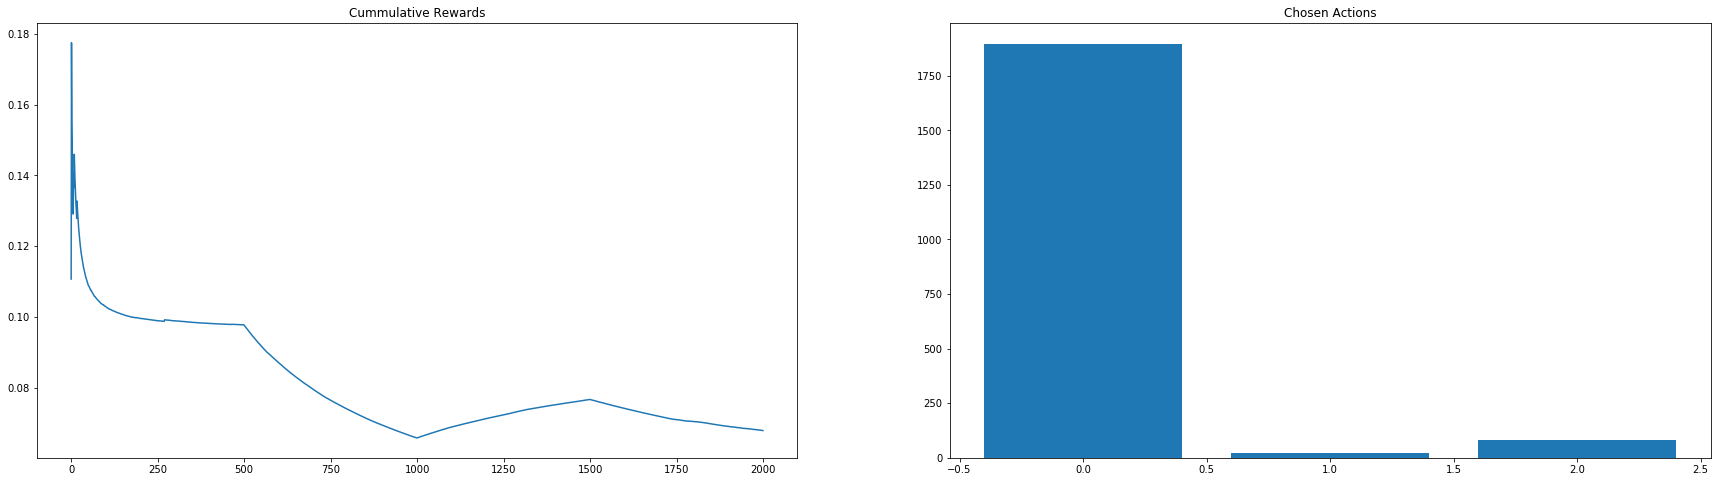

Total reward 135.7625


In [14]:
sample_mean_TS_stationary, sample_count_TS_stationary,rewards_TS_stationary,cum_rewards_TS_stationary,n_TS_stationary = list_iteration_results_TS_stationary
plot_history(rewards_TS_stationary,cum_rewards_TS_stationary, sample_count_TS_stationary, sample_mean_TS_stationary)
print("Total reward", np.round(total_reward_TS_stationary,4))

In [15]:
array_rewards = np.array(rewards_TS_stationary)
algo = rpt.Pelt(model="rbf").fit(array_rewards)
result = algo.predict(100)
result

[500, 1000, 1500, 2000]

### Online changepoint detection: Bayesian Online change detection algorithm (https://arxiv.org/abs/0710.3742, https://nbviewer.jupyter.org/github/hildensia/bayesian_changepoint_detection/blob/master/Example%20Code.ipynb)

In [16]:
def TS_obcp(list_distributions, n_samples, var_multiplier = 5):
    # initialize
    total_reward = 0
    num_choices = len(choices)
    sample_count = [0 for i in range(num_choices)]
    sample_rewards = [0 for i in range(num_choices)]
    sample_mean = [0.0 for i in range(num_choices)]
    sample_var = [0.0 for i in range(num_choices)]
    arm_rewards = {0: [], 1:[], 2:[]}
    rewards = []
    cum_rewards = []
    var_multiplier = var_multiplier
    list_iteration_results = []

    for n, elem in enumerate(list_distributions):
        dist_type = elem
        distribion = create_df_distribution(n_samples=n_samples, dist_type=dist_type)
        print("\n")
        print("Iteration:", n)
        theta = {}
        for i in range(len(choices)):
            if sample_count[i] >= 2:
                theta[i] = t.rvs(df=sample_count[i]-1,loc=sample_mean[i],scale=np.sqrt(sample_var[i]/sample_count[i])*var_multiplier)
                print(choices_names[i],"Theta", theta[i])

            else:
                print("Less than two values for",choices_names[i])
                theta[i] = uniform.rvs(loc=0, scale=1)
                print(choices_names[i],"Theta", theta[i])

        choice = np.argmin([theta[i] for i in range(len(choices))])
        alg = choices[choice]
        alg_name = choices_names[choice]
        start_time = time.time()
        sorted_dist = alg(distribion[dist_type])
        reward = ((time.time() - start_time))*(1)
        print("\n")
        print("Chosen algorithm is: ", alg_name, "with reward:", reward)
        arm_rewards[choice].append(reward)
        sample_count[choice] += 1
        sample_rewards[choice] += reward
        sample_mean[choice] = np.mean(arm_rewards[choice])
        sample_var[choice] = np.var(arm_rewards[choice]).astype('float64')
        print("Sample mean is: ", sample_mean[choice], "Sample variance is:", sample_var[choice])
        total_reward += reward
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))

        array_rewards = np.array(rewards)
        #print(array_rewards)   
        if(len(array_rewards)>4):
            array_rewards_ma = moving_average(array_rewards, 3)
            R, maxes = oncd.online_changepoint_detection(array_rewards_ma, partial(oncd.constant_hazard, 250), oncd.StudentT(0.1, .01, 1, 0))
            Nw=3
            #print("R",R)
            for i, elem in enumerate(R[Nw,Nw:-1]):
                if elem > 0.2 and i!=0:
                        print("RESTART EXPERIMENT AT ITERATION:", n)

                        list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
                        sample_count = [0 for i in range(num_choices)]
                        sample_rewards = [0 for i in range(num_choices)]
                        sample_mean = [0.0 for i in range(num_choices)]
                        sample_var = [0.0 for i in range(num_choices)]
                        arm_rewards = {0: [], 1:[], 2:[]}
                        rewards = []
                        cum_rewards = []
                        n_consecutive_list = []


    list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
    return list_iteration_results, total_reward

In [17]:
list_iteration_results_obcp, total_reward_obcp = TS_obcp(list_distributions=list_distributions, n_samples=n_samples)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.1718625382133142
Less than two values for merge_sort
merge_sort Theta 0.6564895964152196
Less than two values for heap_sort
heap_sort Theta 0.401085815239004


Chosen algorithm is:  quick_sort with reward: 0.09375214576721191
Sample mean is:  0.09375214576721191 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.010757908800547278
Less than two values for merge_sort
merge_sort Theta 0.6097769537345306
Less than two values for heap_sort
heap_sort Theta 0.6013177348279002


Chosen algorithm is:  quick_sort with reward: 0.09973645210266113
Sample mean is:  0.09674429893493652 Sample variance is: 8.952980579124414e-06


Iteration: 2
quick_sort Theta 0.09933154824113809
Less than two values for merge_sort
merge_sort Theta 0.4470223855808927
Less than two values for heap_sort
heap_sort Theta 0.3008265677148326


Chosen algorithm is:  quick_sort with reward: 0.09375333786010742
Sam



Chosen algorithm is:  merge_sort with reward: 0.10571861267089844
Sample mean is:  0.10571861267089844 Sample variance is: 0.0


Iteration: 25
quick_sort Theta 0.09434871569085491
Less than two values for merge_sort
merge_sort Theta 0.6129651144164545
Less than two values for heap_sort
heap_sort Theta 0.7225001603527663


Chosen algorithm is:  quick_sort with reward: 0.09474754333496094
Sample mean is:  0.09674302736918132 Sample variance is: 6.546886712360195e-06


Iteration: 26
quick_sort Theta 0.09153469217070852
Less than two values for merge_sort
merge_sort Theta 0.21872036554570806
Less than two values for heap_sort
heap_sort Theta 0.822132882240256


Chosen algorithm is:  quick_sort with reward: 0.09674501419067383
Sample mean is:  0.09674310684204102 Sample variance is: 6.285011395448237e-06


Iteration: 27
quick_sort Theta 0.10099863127929834
Less than two values for merge_sort
merge_sort Theta 0.33362276848796213
Less than two values for heap_sort
heap_sort Theta 0.68906412



Chosen algorithm is:  quick_sort with reward: 0.09674477577209473
Sample mean is:  0.09655277272488208 Sample variance is: 4.6832103419972225e-06


Iteration: 52
quick_sort Theta 0.09618804378959832
merge_sort Theta 0.1057414597480079
heap_sort Theta 0.24046509285116885


Chosen algorithm is:  quick_sort with reward: 0.09574532508850098
Sample mean is:  0.09653595089912415 Sample variance is: 4.598943229498313e-06


Iteration: 53
quick_sort Theta 0.09384524126192673
merge_sort Theta 0.10484396869938303
heap_sort Theta 0.21534239923011012


Chosen algorithm is:  quick_sort with reward: 0.09773707389831543
Sample mean is:  0.09656046361339335 Sample variance is: 4.533929156943346e-06


Iteration: 54
quick_sort Theta 0.09858074131159834
merge_sort Theta 0.10609970566142571
heap_sort Theta 0.21533979111776125


Chosen algorithm is:  quick_sort with reward: 0.09674572944641113
Sample mean is:  0.0965641689300537 Sample variance is: 4.443923313010601e-06


Iteration: 55
quick_sort Theta 0.



Chosen algorithm is:  quick_sort with reward: 0.09774208068847656
Sample mean is:  0.09967995683352153 Sample variance is: 0.00010921747769593932


Iteration: 83
quick_sort Theta 0.09972315311186601
merge_sort Theta 0.11081651424547682
heap_sort Theta 0.21713932216890294


Chosen algorithm is:  quick_sort with reward: 0.0937504768371582
Sample mean is:  0.09959873108014669 Sample variance is: 0.00010819637672130246


Iteration: 84
quick_sort Theta 0.09749999437743967
merge_sort Theta 0.14517016453184306
heap_sort Theta 0.221579180991842


Chosen algorithm is:  quick_sort with reward: 0.09574389457702637
Sample mean is:  0.09954663869496938 Sample variance is: 0.00010693235753368853


Iteration: 85
quick_sort Theta 0.09148849200628859
merge_sort Theta 0.1228386920518507
heap_sort Theta 0.2163924195881826


Chosen algorithm is:  quick_sort with reward: 0.09840822219848633
Sample mean is:  0.09953145980834961 Sample variance is: 0.00010552364226289983


Iteration: 86
quick_sort Theta 0.



Iteration: 114
quick_sort Theta 0.10064330915187493
merge_sort Theta 0.10958994080899548
heap_sort Theta 0.22475249440627693


Chosen algorithm is:  quick_sort with reward: 0.09474825859069824
Sample mean is:  0.09872527360916138 Sample variance is: 8.171190137397275e-05


Iteration: 115
quick_sort Theta 0.09881636759136102
merge_sort Theta 0.09160789830469358
heap_sort Theta 0.22076981878263535


Chosen algorithm is:  merge_sort with reward: 0.10671615600585938
Sample mean is:  0.11170244216918945 Sample variance is: 9.477083203332118e-05


Iteration: 116
quick_sort Theta 0.09849564290351646
merge_sort Theta 0.11946289215043744
heap_sort Theta 0.21597710425332792


Chosen algorithm is:  quick_sort with reward: 0.09474849700927734
Sample mean is:  0.09868589958341994 Sample variance is: 8.105790403780641e-05


Iteration: 117
quick_sort Theta 0.09766465674828119
merge_sort Theta 0.10833797251314138
heap_sort Theta 0.21794817625410068


Chosen algorithm is:  quick_sort with reward: 0.0



Chosen algorithm is:  quick_sort with reward: 0.09774017333984375
Sample mean is:  0.09809172435069648 Sample variance is: 6.648420631370761e-05


Iteration: 146
quick_sort Theta 0.09340800762504416
merge_sort Theta 0.11296633316851262
heap_sort Theta 0.21529322018470654


Chosen algorithm is:  quick_sort with reward: 0.09474897384643555
Sample mean is:  0.09806560911238194 Sample variance is: 6.605141317225435e-05


Iteration: 147
quick_sort Theta 0.10326630932544235
merge_sort Theta 0.10771443494853843
heap_sort Theta 0.21612041254881076


Chosen algorithm is:  quick_sort with reward: 0.09375309944152832
Sample mean is:  0.09803217880485594 Sample variance is: 6.56824376525989e-05


Iteration: 148
quick_sort Theta 0.09582986167136066
merge_sort Theta 0.11719748740481753
heap_sort Theta 0.21436587075916377


Chosen algorithm is:  quick_sort with reward: 0.09674239158630371
Sample mean is:  0.09802225736471323 Sample variance is: 6.518988624390548e-05


Iteration: 149
quick_sort Thet



Iteration: 176
quick_sort Theta 0.10116896751267573
merge_sort Theta 0.09909124884732401
heap_sort Theta 0.214163066937031


Chosen algorithm is:  merge_sort with reward: 0.10372614860534668
Sample mean is:  0.10940879583358765 Sample variance is: 7.88799898991499e-05


Iteration: 177
quick_sort Theta 0.1014221960389972
merge_sort Theta 0.10718906330545086
heap_sort Theta 0.21227840246369223


Chosen algorithm is:  quick_sort with reward: 0.0967404842376709
Sample mean is:  0.097655577537341 Sample variance is: 5.550611135198812e-05


Iteration: 178
quick_sort Theta 0.10103535170373848
merge_sort Theta 0.10957207977685376
heap_sort Theta 0.21476876777549314


Chosen algorithm is:  quick_sort with reward: 0.09774041175842285
Sample mean is:  0.0976561178826982 Sample variance is: 5.51526147892703e-05


Iteration: 179
quick_sort Theta 0.10127637650133574
merge_sort Theta 0.10449289929952288
heap_sort Theta 0.21433068134672484


Chosen algorithm is:  quick_sort with reward: 0.0977370738



Chosen algorithm is:  quick_sort with reward: 0.0967414379119873
Sample mean is:  0.09737913465239312 Sample variance is: 4.805669836337478e-05


Iteration: 208
quick_sort Theta 0.10221088588244394
merge_sort Theta 0.11708096734689569
heap_sort Theta 0.21496962937559788


Chosen algorithm is:  quick_sort with reward: 0.0957486629486084
Sample mean is:  0.09737027339313341 Sample variance is: 4.780989016544534e-05


Iteration: 209
quick_sort Theta 0.09532832281210916
merge_sort Theta 0.11178453782504638
heap_sort Theta 0.21728336315705768


Chosen algorithm is:  quick_sort with reward: 0.09474921226501465
Sample mean is:  0.09735610549514358 Sample variance is: 4.758839252406806e-05


Iteration: 210
quick_sort Theta 0.09868238037348852
merge_sort Theta 0.10691068423529346
heap_sort Theta 0.21022181610317395


Chosen algorithm is:  quick_sort with reward: 0.10073208808898926
Sample mean is:  0.09737425593919652 Sample variance is: 4.7393487095931974e-05


Iteration: 211
quick_sort Thet



Iteration: 238
quick_sort Theta 0.10285914542993159
merge_sort Theta 0.1074936625467377
heap_sort Theta 0.2157086208851711


Chosen algorithm is:  quick_sort with reward: 0.09773850440979004
Sample mean is:  0.09722854627817162 Sample variance is: 4.25021730738835e-05


Iteration: 239
quick_sort Theta 0.0970780325218121
merge_sort Theta 0.10051594354070274
heap_sort Theta 0.2200542992224471


Chosen algorithm is:  quick_sort with reward: 0.09724998474121094
Sample mean is:  0.09722864740299729 Sample variance is: 4.230169328315639e-05


Iteration: 240
quick_sort Theta 0.09970057049219579
merge_sort Theta 0.11422390394105125
heap_sort Theta 0.2153854582981565


Chosen algorithm is:  quick_sort with reward: 0.09574484825134277
Sample mean is:  0.09722168120979703 Sample variance is: 4.2113381687887536e-05


Iteration: 241
quick_sort Theta 0.09681959926295916
merge_sort Theta 0.11543788568741593
heap_sort Theta 0.21616734652961514


Chosen algorithm is:  quick_sort with reward: 0.096744



Chosen algorithm is:  quick_sort with reward: 0.09574389457702637
Sample mean is:  0.09713451762994131 Sample variance is: 3.764101967523834e-05


Iteration: 269
quick_sort Theta 0.09672989336823684
merge_sort Theta 0.12575491409969344
heap_sort Theta 0.20888137837877901


Chosen algorithm is:  quick_sort with reward: 0.10671830177307129
Sample mean is:  0.09717428436912441 Sample variance is: 3.786436732246849e-05


Iteration: 270
quick_sort Theta 0.09953474288701356
merge_sort Theta 0.10530766968022452
heap_sort Theta 0.21632143121173766


Chosen algorithm is:  quick_sort with reward: 0.09474682807922363
Sample mean is:  0.09716425355800912 Sample variance is: 3.773215173305268e-05


Iteration: 271
quick_sort Theta 0.10025707258488115
merge_sort Theta 0.07568225512461804
heap_sort Theta 0.1448727355462506


Chosen algorithm is:  merge_sort with reward: 0.10970759391784668
Sample mean is:  0.10846150772912162 Sample variance is: 6.021566432570281e-05


Iteration: 272
quick_sort Thet



Chosen algorithm is:  quick_sort with reward: 0.1236715316772461
Sample mean is:  0.09755435775728262 Sample variance is: 4.601466047860325e-05


Iteration: 299
quick_sort Theta 0.09812900003906835
merge_sort Theta 0.10751829746768624
heap_sort Theta 0.21237015072041712


Chosen algorithm is:  quick_sort with reward: 0.09973692893981934
Sample mean is:  0.0975625016796055 Sample variance is: 4.586067235098408e-05


Iteration: 300
quick_sort Theta 0.09612950698774916
merge_sort Theta 0.11253293131718592
heap_sort Theta 0.2146058895419136


Chosen algorithm is:  quick_sort with reward: 0.12367558479309082
Sample mean is:  0.09765957633801996 Sample variance is: 4.821568171424586e-05


Iteration: 301
quick_sort Theta 0.09763142957958293
merge_sort Theta 0.10498513251225244
heap_sort Theta 0.23546590501530817


Chosen algorithm is:  quick_sort with reward: 0.10473179817199707
Sample mean is:  0.09768576975221988 Sample variance is: 4.8221664656167796e-05


Iteration: 302
quick_sort Theta



Chosen algorithm is:  quick_sort with reward: 0.09873795509338379
Sample mean is:  0.0980476028210408 Sample variance is: 5.007152865110663e-05


Iteration: 329
quick_sort Theta 0.10050523715943684
merge_sort Theta 0.11035338401733115
heap_sort Theta 0.21616313593469044


Chosen algorithm is:  quick_sort with reward: 0.09674191474914551
Sample mean is:  0.09804320656490648 Sample variance is: 4.990865845767493e-05


Iteration: 330
quick_sort Theta 0.09660071005281522
merge_sort Theta 0.11611872073883905
heap_sort Theta 0.21480691103169192


Chosen algorithm is:  quick_sort with reward: 0.09874272346496582
Sample mean is:  0.09804555393705432 Sample variance is: 4.9742816254350446e-05


Iteration: 331
quick_sort Theta 0.0979870464340218
merge_sort Theta 0.10644315160850595
heap_sort Theta 0.218809368230842


Chosen algorithm is:  quick_sort with reward: 0.09973430633544922
Sample mean is:  0.09805120193838675 Sample variance is: 4.958595849626664e-05


Iteration: 332
quick_sort Theta 



Chosen algorithm is:  quick_sort with reward: 0.09774017333984375
Sample mean is:  0.09805700889000526 Sample variance is: 4.571794748350124e-05


Iteration: 359
quick_sort Theta 0.09897707580145765
merge_sort Theta 0.10886410917010232
heap_sort Theta 0.21713069782765898


Chosen algorithm is:  quick_sort with reward: 0.09674263000488281
Sample mean is:  0.09805297705293434 Sample variance is: 4.558299148659522e-05


Iteration: 360
quick_sort Theta 0.09990305619255051
merge_sort Theta 0.11107905159368422
heap_sort Theta 0.21562301891459668


Chosen algorithm is:  quick_sort with reward: 0.09674501419067383
Sample mean is:  0.0980489771665054 Sample variance is: 4.5448809662924145e-05


Iteration: 361
quick_sort Theta 0.0982072443426635
merge_sort Theta 0.12060883953664202
heap_sort Theta 0.2135059710212951


Chosen algorithm is:  quick_sort with reward: 0.09774160385131836
Sample mean is:  0.09804804005273958 Sample variance is: 4.5310533384412564e-05


Iteration: 362
quick_sort Thet



Iteration: 389
quick_sort Theta 0.09729813276503263
merge_sort Theta 0.11162700367318647
heap_sort Theta 0.21587938364495204


Chosen algorithm is:  quick_sort with reward: 0.09674334526062012
Sample mean is:  0.0982947113823756 Sample variance is: 4.738054738957493e-05


Iteration: 390
quick_sort Theta 0.09891936168858413
merge_sort Theta 0.09990647504587986
heap_sort Theta 0.2118138987490713


Chosen algorithm is:  quick_sort with reward: 0.10072922706604004
Sample mean is:  0.09830156917303381 Sample variance is: 4.726372942852006e-05


Iteration: 391
quick_sort Theta 0.09747448860684442
merge_sort Theta 0.11236872267889435
heap_sort Theta 0.21686745389538659


Chosen algorithm is:  quick_sort with reward: 0.09973287582397461
Sample mean is:  0.0983055896973342 Sample variance is: 4.7136704582164264e-05


Iteration: 392
quick_sort Theta 0.09747437513642879
merge_sort Theta 0.10860973813223326
heap_sort Theta 0.21463741983523296


Chosen algorithm is:  quick_sort with reward: 0.099



Iteration: 419
quick_sort Theta 0.099833828257962
merge_sort Theta 0.10143645390988532
heap_sort Theta 0.21760562689939392


Chosen algorithm is:  quick_sort with reward: 0.10272717475891113
Sample mean is:  0.09844104973181571 Sample variance is: 4.639833643198917e-05


Iteration: 420
quick_sort Theta 0.09868608515995561
merge_sort Theta 0.110299191603297
heap_sort Theta 0.21396272120826504


Chosen algorithm is:  quick_sort with reward: 0.09375238418579102
Sample mean is:  0.09842871113827353 Sample variance is: 4.63339348441788e-05


Iteration: 421
quick_sort Theta 0.09767006893801324
merge_sort Theta 0.11711356345336324
heap_sort Theta 0.21623326493120304


Chosen algorithm is:  quick_sort with reward: 0.10272550582885742
Sample mean is:  0.09843998881462677 Sample variance is: 4.626065414052782e-05


Iteration: 422
quick_sort Theta 0.09618801504643948
merge_sort Theta 0.10485144209347025
heap_sort Theta 0.20999673229101143


Chosen algorithm is:  quick_sort with reward: 0.109707


Iteration: 448
Less than two values for quick_sort
quick_sort Theta 0.32036187088730783
merge_sort Theta 0.10702440705585958
Less than two values for heap_sort
heap_sort Theta 0.4663235852397426


Chosen algorithm is:  merge_sort with reward: 0.1186835765838623
Sample mean is:  0.11344784498214722 Sample variance is: 2.156974779765619e-05


Iteration: 449
Less than two values for quick_sort
quick_sort Theta 0.7999516077044041
merge_sort Theta 0.10875501457958428
Less than two values for heap_sort
heap_sort Theta 0.8931597917948586


Chosen algorithm is:  merge_sort with reward: 0.10870933532714844
Sample mean is:  0.11250014305114746 Sample variance is: 2.0848354038207616e-05


Iteration: 450
Less than two values for quick_sort
quick_sort Theta 0.9817566722878825
merge_sort Theta 0.1158763894737697
Less than two values for heap_sort
heap_sort Theta 0.2117030667457731


Chosen algorithm is:  merge_sort with reward: 0.10871219635009766
Sample mean is:  0.11186881860097249 Sample varianc



Iteration: 477
quick_sort Theta 0.09814342628149042
merge_sort Theta 0.11723786800424303
heap_sort Theta 0.25700928524194044


Chosen algorithm is:  quick_sort with reward: 0.11369919776916504
Sample mean is:  0.10531846682230632 Sample variance is: 3.660240094076371e-05


Iteration: 478
quick_sort Theta 0.0957251528126733
merge_sort Theta 0.11718925288390318
heap_sort Theta 0.26313789492460715


Chosen algorithm is:  quick_sort with reward: 0.10173201560974121
Sample mean is:  0.105094313621521 Sample variance is: 3.506842074330052e-05


Iteration: 479
quick_sort Theta 0.10530103024699357
merge_sort Theta 0.11009376292643455
heap_sort Theta 0.10960886150411447


Chosen algorithm is:  quick_sort with reward: 0.1037282943725586
Sample mean is:  0.10501395954805262 Sample variance is: 3.310888089825023e-05


Iteration: 480
quick_sort Theta 0.11655096979288107
merge_sort Theta 0.11372196567709882
heap_sort Theta 0.25371032772317226


Chosen algorithm is:  merge_sort with reward: 0.11569



Iteration: 508
quick_sort Theta 0.09192854512007868
merge_sort Theta 0.12473068149983309
heap_sort Theta 0.22970672370158873


Chosen algorithm is:  quick_sort with reward: 0.03690004348754883
Sample mean is:  0.09375864106255609 Sample variance is: 0.0006822705537185547


Iteration: 509
quick_sort Theta 0.0899993245436416
merge_sort Theta 0.09221620300067176
heap_sort Theta 0.2540676836599131


Chosen algorithm is:  quick_sort with reward: 0.031913042068481445
Sample mean is:  0.09213112529955413 Sample variance is: 0.0007623219451391383


Iteration: 510
quick_sort Theta 0.11053829118405473
merge_sort Theta 0.05692808226870156
heap_sort Theta 0.20813936466292848


Chosen algorithm is:  merge_sort with reward: 0.02692580223083496
Sample mean is:  0.09942749830392691 Sample variance is: 0.0009461253431293608


Iteration: 511
quick_sort Theta 0.08373960295440454
merge_sort Theta 0.09380204685440675
heap_sort Theta 0.2183917133716776


Chosen algorithm is:  quick_sort with reward: 0.036



Iteration: 538
quick_sort Theta 0.11393606648124606
merge_sort Theta 0.15300350430057785
heap_sort Theta 0.2504525699244566


Chosen algorithm is:  quick_sort with reward: 0.03191494941711426
Sample mean is:  0.07628363370895386 Sample variance is: 0.0012396211654366158


Iteration: 539
quick_sort Theta 0.0906238946076252
merge_sort Theta 0.07165500408681107
heap_sort Theta 0.24106638850756595


Chosen algorithm is:  merge_sort with reward: 0.02593088150024414
Sample mean is:  0.07309761279966773 Sample variance is: 0.0018023106912819517


Iteration: 540
quick_sort Theta 0.04281448185126836
merge_sort Theta 0.029503858324716907
heap_sort Theta 0.2321617399742391


Chosen algorithm is:  merge_sort with reward: 0.02593064308166504
Sample mean is:  0.07197458971114386 Sample variance is: 0.0018111069471173804


Iteration: 541
quick_sort Theta 0.04497171003368453
merge_sort Theta 0.10677232621073714
heap_sort Theta 0.25141791891158377


Chosen algorithm is:  quick_sort with reward: 0.031



Chosen algorithm is:  quick_sort with reward: 0.03490447998046875
Sample mean is:  0.06794682649465708 Sample variance is: 0.0012707587113821928


Iteration: 569
quick_sort Theta 0.053693959625956335
merge_sort Theta 0.09784895103057066
heap_sort Theta 0.22448445594066824


Chosen algorithm is:  quick_sort with reward: 0.03690457344055176
Sample mean is:  0.06747648932717064 Sample variance is: 0.0012658838998355116


Iteration: 570
quick_sort Theta 0.07019472046540273
merge_sort Theta 0.05802384960414992
heap_sort Theta 0.23071329420822942


Chosen algorithm is:  merge_sort with reward: 0.02991938591003418
Sample mean is:  0.05963383049800478 Sample variance is: 0.001711940266902562


Iteration: 571
quick_sort Theta 0.08350697032136026
merge_sort Theta 0.08404639340699731
heap_sort Theta 0.25289638622370864


Chosen algorithm is:  quick_sort with reward: 0.031914472579956055
Sample mean is:  0.06694571295780923 Sample variance is: 0.0012655838648677118


Iteration: 572
quick_sort Th



Iteration: 599
quick_sort Theta 0.07526135150233648
merge_sort Theta 0.06347103207812359
heap_sort Theta 0.2654135657304264


Chosen algorithm is:  merge_sort with reward: 0.024931669235229492
Sample mean is:  0.05361719870231521 Sample variance is: 0.0015602411047224301


Iteration: 600
quick_sort Theta 0.03325679047319599
merge_sort Theta 0.045480966205981174
heap_sort Theta 0.25201631703717586


Chosen algorithm is:  quick_sort with reward: 0.031914472579956055
Sample mean is:  0.060276855905371976 Sample variance is: 0.0012080644787729466


Iteration: 601
quick_sort Theta 0.05088852745859576
merge_sort Theta 0.06400279855395766
heap_sort Theta 0.20784243005190906


Chosen algorithm is:  quick_sort with reward: 0.03690147399902344
Sample mean is:  0.05999857754934402 Sample variance is: 0.0012001101827925453


Iteration: 602
quick_sort Theta 0.06573393198235049
merge_sort Theta 0.09544111771674921
heap_sort Theta 0.243580002101625


Chosen algorithm is:  quick_sort with reward: 0.


Chosen algorithm is:  quick_sort with reward: 0.03490424156188965
Sample mean is:  0.05667036523421606 Sample variance is: 0.0011279011647410719


Iteration: 630
quick_sort Theta 0.08393637567956012
merge_sort Theta 0.036245209037332575
heap_sort Theta 0.2027911832383741


Chosen algorithm is:  merge_sort with reward: 0.026927947998046875
Sample mean is:  0.04851812124252319 Sample variance is: 0.0013678688575570095


Iteration: 631
quick_sort Theta 0.03821059593518266
merge_sort Theta 0.061293265397529814
heap_sort Theta 0.26566128354784585


Chosen algorithm is:  quick_sort with reward: 0.032912254333496094
Sample mean is:  0.056425436255858115 Sample variance is: 0.001122032377308074


Iteration: 632
quick_sort Theta 0.06562733203008334
merge_sort Theta 0.014753466303006398
heap_sort Theta 0.24943169864282436


Chosen algorithm is:  merge_sort with reward: 0.028922319412231445
Sample mean is:  0.04829794369386823 Sample variance is: 0.0013567656220087416


Iteration: 633
quick_sort

Chosen algorithm is:  merge_sort with reward: 0.028920888900756836
Sample mean is:  0.04501339367457798 Sample variance is: 0.0012102624106746032


Iteration: 660
quick_sort Theta 0.027989605378829437
merge_sort Theta 0.0550244829122156
heap_sort Theta 0.25638695070286294


Chosen algorithm is:  quick_sort with reward: 0.03191328048706055
Sample mean is:  0.053827629176848524 Sample variance is: 0.0010533208710683931


Iteration: 661
quick_sort Theta 0.052502033026209934
merge_sort Theta 0.012544187925048501
heap_sort Theta 0.24940577128312072


Chosen algorithm is:  merge_sort with reward: 0.025928020477294922
Sample mean is:  0.04483334298403758 Sample variance is: 0.0012022487571348068


Iteration: 662
quick_sort Theta 0.055999990424497485
merge_sort Theta 0.03371637940915456
heap_sort Theta 0.23382222029269395


Chosen algorithm is:  merge_sort with reward: 0.029921531677246094
Sample mean is:  0.044693980261544204 Sample variance is: 0.0011930715160945596


Iteration: 663
quick_so

Chosen algorithm is:  merge_sort with reward: 0.026928424835205078
Sample mean is:  0.042335189819335935 Sample variance is: 0.0010549982080411647


Iteration: 691
quick_sort Theta 0.055874708532829775
merge_sort Theta 0.039931663781559046
heap_sort Theta 0.24197206090700488


Chosen algorithm is:  merge_sort with reward: 0.025929927825927734
Sample mean is:  0.04220498932732476 Sample variance is: 0.0010487442274050383


Iteration: 692
quick_sort Theta 0.043561028224288596
merge_sort Theta 0.04298191914664847
heap_sort Theta 0.24574805814630943


Chosen algorithm is:  merge_sort with reward: 0.025930404663085938
Sample mean is:  0.04207684299138587 Sample variance is: 0.0010425555057530288


Iteration: 693
quick_sort Theta 0.05992441857814873
merge_sort Theta 0.057956322696973386
heap_sort Theta 0.21468752926427664


Chosen algorithm is:  merge_sort with reward: 0.026927471160888672
Sample mean is:  0.041958488523960114 Sample variance is: 0.001036189528919207


Iteration: 694
quick_s



Iteration: 721
quick_sort Theta 0.05813321723794751
merge_sort Theta 0.028014263989780065
heap_sort Theta 0.24409190656447236


Chosen algorithm is:  merge_sort with reward: 0.02892327308654785
Sample mean is:  0.04019007811675201 Sample variance is: 0.0009166144391561454


Iteration: 722
quick_sort Theta 0.06390701414902082
merge_sort Theta 0.045212264826791276
heap_sort Theta 0.18016628477189123


Chosen algorithm is:  merge_sort with reward: 0.030916452407836914
Sample mean is:  0.040127839018034454 Sample variance is: 0.000911035972797266


Iteration: 723
quick_sort Theta 0.05149049251275173
merge_sort Theta 0.029294168622718934
heap_sort Theta 0.24630618575967786


Chosen algorithm is:  merge_sort with reward: 0.031914472579956055
Sample mean is:  0.0400730832417806 Sample variance is: 0.0009054091307052253


Iteration: 724
quick_sort Theta 0.040879163961353666
merge_sort Theta 0.023228743632415505
heap_sort Theta 0.22681193480664277


Chosen algorithm is:  merge_sort with rewar

quick_sort Theta 0.0556694996679052
merge_sort Theta 0.017794322061610725
heap_sort Theta 0.2196508122903657


Chosen algorithm is:  merge_sort with reward: 0.02892279624938965
Sample mean is:  0.038762881312259405 Sample variance is: 0.0008019636105478036


Iteration: 752
quick_sort Theta 0.03893776102348093
merge_sort Theta 0.0471973867386418
heap_sort Theta 0.24296334928629076


Chosen algorithm is:  quick_sort with reward: 0.034906864166259766
Sample mean is:  0.05042407227985894 Sample variance is: 0.0009085254628330782


Iteration: 753
quick_sort Theta 0.054444808937647554
merge_sort Theta 0.03493013783049783
heap_sort Theta 0.23670222655985002


Chosen algorithm is:  merge_sort with reward: 0.028921127319335938
Sample mean is:  0.038705992560855225 Sample variance is: 0.0007978846315074171


Iteration: 754
quick_sort Theta 0.03892503451550503
merge_sort Theta 0.03928275416590025
heap_sort Theta 0.2741958371978436


Chosen algorithm is:  quick_sort with reward: 0.0349071025848388



Iteration: 781
quick_sort Theta 0.034403017160244465
merge_sort Theta 0.0311222025056758
heap_sort Theta 0.26153547561424306


Chosen algorithm is:  merge_sort with reward: 0.03789949417114258
Sample mean is:  0.037637812052017605 Sample variance is: 0.0007173740351325646


Iteration: 782
quick_sort Theta 0.06308830795326409
merge_sort Theta 0.03266754517174997
heap_sort Theta 0.2422642912563171


Chosen algorithm is:  merge_sort with reward: 0.027922630310058594
Sample mean is:  0.0375882447982321 Sample variance is: 0.0007141930614910736


Iteration: 783
quick_sort Theta 0.06686821463188769
merge_sort Theta 0.027339061264726485
heap_sort Theta 0.25021031852548775


Chosen algorithm is:  merge_sort with reward: 0.02991962432861328
Sample mean is:  0.037549317790772106 Sample variance is: 0.0007108647171355899


Iteration: 784
quick_sort Theta 0.02835263104769542
merge_sort Theta 0.037882211873982836
heap_sort Theta 0.2519027975673037


Chosen algorithm is:  quick_sort with reward: 0



Iteration: 811
quick_sort Theta 0.04020881568388848
merge_sort Theta 0.04861785110804338
heap_sort Theta 0.21968814554676858


Chosen algorithm is:  quick_sort with reward: 0.035906314849853516
Sample mean is:  0.04909930099435404 Sample variance is: 0.0008464269774759427


Iteration: 812
quick_sort Theta 0.05840791367349543
merge_sort Theta 0.030542252947432822
heap_sort Theta 0.20142908862458703


Chosen algorithm is:  merge_sort with reward: 0.02792501449584961
Sample mean is:  0.03677389610847926 Sample variance is: 0.0006452651218444447


Iteration: 813
quick_sort Theta 0.058664786870263164
merge_sort Theta 0.03778955859975617
heap_sort Theta 0.21449682254564006


Chosen algorithm is:  merge_sort with reward: 0.027925729751586914
Sample mean is:  0.03673367717049338 Sample variance is: 0.000642686344854357


Iteration: 814
quick_sort Theta 0.060512592680237176
merge_sort Theta 0.028173205987173742
heap_sort Theta 0.2156821469518398


Chosen algorithm is:  merge_sort with reward:



Iteration: 841
quick_sort Theta 0.04392997657744324
merge_sort Theta 0.041137070392124137
heap_sort Theta 0.22618360849867405


Chosen algorithm is:  merge_sort with reward: 0.02892327308654785
Sample mean is:  0.03589481236983319 Sample variance is: 0.0005833929127873141


Iteration: 842
quick_sort Theta 0.043440753115888936
merge_sort Theta 0.03223965905362852
heap_sort Theta 0.22133154872915176


Chosen algorithm is:  merge_sort with reward: 0.02792501449584961
Sample mean is:  0.03586241481749992 Sample variance is: 0.0005812785492239854


Iteration: 843
quick_sort Theta 0.05691528988954171
merge_sort Theta 0.037947261323093645
heap_sort Theta 0.24108590690500098


Chosen algorithm is:  merge_sort with reward: 0.02792501449584961
Sample mean is:  0.03583027959352563 Sample variance is: 0.0005791792322381757


Iteration: 844
quick_sort Theta 0.05522859000390744
merge_sort Theta 0.04077502684420944
heap_sort Theta 0.31621797737796586


Chosen algorithm is:  merge_sort with reward: 



Iteration: 871
quick_sort Theta 0.050239852660151456
merge_sort Theta 0.03585217086409041
heap_sort Theta 0.2873930233410273


Chosen algorithm is:  merge_sort with reward: 0.025931358337402344
Sample mean is:  0.03522460788599177 Sample variance is: 0.0005361056043698073


Iteration: 872
quick_sort Theta 0.035076851625107465
merge_sort Theta 0.040823189864112874
heap_sort Theta 0.2365838862958437


Chosen algorithm is:  quick_sort with reward: 0.033910512924194336
Sample mean is:  0.04827787010533035 Sample variance is: 0.000803776916430189


Iteration: 873
quick_sort Theta 0.06008977727982169
merge_sort Theta 0.040061920276729154
heap_sort Theta 0.23478426891821252


Chosen algorithm is:  merge_sort with reward: 0.03092026710510254
Sample mean is:  0.035208665883099594 Sample variance is: 0.0005341883937230481


Iteration: 874
quick_sort Theta 0.04377709035910294
merge_sort Theta 0.027251327050308388
heap_sort Theta 0.25476913816445246


Chosen algorithm is:  merge_sort with reward



Iteration: 901
quick_sort Theta 0.054860690077042897
merge_sort Theta 0.024171448717007014
heap_sort Theta 0.2391027976041006


Chosen algorithm is:  merge_sort with reward: 0.027927160263061523
Sample mean is:  0.034683125125583504 Sample variance is: 0.000499387977177426


Iteration: 902
quick_sort Theta 0.05795891335031019
merge_sort Theta 0.030018665412595645
heap_sort Theta 0.4355181481653196


Chosen algorithm is:  merge_sort with reward: 0.02593255043029785
Sample mean is:  0.034653157404024304 Sample variance is: 0.0004979390811004888


Iteration: 903
quick_sort Theta 0.0587063935332795
merge_sort Theta 0.03922744966555872
heap_sort Theta 0.24582993284496704


Chosen algorithm is:  merge_sort with reward: 0.0249330997467041
Sample mean is:  0.0346199831458082 Sample variance is: 0.0004965609854829414


Iteration: 904
quick_sort Theta 0.07481583938467237
merge_sort Theta 0.03186871293587972
heap_sort Theta 0.22850961858002117


Chosen algorithm is:  merge_sort with reward: 0.0



Iteration: 931
quick_sort Theta 0.040650033513232695
merge_sort Theta 0.0375582106382868
heap_sort Theta 0.21424486046744884


Chosen algorithm is:  merge_sort with reward: 0.026929616928100586
Sample mean is:  0.03407439318570224 Sample variance is: 0.00045959931147677996


Iteration: 932
quick_sort Theta 0.04953887901984753
merge_sort Theta 0.039674604407429453
heap_sort Theta 0.23200372744033843


Chosen algorithm is:  merge_sort with reward: 0.02792525291442871
Sample mean is:  0.03405517712235451 Sample variance is: 0.00045828085664031124


Iteration: 933
quick_sort Theta 0.058403897040147354
merge_sort Theta 0.035128584352527144
heap_sort Theta 0.22746476864459714


Chosen algorithm is:  merge_sort with reward: 0.027927160263061523
Sample mean is:  0.03403608672715422 Sample variance is: 0.00045696981224069706


Iteration: 934
quick_sort Theta 0.04474122244339289
merge_sort Theta 0.03556966596779801
heap_sort Theta 0.24526770785250063


Chosen algorithm is:  merge_sort with rew



Iteration: 961
quick_sort Theta 0.046125870913273935
merge_sort Theta 0.04158003045515778
heap_sort Theta 0.21209684820634098


Chosen algorithm is:  merge_sort with reward: 0.028924942016601562
Sample mean is:  0.03353525650947856 Sample variance is: 0.00042616004129074526


Iteration: 962
quick_sort Theta 0.048999313166621386
merge_sort Theta 0.030328068573094384
heap_sort Theta 0.18599372110612394


Chosen algorithm is:  merge_sort with reward: 0.025929689407348633
Sample mean is:  0.03351340143159888 Sample variance is: 0.0004251011860878512


Iteration: 963
quick_sort Theta 0.04563163644107121
merge_sort Theta 0.030619592549315743
heap_sort Theta 0.24896617792824646


Chosen algorithm is:  merge_sort with reward: 0.025931835174560547
Sample mean is:  0.03349167774604863 Sample variance is: 0.00042404735875621987


Iteration: 964
quick_sort Theta 0.03441198475322614
merge_sort Theta 0.028322451420893603
heap_sort Theta 0.22231909669497013


Chosen algorithm is:  merge_sort with r



Iteration: 991
quick_sort Theta 0.06384667395960351
merge_sort Theta 0.03929876406886122
heap_sort Theta 0.2637312657388609


Chosen algorithm is:  merge_sort with reward: 0.025932788848876953
Sample mean is:  0.03305219716214119 Sample variance is: 0.0003963441198964347


Iteration: 992
quick_sort Theta 0.06410712277886574
merge_sort Theta 0.03351985102401036
heap_sort Theta 0.2472787184981657


Chosen algorithm is:  merge_sort with reward: 0.029923200607299805
Sample mean is:  0.033043897436531536 Sample variance is: 0.0003953187101609731


Iteration: 993
quick_sort Theta 0.037110458993521
merge_sort Theta 0.030726212635818127
heap_sort Theta 0.22225645507349276


Chosen algorithm is:  merge_sort with reward: 0.02692723274230957
Sample mean is:  0.03302771578390132 Sample variance is: 0.000394371609364881


Iteration: 994
quick_sort Theta 0.04648153405507209
merge_sort Theta 0.028267593941795132
heap_sort Theta 0.21743134564085584


Chosen algorithm is:  merge_sort with reward: 0.0



Iteration: 1018
quick_sort Theta 0.12526563477435992
Less than two values for merge_sort
merge_sort Theta 0.032526955691418724
heap_sort Theta 0.28423568854037734


Chosen algorithm is:  merge_sort with reward: 0.10770964622497559
Sample mean is:  0.10521852970123291 Sample variance is: 6.205661534863793e-06


Iteration: 1019
quick_sort Theta 0.10392155976802947
merge_sort Theta 0.13200922605440543
heap_sort Theta 0.2198180024530959


Chosen algorithm is:  quick_sort with reward: 0.09773945808410645
Sample mean is:  0.10464569926261902 Sample variance is: 1.9441384771390346e-05


Iteration: 1020
quick_sort Theta 0.09492554808038971
merge_sort Theta 0.04824206369524171
heap_sort Theta 0.27361075506966814


Chosen algorithm is:  merge_sort with reward: 0.1156911849975586
Sample mean is:  0.10870941480000813 Sample variance is: 2.850966523561106e-05


Iteration: 1021
quick_sort Theta 0.11943042886707544
merge_sort Theta 0.11455360768760485
heap_sort Theta 0.23615008326484285


Chosen al



Iteration: 1048
quick_sort Theta 0.09984383539742386
merge_sort Theta 0.1091305225964001
heap_sort Theta 0.20380571933365899


Chosen algorithm is:  quick_sort with reward: 0.10571980476379395
Sample mean is:  0.10336711009343465 Sample variance is: 1.965359626352223e-05


Iteration: 1049
quick_sort Theta 0.09891727086869477
merge_sort Theta 0.10890139656662486
heap_sort Theta 0.23744689598832858


Chosen algorithm is:  quick_sort with reward: 0.10970902442932129
Sample mean is:  0.10362078666687012 Sample variance is: 2.041189570682036e-05


Iteration: 1050
quick_sort Theta 0.0992188894255962
merge_sort Theta 0.09883177943490984
heap_sort Theta 0.19337730306132186


Chosen algorithm is:  merge_sort with reward: 0.115692138671875
Sample mean is:  0.10953034460544586 Sample variance is: 4.822982143770638e-05


Iteration: 1051
quick_sort Theta 0.095336650767675
merge_sort Theta 0.11036376714957499
heap_sort Theta 0.24489448361773622


Chosen algorithm is:  quick_sort with reward: 0.098



Iteration: 1078
quick_sort Theta 0.10014553988718958
merge_sort Theta 0.11158590125797853
heap_sort Theta 0.23649543849372748


Chosen algorithm is:  quick_sort with reward: 0.09674263000488281
Sample mean is:  0.10005203247070313 Sample variance is: 2.4794314946939266e-05


Iteration: 1079
quick_sort Theta 0.09298339996751735
merge_sort Theta 0.11490194139662412
heap_sort Theta 0.2632197221459158


Chosen algorithm is:  quick_sort with reward: 0.09773921966552734
Sample mean is:  0.10000668320001341 Sample variance is: 2.4410979726368465e-05


Iteration: 1080
quick_sort Theta 0.09914990779967241
merge_sort Theta 0.11534706801708883
heap_sort Theta 0.18835692770800064


Chosen algorithm is:  quick_sort with reward: 0.0937502384185791
Sample mean is:  0.09988636695421658 Sample variance is: 2.4679813757688294e-05


Iteration: 1081
quick_sort Theta 0.09694797052097304
merge_sort Theta 0.10081614048881246
heap_sort Theta 0.21943500910809127


Chosen algorithm is:  quick_sort with reward



Chosen algorithm is:  quick_sort with reward: 0.09973311424255371
Sample mean is:  0.09990362377909871 Sample variance is: 3.6343005232595404e-05


Iteration: 1109
quick_sort Theta 0.10147112975909255
merge_sort Theta 0.11483075918353267
heap_sort Theta 0.15772261027349788


Chosen algorithm is:  quick_sort with reward: 0.10970544815063477
Sample mean is:  0.1000292881941184 Sample variance is: 3.7093018248647567e-05


Iteration: 1110
quick_sort Theta 0.10452071732752469
merge_sort Theta 0.10539702174445466
heap_sort Theta 0.27471527523334227


Chosen algorithm is:  quick_sort with reward: 0.11170196533203125
Sample mean is:  0.10017704360092743 Sample variance is: 3.8326355870903796e-05


Iteration: 1111
quick_sort Theta 0.09699882435655859
merge_sort Theta 0.10267388388741801
heap_sort Theta 0.12629343490959927


Chosen algorithm is:  quick_sort with reward: 0.09873485565185547
Sample mean is:  0.10015901625156402 Sample variance is: 3.787295026319804e-05


Iteration: 1112
quick_so



Chosen algorithm is:  quick_sort with reward: 0.1186838150024414
Sample mean is:  0.09993242745352264 Sample variance is: 3.890602563993404e-05


Iteration: 1139
quick_sort Theta 0.09302095570942102
merge_sort Theta 0.09445514640932551
heap_sort Theta 0.2562849622940596


Chosen algorithm is:  quick_sort with reward: 0.11369633674621582
Sample mean is:  0.1000673677407059 Sample variance is: 4.036369100762845e-05


Iteration: 1140
quick_sort Theta 0.10177789151016375
merge_sort Theta 0.1029908053127282
heap_sort Theta 0.21214571329015333


Chosen algorithm is:  quick_sort with reward: 0.09974098205566406
Sample mean is:  0.10006419894764725 Sample variance is: 3.997283471985253e-05
RESTART EXPERIMENT AT ITERATION: 1140


Iteration: 1141
Less than two values for quick_sort
quick_sort Theta 0.8189765696695316
Less than two values for merge_sort
merge_sort Theta 0.944061186813015
Less than two values for heap_sort
heap_sort Theta 0.9665936853358112


Chosen algorithm is:  quick_sort wit



Chosen algorithm is:  heap_sort with reward: 0.21442842483520508
Sample mean is:  0.2164231538772583 Sample variance is: 3.978943951210567e-06


Iteration: 1165
quick_sort Theta 0.1175849199416555
merge_sort Theta 0.14588667546793513
heap_sort Theta 0.21598322666252587


Chosen algorithm is:  quick_sort with reward: 0.09375166893005371
Sample mean is:  0.1054694652557373 Sample variance is: 9.192874438213039e-05


Iteration: 1166
quick_sort Theta 0.1002615337693836
merge_sort Theta 0.10687884774274832
heap_sort Theta 0.21762706630312248


Chosen algorithm is:  quick_sort with reward: 0.09674429893493652
Sample mean is:  0.10495622017804314 Sample variance is: 9.073589933961816e-05


Iteration: 1167
quick_sort Theta 0.10160240297165919
merge_sort Theta 0.09769386961300669
heap_sort Theta 0.22424907491787183


Chosen algorithm is:  merge_sort with reward: 0.1077110767364502
Sample mean is:  0.11020359396934509 Sample variance is: 4.6726625867243854e-05


Iteration: 1168
quick_sort Thet


Chosen algorithm is:  quick_sort with reward: 0.10871005058288574
Sample mean is:  0.10366834534539117 Sample variance is: 6.779338817196215e-05


Iteration: 1195
quick_sort Theta 0.11246451655548387
merge_sort Theta 0.10851767591745962
heap_sort Theta 0.16509323361480976


Chosen algorithm is:  merge_sort with reward: 0.10272336006164551
Sample mean is:  0.10933221876621246 Sample variance is: 4.2743331846173405e-05


Iteration: 1196
quick_sort Theta 0.09242852089582426
merge_sort Theta 0.12301570087179035
heap_sort Theta 0.2290168610324321


Chosen algorithm is:  quick_sort with reward: 0.09574460983276367
Sample mean is:  0.10345419033153637 Sample variance is: 6.761217975611413e-05


Iteration: 1197
quick_sort Theta 0.09709004761669303
merge_sort Theta 0.10139048234332199
heap_sort Theta 0.21990236310239483


Chosen algorithm is:  quick_sort with reward: 0.11170244216918945
Sample mean is:  0.10367124959042198 Sample variance is: 6.757615657691019e-05


Iteration: 1198
quick_sort 



Chosen algorithm is:  quick_sort with reward: 0.11469125747680664
Sample mean is:  0.10268059609428284 Sample variance is: 5.5278476577316864e-05


Iteration: 1226
quick_sort Theta 0.10820025958233616
merge_sort Theta 0.11315400234524749
heap_sort Theta 0.19778177625646343


Chosen algorithm is:  quick_sort with reward: 0.09674382209777832
Sample mean is:  0.10258783400058746 Sample variance is: 5.49568531604816e-05


Iteration: 1227
quick_sort Theta 0.09811928935345401
merge_sort Theta 0.10562867427301818
heap_sort Theta 0.20541751711318873


Chosen algorithm is:  quick_sort with reward: 0.09275317192077637
Sample mean is:  0.10243653150705191 Sample variance is: 5.5576479563063717e-05


Iteration: 1228
quick_sort Theta 0.09793357808645689
merge_sort Theta 0.10891485335802462
heap_sort Theta 0.21317973343593744


Chosen algorithm is:  quick_sort with reward: 0.0967404842376709
Sample mean is:  0.10235022776054614 Sample variance is: 5.521855357385671e-05


Iteration: 1229
quick_sort



Chosen algorithm is:  quick_sort with reward: 0.1108558177947998
Sample mean is:  0.10239919749173251 Sample variance is: 5.2263581738974766e-05


Iteration: 1256
quick_sort Theta 0.08922192627744802
merge_sort Theta 0.11882255676188684
heap_sort Theta 0.2327175263765056


Chosen algorithm is:  quick_sort with reward: 0.0937509536743164
Sample mean is:  0.10230202621288514 Sample variance is: 5.2507269137570036e-05


Iteration: 1257
quick_sort Theta 0.10751355753328834
merge_sort Theta 0.11816369924811287
heap_sort Theta 0.2098365498079727


Chosen algorithm is:  quick_sort with reward: 0.09474706649780273
Sample mean is:  0.10221808221605089 Sample variance is: 5.255100195584273e-05


Iteration: 1258
quick_sort Theta 0.10172040968623995
merge_sort Theta 0.10525241615911313
heap_sort Theta 0.22188477171814033


Chosen algorithm is:  quick_sort with reward: 0.10671544075012207
Sample mean is:  0.10226750373840332 Sample variance is: 5.219334223631329e-05


Iteration: 1259
quick_sort T

heap_sort Theta 0.21896971099123247


Chosen algorithm is:  quick_sort with reward: 0.09773945808410645
Sample mean is:  0.10206821483114491 Sample variance is: 4.902683875170211e-05


Iteration: 1287
quick_sort Theta 0.105220846066499
merge_sort Theta 0.11804122175748001
heap_sort Theta 0.21183059721932773


Chosen algorithm is:  quick_sort with reward: 0.09674191474914551
Sample mean is:  0.10202229845112767 Sample variance is: 4.8846649694746535e-05


Iteration: 1288
quick_sort Theta 0.09419185279857895
merge_sort Theta 0.10176176912867732
heap_sort Theta 0.2160315835044005


Chosen algorithm is:  quick_sort with reward: 0.10970830917358398
Sample mean is:  0.10208799085046491 Sample variance is: 4.8929753956671996e-05


Iteration: 1289
quick_sort Theta 0.10533189163201274
merge_sort Theta 0.11772495383762281
heap_sort Theta 0.21975784503435247


Chosen algorithm is:  quick_sort with reward: 0.10571599006652832
Sample mean is:  0.10211873660653324 Sample variance is: 4.8625695302232



Chosen algorithm is:  quick_sort with reward: 0.10871243476867676
Sample mean is:  0.103069383237097 Sample variance is: 5.926981916959533e-05


Iteration: 1317
quick_sort Theta 0.10800404354133836
merge_sort Theta 0.1123687485815718
heap_sort Theta 0.2174890765732502


Chosen algorithm is:  quick_sort with reward: 0.09973573684692383
Sample mean is:  0.10304639257233718 Sample variance is: 5.8937175971930056e-05


Iteration: 1318
quick_sort Theta 0.10393954904517917
merge_sort Theta 0.12877129559046055
heap_sort Theta 0.21478871977800645


Chosen algorithm is:  quick_sort with reward: 0.09973406791687012
Sample mean is:  0.10302370541716276 Sample variance is: 5.8608129200887834e-05


Iteration: 1319
quick_sort Theta 0.10733514028380318
merge_sort Theta 0.10952505235119078
heap_sort Theta 0.22012960515333588


Chosen algorithm is:  quick_sort with reward: 0.09474539756774902
Sample mean is:  0.10296739039777898 Sample variance is: 5.867245613001555e-05


Iteration: 1320
quick_sort T



Iteration: 1347
quick_sort Theta 0.10318697592055688
merge_sort Theta 0.10581401730157197
heap_sort Theta 0.21297002081975344


Chosen algorithm is:  quick_sort with reward: 0.10372281074523926
Sample mean is:  0.102888774589674 Sample variance is: 5.541428896151157e-05


Iteration: 1348
quick_sort Theta 0.10263989238220902
merge_sort Theta 0.11103899454994205
heap_sort Theta 0.2211310970601053


Chosen algorithm is:  quick_sort with reward: 0.09773898124694824
Sample mean is:  0.10285848168765797 Sample variance is: 5.524340708107708e-05


Iteration: 1349
quick_sort Theta 0.1048214050060487
merge_sort Theta 0.12038835261812747
heap_sort Theta 0.21794426032133038


Chosen algorithm is:  quick_sort with reward: 0.10571789741516113
Sample mean is:  0.10287520341705858 Sample variance is: 5.4967880980758814e-05


Iteration: 1350
quick_sort Theta 0.10649019527076961
merge_sort Theta 0.12464506767794718
heap_sort Theta 0.2204885386113523


Chosen algorithm is:  quick_sort with reward: 0.0



Chosen algorithm is:  quick_sort with reward: 0.10272741317749023
Sample mean is:  0.1024200976802613 Sample variance is: 5.0284971214120975e-05


Iteration: 1378
quick_sort Theta 0.10277757475408535
merge_sort Theta 0.11151852930603616
heap_sort Theta 0.21439499650555452


Chosen algorithm is:  quick_sort with reward: 0.09474778175354004
Sample mean is:  0.10238134860992432 Sample variance is: 5.03268003320796e-05


Iteration: 1379
quick_sort Theta 0.09875067948292926
merge_sort Theta 0.10934922721655735
heap_sort Theta 0.21311851110155416


Chosen algorithm is:  quick_sort with reward: 0.0957493782043457
Sample mean is:  0.10234802212547417 Sample variance is: 5.029381144197806e-05


Iteration: 1380
quick_sort Theta 0.09926850190625873
merge_sort Theta 0.11492888076072699
heap_sort Theta 0.2174556710583654


Chosen algorithm is:  quick_sort with reward: 0.09474802017211914
Sample mean is:  0.1023100221157074 Sample variance is: 5.03296985324809e-05


Iteration: 1381
quick_sort Thet



Chosen algorithm is:  quick_sort with reward: 0.09674215316772461
Sample mean is:  0.10165631032623021 Sample variance is: 4.817282484844738e-05


Iteration: 1408
quick_sort Theta 0.10481131431426798
merge_sort Theta 0.117734894059676
heap_sort Theta 0.20423340157492081


Chosen algorithm is:  quick_sort with reward: 0.09774279594421387
Sample mean is:  0.10163907017476759 Sample variance is: 4.802778211888396e-05


Iteration: 1409
quick_sort Theta 0.10094073115825408
merge_sort Theta 0.10311210834962836
heap_sort Theta 0.21552772229901726


Chosen algorithm is:  quick_sort with reward: 0.0967414379119873
Sample mean is:  0.10161758933150977 Sample variance is: 4.792187779603996e-05


Iteration: 1410
quick_sort Theta 0.09849503409767832
merge_sort Theta 0.12447996421051041
heap_sort Theta 0.21897442161618266


Chosen algorithm is:  quick_sort with reward: 0.09773850440979004
Sample mean is:  0.10160065009604374 Sample variance is: 4.777803374931941e-05


Iteration: 1411
quick_sort Th



Chosen algorithm is:  quick_sort with reward: 0.09773898124694824
Sample mean is:  0.10121071762718231 Sample variance is: 4.491853653068975e-05


Iteration: 1438
quick_sort Theta 0.10114881366352194
merge_sort Theta 0.10425894402559237
heap_sort Theta 0.21642035509647692


Chosen algorithm is:  quick_sort with reward: 0.09873723983764648
Sample mean is:  0.1012009795256487 Sample variance is: 4.476568404591329e-05


Iteration: 1439
quick_sort Theta 0.10228408856779614
merge_sort Theta 0.1117585656456905
heap_sort Theta 0.21933963080837252


Chosen algorithm is:  quick_sort with reward: 0.09773945808410645
Sample mean is:  0.1011874049317603 Sample variance is: 4.4636936821978144e-05


Iteration: 1440
quick_sort Theta 0.10140045226783612
merge_sort Theta 0.12427739879272465
heap_sort Theta 0.2126326341432243


Chosen algorithm is:  quick_sort with reward: 0.09774065017700195
Sample mean is:  0.10117394104599953 Sample variance is: 4.450879922356099e-05


Iteration: 1441
quick_sort Th



Chosen algorithm is:  quick_sort with reward: 0.09774494171142578
Sample mean is:  0.10095520942441878 Sample variance is: 4.2705371480354106e-05


Iteration: 1468
quick_sort Theta 0.10270472321469562
merge_sort Theta 0.10258824401064771
heap_sort Theta 0.22778693080608622


Chosen algorithm is:  merge_sort with reward: 0.10671544075012207
Sample mean is:  0.10978498147881549 Sample variance is: 4.4171971001540906e-05


Iteration: 1469
quick_sort Theta 0.10128951849350552
merge_sort Theta 0.11582271726219638
heap_sort Theta 0.22056736984381708


Chosen algorithm is:  quick_sort with reward: 0.09773969650268555
Sample mean is:  0.10094372544969832 Sample variance is: 4.2589647283926865e-05


Iteration: 1470
quick_sort Theta 0.10150229601518425
merge_sort Theta 0.1049924192119137
heap_sort Theta 0.21821601593573195


Chosen algorithm is:  quick_sort with reward: 0.09674191474914551
Sample mean is:  0.10092877238670703 Sample variance is: 4.250068904883529e-05


Iteration: 1471
quick_so



Chosen algorithm is:  quick_sort with reward: 0.0987401008605957
Sample mean is:  0.10081201146860591 Sample variance is: 4.2958380803111765e-05


Iteration: 1498
quick_sort Theta 0.1009408304438097
merge_sort Theta 0.115857676093923
heap_sort Theta 0.2166450702324601


Chosen algorithm is:  quick_sort with reward: 0.09773826599121094
Sample mean is:  0.10080196654874515 Sample variance is: 4.284876856431994e-05


Iteration: 1499
quick_sort Theta 0.09867883969809194
merge_sort Theta 0.11841137591471798
heap_sort Theta 0.21293059818000984


Chosen algorithm is:  quick_sort with reward: 0.09873414039611816
Sample mean is:  0.10079523095867145 Sample variance is: 4.2723078689413944e-05


Iteration: 1500
quick_sort Theta 0.10337307389846057
merge_sort Theta 0.11607821398200721
heap_sort Theta 0.21742582548384762


Chosen algorithm is:  quick_sort with reward: 0.03690004348754883
Sample mean is:  0.10058777905129768 Sample variance is: 5.579650961398409e-05


Iteration: 1501
quick_sort Th



Iteration: 1524
quick_sort Theta 0.036588280190635716
Less than two values for merge_sort
merge_sort Theta 0.2050504753681438
heap_sort Theta 0.07020795931799098


Chosen algorithm is:  quick_sort with reward: 0.03690218925476074
Sample mean is:  0.036568800608317055 Sample variance is: 2.208683251107383e-07


Iteration: 1525
quick_sort Theta 0.03783629010518492
Less than two values for merge_sort
merge_sort Theta 0.1583616662328694
heap_sort Theta 0.07211719331766528


Chosen algorithm is:  quick_sort with reward: 0.03490638732910156
Sample mean is:  0.036402559280395506 Sample variance is: 4.475071045817458e-07


Iteration: 1526
quick_sort Theta 0.03807702744784406
Less than two values for merge_sort
merge_sort Theta 0.20124265843314582
heap_sort Theta 0.07373426200612197


Chosen algorithm is:  quick_sort with reward: 0.03690171241760254
Sample mean is:  0.03644793683832342 Sample variance is: 4.274158681638699e-07


Iteration: 1527
quick_sort Theta 0.03573236251442903
Less than t



Iteration: 1552
quick_sort Theta 0.03619781105268851
Less than two values for merge_sort
merge_sort Theta 0.5744355962857106
heap_sort Theta 0.07099392173679385


Chosen algorithm is:  quick_sort with reward: 0.034906864166259766
Sample mean is:  0.036254264212943414 Sample variance is: 4.417664416815257e-07


Iteration: 1553
quick_sort Theta 0.035830055439016115
Less than two values for merge_sort
merge_sort Theta 0.4814834601850063
heap_sort Theta 0.07210359625894798


Chosen algorithm is:  quick_sort with reward: 0.03690147399902344
Sample mean is:  0.0362712960494192 Sample variance is: 4.408740967940041e-07


Iteration: 1554
quick_sort Theta 0.0357547928120135
Less than two values for merge_sort
merge_sort Theta 0.7804881719628316
heap_sort Theta 0.07367780823634551


Chosen algorithm is:  quick_sort with reward: 0.0359041690826416
Sample mean is:  0.036261882537450545 Sample variance is: 4.3293697266183855e-07


Iteration: 1555
quick_sort Theta 0.036143925946605975
Less than tw



Iteration: 1580
quick_sort Theta 0.036399716878053275
Less than two values for merge_sort
merge_sort Theta 0.3630056922353335
heap_sort Theta 0.06791212987480029


Chosen algorithm is:  quick_sort with reward: 0.0359034538269043
Sample mean is:  0.0362060730273907 Sample variance is: 4.30687146923748e-07


Iteration: 1581
quick_sort Theta 0.03644030236628339
Less than two values for merge_sort
merge_sort Theta 0.853850137774288
heap_sort Theta 0.07258605871564675


Chosen algorithm is:  quick_sort with reward: 0.0359039306640625
Sample mean is:  0.036201495112794815 Sample variance is: 4.255238087246372e-07


Iteration: 1582
quick_sort Theta 0.03557949248423601
Less than two values for merge_sort
merge_sort Theta 0.39824264991686986
heap_sort Theta 0.06899845405017142


Chosen algorithm is:  quick_sort with reward: 0.03789663314819336
Sample mean is:  0.03622679568048733 Sample variance is: 4.6142054298907637e-07


Iteration: 1583
quick_sort Theta 0.0372440762585035
Less than two val



Iteration: 1610
quick_sort Theta 0.0366087420496316
merge_sort Theta 0.02767893684363484
heap_sort Theta 0.07011703175292648


Chosen algorithm is:  merge_sort with reward: 0.026928186416625977
Sample mean is:  0.026412166398147058 Sample variance is: 6.599928135445088e-07


Iteration: 1611
quick_sort Theta 0.03576356272815454
merge_sort Theta 0.026082869126795655
heap_sort Theta 0.07102391296140131


Chosen algorithm is:  merge_sort with reward: 0.025930166244506836
Sample mean is:  0.02639609972635905 Sample variance is: 6.454790534209879e-07


Iteration: 1612
quick_sort Theta 0.03597194467888494
merge_sort Theta 0.02639481956914416
heap_sort Theta 0.07314193399733844


Chosen algorithm is:  merge_sort with reward: 0.025931119918823242
Sample mean is:  0.026381100377728863 Sample variance is: 6.31406562251821e-07


Iteration: 1613
quick_sort Theta 0.03584124858756793
merge_sort Theta 0.025733770037899967
heap_sort Theta 0.07071729646421002


Chosen algorithm is:  merge_sort with re



Iteration: 1640
quick_sort Theta 0.03610622460135625
merge_sort Theta 0.02651753960755894
heap_sort Theta 0.07353647706450189


Chosen algorithm is:  merge_sort with reward: 0.025929689407348633
Sample mean is:  0.026370004072027692 Sample variance is: 4.4756343620669636e-07


Iteration: 1641
quick_sort Theta 0.03645607296567376
merge_sort Theta 0.026774945423249468
heap_sort Theta 0.07113256755074386


Chosen algorithm is:  merge_sort with reward: 0.025930404663085938
Sample mean is:  0.026362677415211994 Sample variance is: 4.432711597088554e-07


Iteration: 1642
quick_sort Theta 0.03626651682864599
merge_sort Theta 0.026144415934320323
heap_sort Theta 0.0690371697722542


Chosen algorithm is:  merge_sort with reward: 0.026927947998046875
Sample mean is:  0.02637194414607814 Sample variance is: 4.41156757442494e-07


Iteration: 1643
quick_sort Theta 0.035537078095207696
merge_sort Theta 0.027478849107016978
heap_sort Theta 0.06901182356995922


Chosen algorithm is:  merge_sort with



Iteration: 1671
quick_sort Theta 0.03567804267791417
merge_sort Theta 0.026355040998474286
heap_sort Theta 0.07175870160297067


Chosen algorithm is:  merge_sort with reward: 0.026928186416625977
Sample mean is:  0.026373683081732855 Sample variance is: 4.003758468054092e-07


Iteration: 1672
quick_sort Theta 0.03638031282174125
merge_sort Theta 0.02637927963647599
heap_sort Theta 0.07052891561767269


Chosen algorithm is:  merge_sort with reward: 0.02593088150024414
Sample mean is:  0.026368817130287926 Sample variance is: 3.9810708573692827e-07


Iteration: 1673
quick_sort Theta 0.036806465178609776
merge_sort Theta 0.026696055575204897
heap_sort Theta 0.06883207409263034


Chosen algorithm is:  merge_sort with reward: 0.026926755905151367
Sample mean is:  0.026374881682188614 Sample variance is: 3.971267046728155e-07


Iteration: 1674
quick_sort Theta 0.036036636779746806
merge_sort Theta 0.026284106344020924
heap_sort Theta 0.07304970841453247


Chosen algorithm is:  merge_sort w



Iteration: 1702
quick_sort Theta 0.03704959831639027
merge_sort Theta 0.026359099642302583
heap_sort Theta 0.07306799331791886


Chosen algorithm is:  merge_sort with reward: 0.026928186416625977
Sample mean is:  0.02640843391418457 Sample variance is: 3.960891650076369e-07


Iteration: 1703
quick_sort Theta 0.035940659480739094
merge_sort Theta 0.026407487399624844
heap_sort Theta 0.07168266035281468


Chosen algorithm is:  merge_sort with reward: 0.02593088150024414
Sample mean is:  0.02640451955013588 Sample variance is: 3.9469652426216315e-07


Iteration: 1704
quick_sort Theta 0.03679064895293508
merge_sort Theta 0.0263883864698069
heap_sort Theta 0.07450320504169904


Chosen algorithm is:  merge_sort with reward: 0.025930404663085938
Sample mean is:  0.026400664957558235 Sample variance is: 3.9330027127139596e-07


Iteration: 1705
quick_sort Theta 0.035956607328497474
merge_sort Theta 0.026068921918035153
heap_sort Theta 0.0749570615118246


Chosen algorithm is:  merge_sort with



Iteration: 1733
quick_sort Theta 0.03593889675051297
merge_sort Theta 0.026467160841819198
heap_sort Theta 0.06877596904215003


Chosen algorithm is:  merge_sort with reward: 0.026926279067993164
Sample mean is:  0.026514291763305664 Sample variance is: 9.873516262359772e-07


Iteration: 1734
quick_sort Theta 0.0358725549980376
merge_sort Theta 0.026682032793588828
heap_sort Theta 0.07171635385817603


Chosen algorithm is:  merge_sort with reward: 0.027924537658691406
Sample mean is:  0.026523509056739558 Sample variance is: 9.938120393665957e-07


Iteration: 1735
quick_sort Theta 0.036249426195049325
merge_sort Theta 0.026258538357009326
heap_sort Theta 0.07076612428868197


Chosen algorithm is:  merge_sort with reward: 0.027925968170166016
Sample mean is:  0.02653261593409947 Sample variance is: 1.000047802368661e-06


Iteration: 1736
quick_sort Theta 0.03625921169557405
merge_sort Theta 0.026271393566864403
heap_sort Theta 0.07084342822380363


Chosen algorithm is:  merge_sort wit



Iteration: 1764
quick_sort Theta 0.036203402144648136
merge_sort Theta 0.02798287117125546
heap_sort Theta 0.07174265222981423


Chosen algorithm is:  merge_sort with reward: 0.029918193817138672
Sample mean is:  0.02693874979279732 Sample variance is: 2.2403622955794666e-06


Iteration: 1765
quick_sort Theta 0.03575384360826469
merge_sort Theta 0.0282400014213749
heap_sort Theta 0.06955038680437683


Chosen algorithm is:  merge_sort with reward: 0.02892279624938965
Sample mean is:  0.02694953265397445 Sample variance is: 2.2494638409535252e-06


Iteration: 1766
quick_sort Theta 0.03559273496019967
merge_sort Theta 0.026774381301079453
heap_sort Theta 0.07033610224536621


Chosen algorithm is:  merge_sort with reward: 0.028918981552124023
Sample mean is:  0.026960178323694177 Sample variance is: 2.2581573491641715e-06


Iteration: 1767
quick_sort Theta 0.03603746204351544
merge_sort Theta 0.026315785973844295
heap_sort Theta 0.071431632130675


Chosen algorithm is:  merge_sort with r



Iteration: 1794
quick_sort Theta 0.035822311162477735
merge_sort Theta 0.026082567577559588
heap_sort Theta 0.07096160592560324


Chosen algorithm is:  merge_sort with reward: 0.030916690826416016
Sample mean is:  0.027358611424763996 Sample variance is: 3.980934811116642e-06


Iteration: 1795
quick_sort Theta 0.03603507252009046
merge_sort Theta 0.0263277798797393
heap_sort Theta 0.06931843591709116


Chosen algorithm is:  merge_sort with reward: 0.027957439422607422
Sample mean is:  0.027361409686436165 Sample variance is: 3.964000159165473e-06


Iteration: 1796
quick_sort Theta 0.03554591908616205
merge_sort Theta 0.02817389477090127
heap_sort Theta 0.0709542428783452


Chosen algorithm is:  merge_sort with reward: 0.0299224853515625
Sample mean is:  0.02737332166627396 Sample variance is: 3.975928535545245e-06


Iteration: 1797
quick_sort Theta 0.03624963603530428
merge_sort Theta 0.028108865520633887
heap_sort Theta 0.07055055181776639


Chosen algorithm is:  merge_sort with rew



Iteration: 1825
quick_sort Theta 0.03586732679515793
merge_sort Theta 0.027469951676207804
heap_sort Theta 0.0777800714605453


Chosen algorithm is:  merge_sort with reward: 0.025930404663085938
Sample mean is:  0.02770930528640747 Sample variance is: 4.738368892590914e-06


Iteration: 1826
quick_sort Theta 0.03630460397164007
merge_sort Theta 0.02846155048767316
heap_sort Theta 0.06922452259000636


Chosen algorithm is:  merge_sort with reward: 0.02892279624938965
Sample mean is:  0.027714258310746174 Sample variance is: 4.725014529221013e-06


Iteration: 1827
quick_sort Theta 0.03593638004066762
merge_sort Theta 0.028268789392229713
heap_sort Theta 0.0720861577775786


Chosen algorithm is:  merge_sort with reward: 0.028922557830810547
Sample mean is:  0.027719170097413103 Sample variance is: 4.711717936910016e-06


Iteration: 1828
quick_sort Theta 0.0361691991870031
merge_sort Theta 0.027542151271484638
heap_sort Theta 0.07220725361363085


Chosen algorithm is:  merge_sort with rew



Iteration: 1855
quick_sort Theta 0.036578423980281584
merge_sort Theta 0.027495827154636863
heap_sort Theta 0.06997824797791707


Chosen algorithm is:  merge_sort with reward: 0.02792525291442871
Sample mean is:  0.027783900281808674 Sample variance is: 4.619235036925913e-06


Iteration: 1856
quick_sort Theta 0.0366954549372788
merge_sort Theta 0.027758146401081093
heap_sort Theta 0.06844221136888234


Chosen algorithm is:  merge_sort with reward: 0.030918121337890625
Sample mean is:  0.027795297449285335 Sample variance is: 4.638029165468374e-06


Iteration: 1857
quick_sort Theta 0.03683673584174991
merge_sort Theta 0.026962130460872254
heap_sort Theta 0.07004506654263132


Chosen algorithm is:  merge_sort with reward: 0.028923749923706055
Sample mean is:  0.02779938604520715 Sample variance is: 4.6258217815385655e-06


Iteration: 1858
quick_sort Theta 0.036026918860394434
merge_sort Theta 0.027553249627398593
heap_sort Theta 0.07266036718929833


Chosen algorithm is:  merge_sort wi



Iteration: 1885
quick_sort Theta 0.036711990603086476
merge_sort Theta 0.028300961984970036
heap_sort Theta 0.0678918248424674


Chosen algorithm is:  merge_sort with reward: 0.03209733963012695
Sample mean is:  0.027981385588645935 Sample variance is: 4.795356690880469e-06


Iteration: 1886
quick_sort Theta 0.03635519027220622
merge_sort Theta 0.027928237284968408
heap_sort Theta 0.0716222500374999


Chosen algorithm is:  merge_sort with reward: 0.027922868728637695
Sample mean is:  0.027981193730088533 Sample variance is: 4.779645400077401e-06


Iteration: 1887
quick_sort Theta 0.03635973605953109
merge_sort Theta 0.02887108129058734
heap_sort Theta 0.06984970222378126


Chosen algorithm is:  merge_sort with reward: 0.031914472579956055
Sample mean is:  0.027994047582539077 Sample variance is: 4.814418208328234e-06


Iteration: 1888
quick_sort Theta 0.03587977119604116
merge_sort Theta 0.027919782691529185
heap_sort Theta 0.07011453050314995


Chosen algorithm is:  merge_sort with 



Iteration: 1915
quick_sort Theta 0.03704753704564765
merge_sort Theta 0.028639935864314656
heap_sort Theta 0.06821893079168183


Chosen algorithm is:  merge_sort with reward: 0.029921293258666992
Sample mean is:  0.02811072543709578 Sample variance is: 4.66968174355456e-06


Iteration: 1916
quick_sort Theta 0.03646830201772926
merge_sort Theta 0.028738413776200303
heap_sort Theta 0.06907658780570168


Chosen algorithm is:  merge_sort with reward: 0.02892303466796875
Sample mean is:  0.028113150240770025 Sample variance is: 4.657706205801125e-06


Iteration: 1917
quick_sort Theta 0.03596456066008405
merge_sort Theta 0.026529645395506618
heap_sort Theta 0.07190686142151842


Chosen algorithm is:  merge_sort with reward: 0.0279233455657959
Sample mean is:  0.028112585345904034 Sample variance is: 4.643950885530751e-06


Iteration: 1918
quick_sort Theta 0.03585219199196853
merge_sort Theta 0.02763134809021623
heap_sort Theta 0.07190449525997945


Chosen algorithm is:  merge_sort with rew



Iteration: 1945
quick_sort Theta 0.03601071160380603
merge_sort Theta 0.029407844590661533
heap_sort Theta 0.06934043793219183


Chosen algorithm is:  merge_sort with reward: 0.028955936431884766
Sample mean is:  0.028139401923169147 Sample variance is: 4.3417821342577135e-06


Iteration: 1946
quick_sort Theta 0.036386993485651734
merge_sort Theta 0.028206976832113866
heap_sort Theta 0.07336533083912108


Chosen algorithm is:  merge_sort with reward: 0.027934789657592773
Sample mean is:  0.028138841341619623 Sample variance is: 4.330001228348413e-06


Iteration: 1947
quick_sort Theta 0.03611132242243342
merge_sort Theta 0.028165867439650716
heap_sort Theta 0.07098151630088766


Chosen algorithm is:  merge_sort with reward: 0.02692699432373047
Sample mean is:  0.028135530284193695 Sample variance is: 4.322172155865766e-06


Iteration: 1948
quick_sort Theta 0.03552464712862221
merge_sort Theta 0.028849524601452833
heap_sort Theta 0.07017408889106012


Chosen algorithm is:  merge_sort w



Iteration: 1975
quick_sort Theta 0.03613253021455241
merge_sort Theta 0.027753720913364963
heap_sort Theta 0.0711984185853828


Chosen algorithm is:  merge_sort with reward: 0.02792525291442871
Sample mean is:  0.028173788549936362 Sample variance is: 4.405875520469073e-06


Iteration: 1976
quick_sort Theta 0.03652980553569911
merge_sort Theta 0.0283013299503281
heap_sort Theta 0.07132075494415521


Chosen algorithm is:  merge_sort with reward: 0.0299227237701416
Sample mean is:  0.02817821623403815 Sample variance is: 4.40244553351043e-06


Iteration: 1977
quick_sort Theta 0.0355828455145701
merge_sort Theta 0.02781747879568203
heap_sort Theta 0.07037016715663506


Chosen algorithm is:  merge_sort with reward: 0.030916929244995117
Sample mean is:  0.02818513217598501 Sample variance is: 4.410221196749524e-06


Iteration: 1978
quick_sort Theta 0.036575463636009435
merge_sort Theta 0.027214732818169052
heap_sort Theta 0.06678727123498698


Chosen algorithm is:  merge_sort with reward:

Up to iteration 443
Average rewards per algo {'quick_sort': 0.09869085577197541, 'merge_sort': 0.10854525793166388, 'heap_sort': 0.22074715296427408}
Count per chosen algo {'quick_sort': 399, 'merge_sort': 42, 'heap_sort': 3}


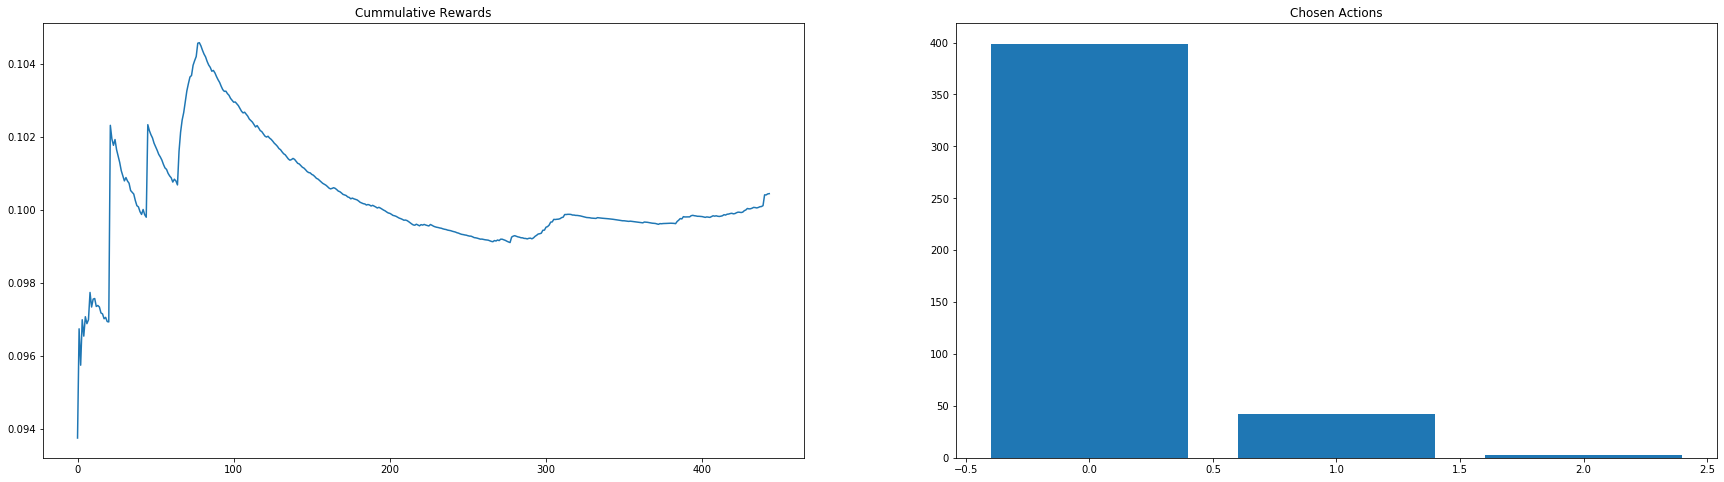

Up to iteration 1003
Average rewards per algo {'quick_sort': 0.04716153846067541, 'merge_sort': 0.033756952877192534, 'heap_sort': 0.24202044804890951}
Count per chosen algo {'quick_sort': 170, 'merge_sort': 387, 'heap_sort': 3}


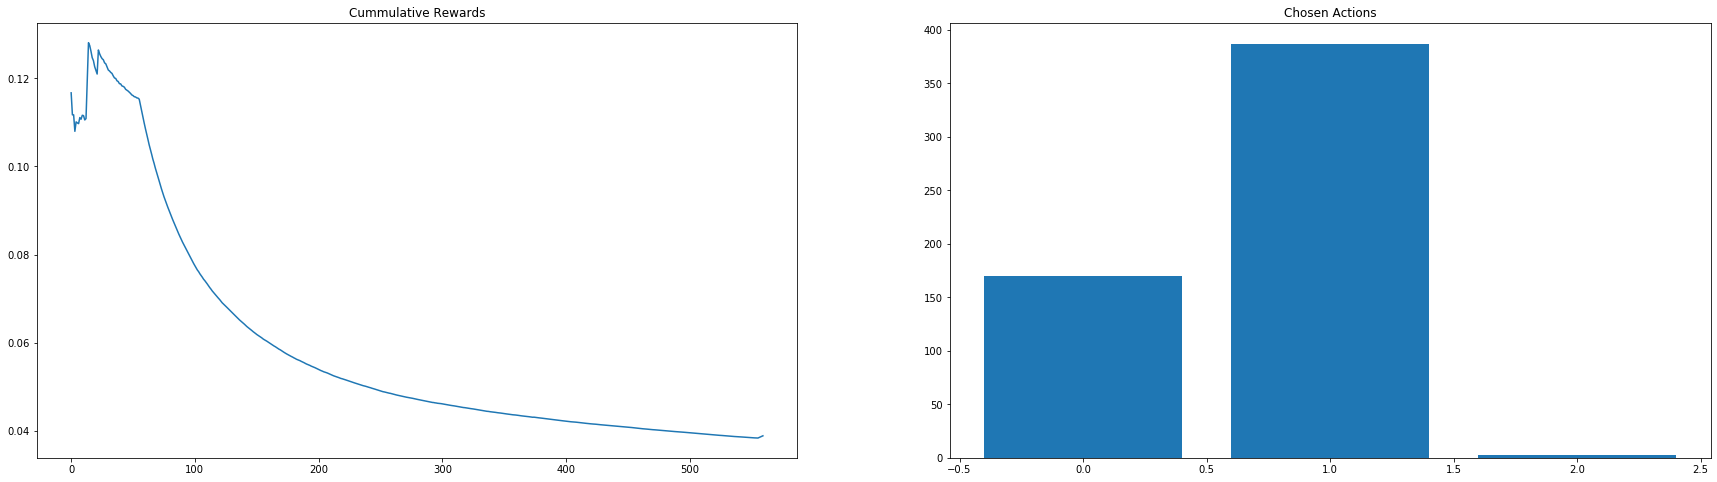

Up to iteration 1140
Average rewards per algo {'quick_sort': 0.10006419894764725, 'merge_sort': 0.10986333423190647, 'heap_sort': 0.23580074310302734}
Count per chosen algo {'quick_sort': 103, 'merge_sort': 27, 'heap_sort': 7}


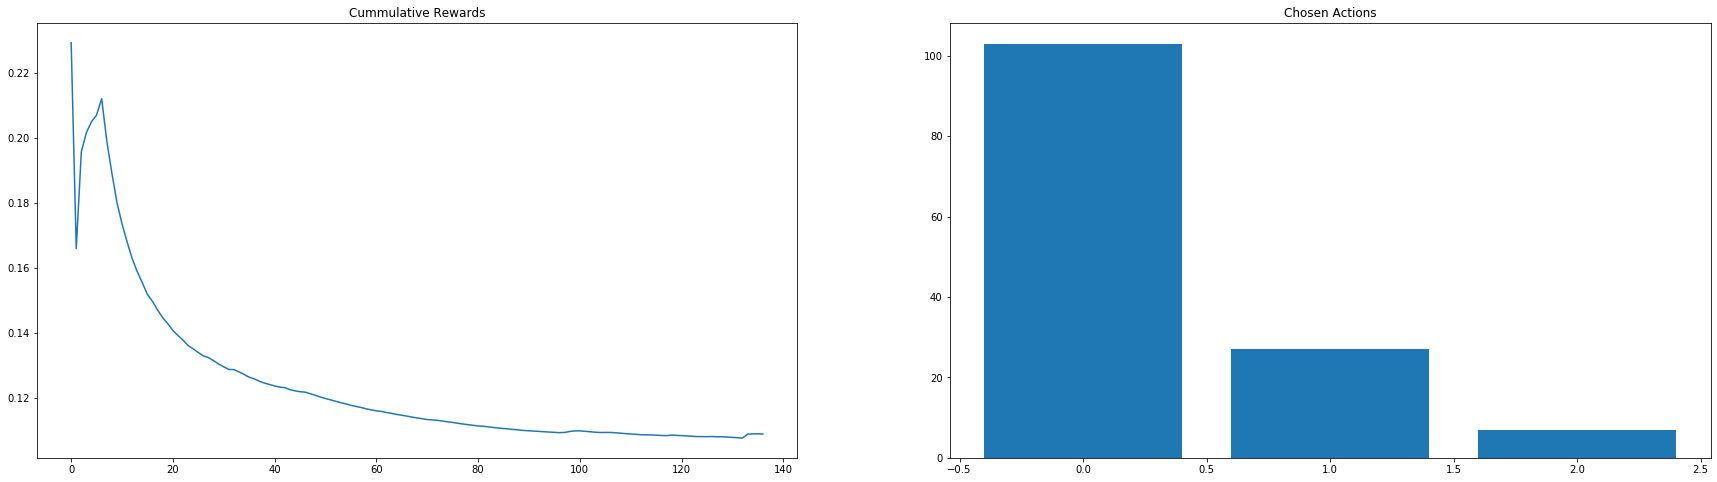

Up to iteration 1503
Average rewards per algo {'quick_sort': 0.09998307504071301, 'merge_sort': 0.10959717205592565, 'heap_sort': 0.21675546964009604}
Count per chosen algo {'quick_sort': 311, 'merge_sort': 49, 'heap_sort': 3}


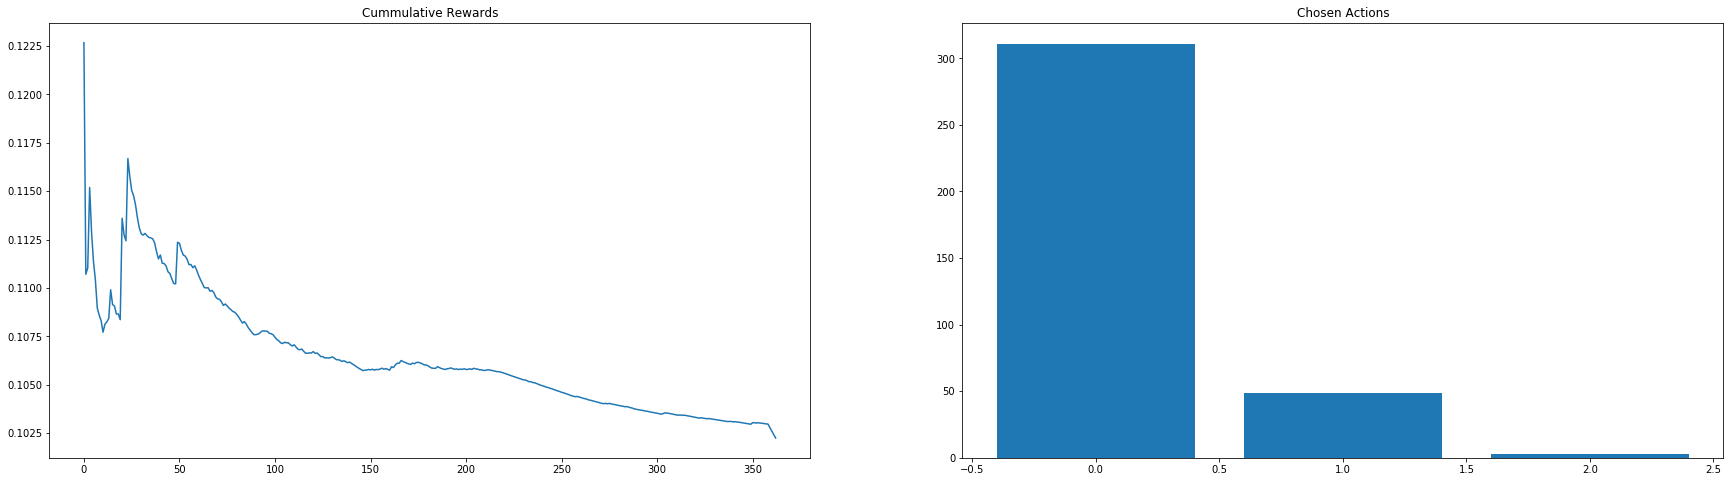

Up to iteration 1999
Average rewards per algo {'quick_sort': 0.03622679568048733, 'merge_sort': 0.02820252231433631, 'heap_sort': 0.07108304717323997}
Count per chosen algo {'quick_sort': 67, 'merge_sort': 418, 'heap_sort': 11}


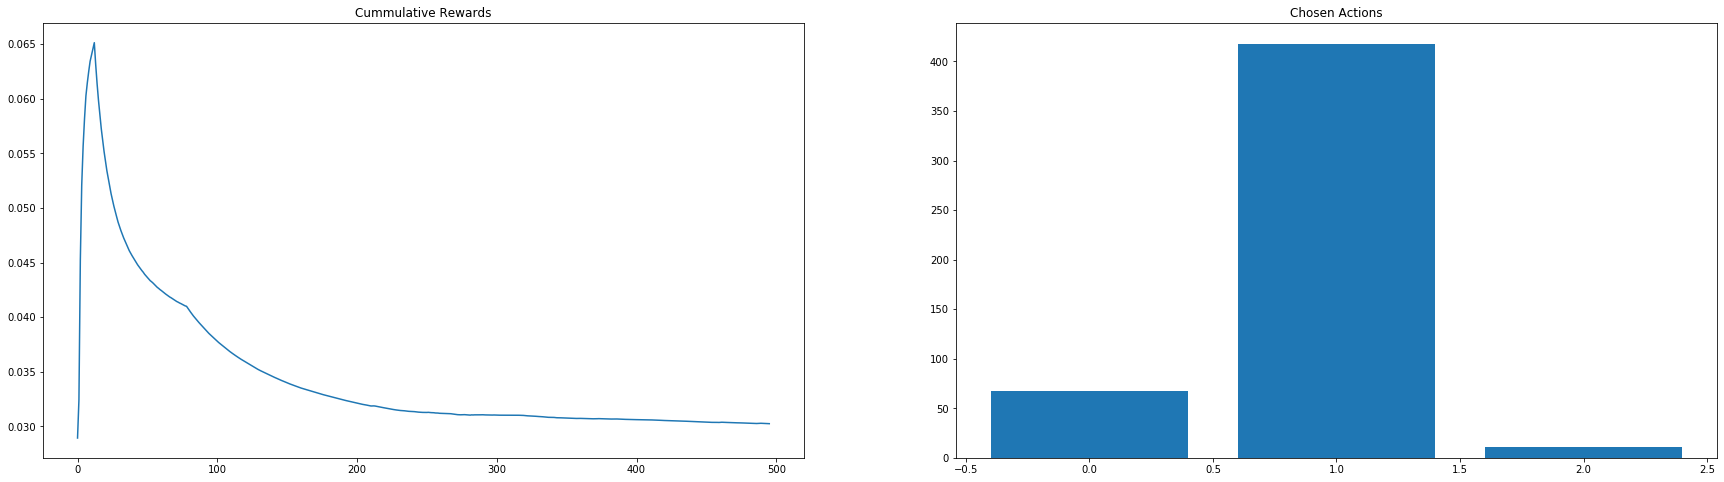

Total reward 133.4428


In [18]:
for elem in list_iteration_results_obcp:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Up to iteration", n)
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_obcp,4))